# <font color=green>deepBreaks Applications</font>
## Predicting the Phenotype of an Opsin From its Amino Acid Sequence...
## This Version of our pipeline uses deepBreaks v. 1.0.1! 
[Env name == deepBreaks_env3 for deepBreaks portion ONLY. Data process steps are completed using 'deepBreaks_perm_env']
</p>

# <font color=red>Step 0: mySQL DB Setup -</font> Script 0
## *The following text is a script written in mySQL format. You can copy and paste this directly into a mySQL text file or query window within mySQL workbench.*
```
DROP DATABASE vizphiz;
CREATE DATABASE vizphiz;
USE vizphiz;

CREATE TABLE lamdamax
(
id int unsigned not null primary key,
genus varchar(50),
species varchar(50),
celltype varchar(50),
cellsubtype varchar(50),
lamdamax decimal(9,5),
error decimal(9,5),
chromophore varchar(50),
method varchar(50),
stage varchar(50),
refid int,
notes varchar(1000)
);

CREATE TABLE heterologous
(
hetid int unsigned not null primary key,
genus  varchar(50),
species varchar(50),
accession varchar(500),
mutations varchar(500),
lamdamax decimal(9,5),
error decimal(9,5),
cellculture varchar(50),
purification varchar(50),
spectrum varchar(50),
sourcetype varchar(50),
refid int,
notes varchar(1000)
);

CREATE TABLE links
(
linkid int unsigned not null primary key,
accession varchar(500),
maxid int,
refid int,
evidence varchar(1000)
);

CREATE TABLE search
(
searchid int unsigned not null primary key,
researcher varchar(50),
month int,
year int,
engine varchar(500),
keywords varchar(500)
);

CREATE TABLE opsins
(
opsinid int unsigned not null primary key,
genefamily varchar(50),
genenames varchar(50),
genus varchar(50),
species varchar(50),
db varchar(50),
accession varchar(500),
dna varchar(10000),
aa varchar(3333),
refid int
);

CREATE TABLE refs
(
refid int,
doilink varchar(100),
searchid int
);
``` 

In [1]:
#All neccessary packages to import for data process steps.
import mysql
#install mysql-connector-python // NOT mysql-connector
import mysql.connector
import argparse
import re
import pandas as pd
import jenkspy 
from matplotlib import pyplot as plt

# <font color=red>STEP 0: Data Base Setup -</font> Script 1 - Import heterologous.tsv into mySQL


In [2]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('heterologous.tsv', 'r', encoding="utf8")
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")
    print(columns)
    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10], columns[12])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")

FileNotFoundError: [Errno 2] No such file or directory: 'heterologous.tsv'

# <font color=red>STEP 0: Data Base Setup -</font> Script 2 - Import opsindb.tsv into mySQL

In [2]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('opsindb.tsv', 'r')
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")

    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.opsins (opsinid, genefamily, genenames, genus, species, db, accession, dna, aa, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")


['1', 'LWS', '', 'Acanthopagrus', 'butcheri', 'NCBI', 'DQ354578.1', 'GGACCCAATTACCACATTGCTCCACGATGGGTTTACAACCTTTCCACATGCTGGATGATTATTGTAGTCATCCTATCAGTCTTCACCAACGGTCTCGTGTTGGTGGCCACGGCAAAGTTCAAGAAACTCCGACACCCTCTGAACTGGATCTTAGTCAATCTCGCAATTGCTGATCTTGGAGAAACAGTTTTTGCCAGCACTATCAGTGTATGCAACCAGTATTTTGGTTACTTCATTCTCGGACACCCGATGTGCATCTTTGAGGGCTACACTGTCTCAGTTTGCGGAATTACTGCTCTCTGGTCCCTGACGATCATCTCCTGGGAGAGGTGGATAGTTGTGTGCAAACCTTTTGGAAACATCAAATTTGATGAAAAATGGGCCATAAGTGGAATAGTGTTCTCCTGGGTCTGGTCAGCAGTGTGGTGTGCTCCCCCCATCTTTGGATGGAGCAGGTACTGGCCTCATGGTCTGAAGACTTCCTGTGGCCCTGATGTATTCAGTGGAAGCGAAGACCCTGGCGTTCAGTCCTACATGGTTGTTCTTATGATCACATGTTGCTTGATTCCTCTGGCTATCATCATCTTATGCTATCTCGCAGTCTGGCTGGCCATCCGTGCAGTTGCCATGCAGCAGAAAGAGTCAGAGTCGACTCAGAAGGCCGAGAGAGAAGTATCCAGGATGGTTGTCGTCATGATCTTTGCATATTGCTTTTGTTGGGGTCCTTACACGTTTTTTGCCTGCTTTGCTGCGGCTAACCCGGGATATGCGTTCCATCCCCTGGCTGCTGCCTTACCTGCCTACTTCGCCAAGAGCGCCACCATCTACAACCCTGTAGTCTAC', 'GPNYHIAPRWVYNLSTCWMIIVVILSVFTNGLVLVATAKFKKLRHPLNWILVNLAIADLGETVFASTISVCNQYFGYFILGHPM

IndexError: list index out of range

# <font color=red>STEP 1: Extract Data From Vizphiz</font>
### Output = 5 different 'versions' // 'splits' of the data. 
### !Take outputs and run through MAFFT before moving on to STEP2!
### Suggested parameters for 'mafft' alignment are...
1. Fasta Format (Input Order)

2. Strategy = FFT-NS-2 // G-INS-1

In [6]:
inv = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
rod = re.compile('Rh[0-2]|exoRh')
d = re.compile("^NM_001014890.2$|^NM_001014890$")
iec = re.compile("Limenitis|Papilio")



mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database="vizphiz",
  password="Geass5566!!"
) 
mycursor = mydb.cursor()

sql = "select DISTINCT o.genus,o.species,o.genefamily,o.accession,h.lamdamax, o.aa from opsins.opsins o, opsins.heterologous h WHERE (o.accession = h.accession AND o.refid = h.refid); "
mycursor.execute(sql)
myresult = mycursor.fetchall()

props = ["LambdaMax"]
wds_hist_df = pd.DataFrame(columns=props)
wds_ni_hist_df = pd.DataFrame(columns=props)
rod_hist_df = pd.DataFrame(columns=props)

for x in myresult:
  
  wds_hist_df = wds_hist_df.append({"LambdaMax":float(x[4])}, ignore_index=True)

  if (inv.match(x[2]) or iec.match(x[0])):
    pass
  else:  
    wds_ni_hist_df = wds_ni_hist_df.append({"LambdaMax":float(x[4])}, ignore_index=True)

  if rod.match(x[2]):
    if (inv.match(x[2]) or iec.match(x[0])):
       pass
    else: 
      rod_hist_df = rod_hist_df.append({"LambdaMax":float(x[4])}, ignore_index=True)

hist_list = [wds_hist_df, wds_ni_hist_df, rod_hist_df]

print(hist_list[0])

C:\Users\safra\AppData\Local\Temp\ipykernel_8072\590022253.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wds_hist_df = wds_hist_df.append({"LambdaMax":float(x[4])}, ignore_index=True)
C:\Users\safra\AppData\Local\Temp\ipykernel_8072\590022253.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wds_ni_hist_df = wds_ni_hist_df.append({"LambdaMax":float(x[4])}, ignore_index=True)
C:\Users\safra\AppData\Local\Temp\ipykernel_8072\590022253.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rod_hist_df = rod_hist_df.append({"LambdaMax":float(x[4])}, ignore_index=True)
C:\Users\safra\AppData\Local\Temp\ipykernel_8072\590022253.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

     LambdaMax
0        502.0
1        502.0
2        481.0
3        494.0
4        494.0
..         ...
825      546.0
826      558.0
827      559.0
828      556.0
829      559.0

[830 rows x 1 columns]


C:\Users\safra\AppData\Local\Temp\ipykernel_8072\590022253.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rod_hist_df = rod_hist_df.append({"LambdaMax":float(x[4])}, ignore_index=True)
C:\Users\safra\AppData\Local\Temp\ipykernel_8072\590022253.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wds_hist_df = wds_hist_df.append({"LambdaMax":float(x[4])}, ignore_index=True)
C:\Users\safra\AppData\Local\Temp\ipykernel_8072\590022253.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wds_ni_hist_df = wds_ni_hist_df.append({"LambdaMax":float(x[4])}, ignore_index=True)
C:\Users\safra\AppData\Local\Temp\ipykernel_8072\590022253.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

[  0.  393.  467.6 496.  509.  611. ]


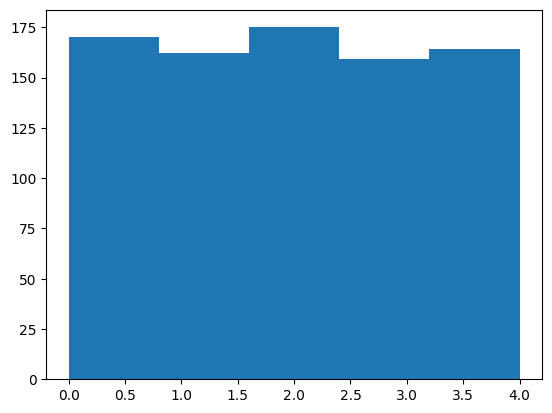

[  0.  360.  393.  430.  467.6 488.  496.  501.  509.  533.1 611. ]


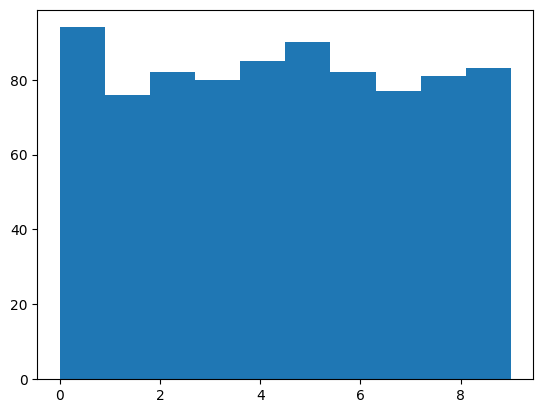

[  0.         359.         363.         393.         418.06666667
 441.         467.6        486.         491.         496.
 500.         502.         509.         525.         548.73333333
 611.        ]


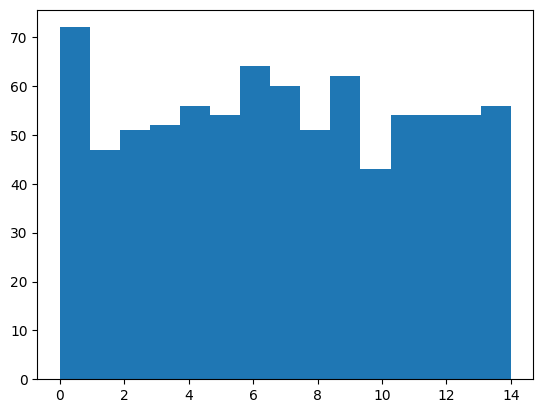

[array([  0. , 393. , 467.6, 496. , 509. , 611. ]), array([  0. , 360. , 393. , 430. , 467.6, 488. , 496. , 501. , 509. ,
       533.1, 611. ]), array([  0.        , 359.        , 363.        , 393.        ,
       418.06666667, 441.        , 467.6       , 486.        ,
       491.        , 496.        , 500.        , 502.        ,
       509.        , 525.        , 548.73333333, 611.        ])]
[  0. 382. 463. 492. 503. 578.]


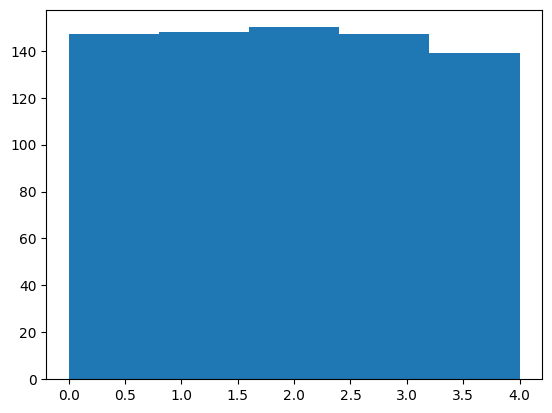

[  0. 360. 382. 419. 463. 486. 492. 499. 503. 516. 578.]


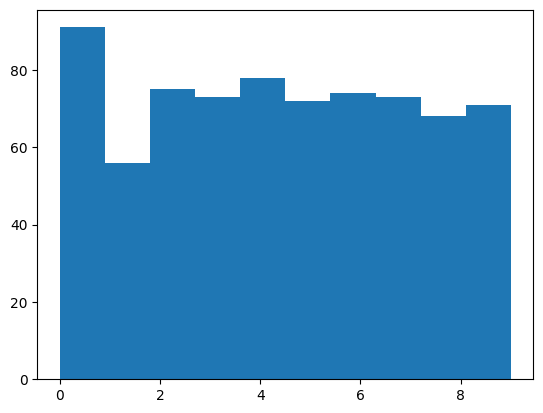

[  0.         359.         361.         382.         414.
 431.66666667 463.         482.         488.         492.
 497.         500.         503.         511.         532.
 578.        ]


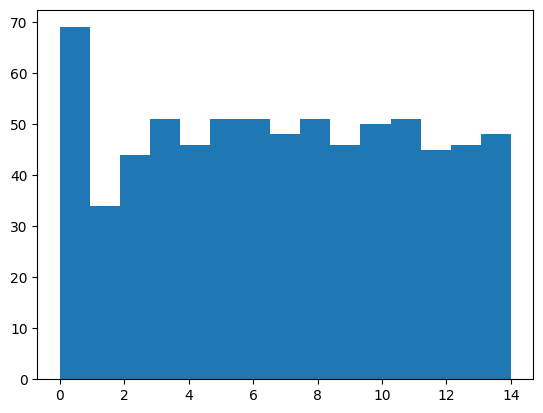

[array([  0., 382., 463., 492., 503., 578.]), array([  0., 360., 382., 419., 463., 486., 492., 499., 503., 516., 578.]), array([  0.        , 359.        , 361.        , 382.        ,
       414.        , 431.66666667, 463.        , 482.        ,
       488.        , 492.        , 497.        , 500.        ,
       503.        , 511.        , 532.        , 578.        ])]
[  0. 485. 492. 499. 503. 554.]


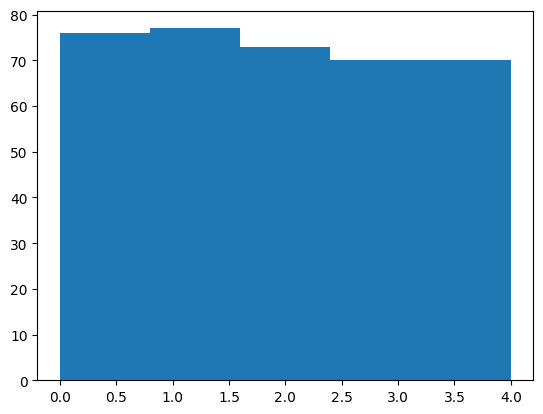

[  0.  475.  485.  489.  492.  496.  499.  501.  503.  509.5 554. ]


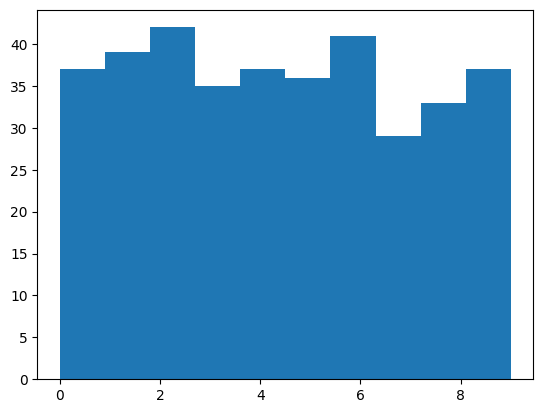

[  0.  467.  481.  485.  488.  490.  492.  494.  497.  499.  500.  501.9
 503.  508.  514.  554. ]


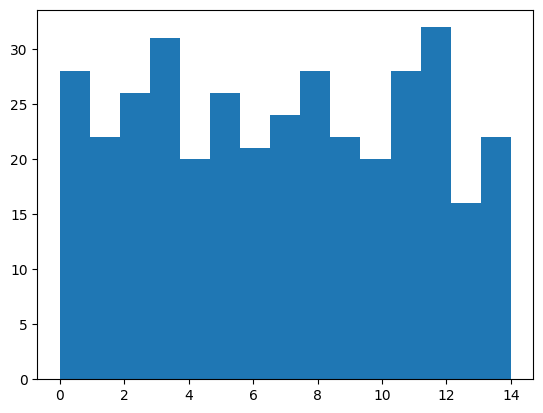

[array([  0., 485., 492., 499., 503., 554.]), array([  0. , 475. , 485. , 489. , 492. , 496. , 499. , 501. , 503. ,
       509.5, 554. ]), array([  0. , 467. , 481. , 485. , 488. , 490. , 492. , 494. , 497. ,
       499. , 500. , 501.9, 503. , 508. , 514. , 554. ])]


In [7]:
x = 0
wds_class_list = []
wds_ni_class_list = []
rod_class_list = []

for hist_df in hist_list:
    five = pd.qcut(hist_df['LambdaMax'], q=5, precision=1, labels=False, retbins=True)
    fiv_list = five[1]
    print(five[1])
    hist_df['bin_qcut5'] = pd.qcut(hist_df['LambdaMax'], q=5, precision=1, labels=False, retbins = False)
    plt.hist(hist_df['bin_qcut5'], bins=5)
    plt.show()

    ten = pd.qcut(hist_df['LambdaMax'], q=10, precision=1, labels=False, retbins=True)
    ten_list = ten[1]
    print(ten[1])
    hist_df['bin_qcut10'] = pd.qcut(hist_df['LambdaMax'], q=10, precision=1, labels=False, retbins = False)
    plt.hist(hist_df['bin_qcut10'], bins=10)
    plt.show()

    fifteen = pd.qcut(hist_df['LambdaMax'], q=15, precision=1, labels=False, retbins=True)
    fif_list = fifteen[1]
    print(fifteen[1])
    hist_df['bin_qcut15'] = pd.qcut(hist_df['LambdaMax'], q=15, precision=1, labels=False, retbins = False)
    plt.hist(hist_df['bin_qcut15'], bins=15)
    plt.show()

    if x == 0:
        wds_class_list = [fiv_list, ten_list, fif_list]
        print(wds_class_list)
    elif x == 1:
        wds_ni_class_list = [fiv_list, ten_list, fif_list]
        print(wds_ni_class_list)
    else:
        rod_class_list = [fiv_list, ten_list, fif_list]
        print(rod_class_list)

    x+=1

In [8]:
#Allows for automatic multifacet class assignment during datasplitting
def class_assignment(lmax, class_bounds):
  #lmax = x[4]
  #class_bounds = class_list[splits]
  opclass = 0
  while opclass < len(class_bounds)-1:
    if (round(lmax) > int(class_bounds[opclass]) and round(lmax) <= int(class_bounds[opclass+1])):
        return(opclass)
      
    else:
      opclass += 1

In [9]:
#STEP 1: Extract Data From Vizphiz``

#3 different 'version' // 'splits' of the raw sequence data 
wd_output = 'wds.txt'
wd_ni_output = 'wds_ni.txt'
rod_output = 'rod.txt'

#Regular Metadata Files
wds_metadata = 'wds_meta.tsv'
wd_ni_metadata = 'wds_ni_meta.tsv'
rh_metadata = 'rod_meta.tsv'

#Classifer Specific Metadata Files
class_ni_metadata = ['class_ni_meta_5.tsv','class_ni_meta_10.tsv','class_ni_meta_15.tsv']
class_metadata = ['class_meta_5.tsv','class_meta_10.tsv','class_meta_15.tsv']
class_rod_metadata = ['class_rod_meta_5.tsv','class_rod_meta_10.tsv','class_rod_meta_15.tsv']

invert_counter = 'invert_data.tsv'
#class_ranges = 'classifier_ranges.tsv'
m = 0
s = 0
l = 0
r = 0
c = 0
d = re.compile("^NM_001014890.2$|^NM_001014890%")
iec = re.compile("Limenitis|Papilio")
inv = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
acc_list = []
duped = 0

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database="vizphiz",
  password="Geass5566!!"
) 
mycursor = mydb.cursor()

sql = "select DISTINCT o.genus,o.species,o.genefamily,o.accession,h.lamdamax, o.aa from opsins.opsins o, opsins.heterologous h WHERE (o.accession = h.accession AND o.refid = h.refid); "
mycursor.execute(sql)
myresult = mycursor.fetchall()

class_bounds = ten_list

for x in myresult:       

  #Keep all accessions in a list -- don't print 
  if (x[3] in acc_list):
    #print ("\n\n\n****Accession Exists" + x[2] + "\n\n" )
    duped=1
  #First 2 of if statements ignore ancestral (pigment named) or mutated genes
  if (duped==1) :
    duped=0
  #do not print if contains the word "pigment" which is an ancestral sequence

  else :
#REG-DATA SECTION    
       with open(wd_output, 'a') as f:
          if m == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          if (d.match(x[3]) or (x[4] == 0)):
            pass
          else:
            m += 1 
            #This makes the fasta format file
            seq = ">S" + str(m)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)
 
       with open(wd_ni_output, 'a') as f:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
        if (p.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
          pass
        else:
          if c == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")

          c += 1 
          #This makes the fasta format file
          seq = ">S" + str(c)
          f.write(seq)
          seq2 = str('\n' + x[5] + '\n')
          f.write(seq2)

       with open(rod_output, 'a') as f:

        p = re.compile('Rh[0-2]|exoRh')
        if p.match(x[2]):
          if r == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          if (inv.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
            pass
          else:
            r+=1
            #This makes the fasta format file
            seq = ">S" + str(r)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)

#CLASS METADATA SECTION          
       for splits in range(len(class_metadata)): 
        with open(class_metadata[splits], 'a') as h:
            #This makes the metadata formatted for a classification model. 
          if m == 1:
            h.write("\tOpsin_Class\n")
            h.write("Bovine\t" + str(class_assignment(500.000, wds_class_list[splits])) + "\n")
          if (d.match(x[3]) or (x[4] == 0)):
            pass
          else:  
            md = "S" + str(m) + "\t" + str(class_assignment(x[4], wds_class_list[splits])) + "\n"
            h.write(md)

        with open(class_ni_metadata[splits], 'a') as h:
          p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
          if (p.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
            pass
          else:
            if c == 1:
              h.write("\tOpsin_Class\n")
              h.write("Bovine\t" + str(class_assignment(500.000, wds_ni_class_list[splits])) + "\n")

            
            md = "S" + str(c) + "\t" + str(class_assignment(x[4], wds_ni_class_list[splits])) + "\n"
            h.write(md)

        with open(class_rod_metadata[splits], 'a') as h:
            #This makes the metadata formatted for a classification model. 
          p = re.compile('Rh[0-3]|exoRh')
          if p.match(x[2]):
            if r == 1:
              h.write("\tOpsin_Class\n")
              h.write("Bovine\t" + str(class_assignment(500.000, rod_class_list[splits])) + "\n")
            if (inv.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
              pass
            else:  
              md = "S" + str(r) + "\t" + str(class_assignment(x[4], rod_class_list[splits])) + "\n"
              h.write(md)


#REGULAR METADATA SECTION
       with open(wds_metadata, 'a') as g:
        if m == 1:
          g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")  
          g.write("Bovine\t500\tBos_tarus.0000\tRh1\tNM_001014890\n")
        if (d.match(x[3]) or x[4] == 0):
          pass
        else:        
          md =  str("S" + str(m) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

       with open(wd_ni_metadata, 'a') as g:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
        if (p.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
          pass
        else:
          if c == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
            g.write("Bovine\t500.0000\tBos_tarus\tRh1\tNM_001014890\n")

          md =  str("S" + str(c) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

       with open(rh_metadata, 'a') as g:
        #This makes the metadata formatted for a linear regression model.
        p = re.compile('Rh[0-3]|exoRh')

        if p.match(x[2]):
          if r == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
            g.write("Bovine\t500.0000\tBos_taurus\tRh1\tNM_001014890\n")
          if (inv.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
            pass
          else:  
            md =  str("S" + str(r) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
            g.write(md)



# <font color=red>STEP 2: Format Alignments for 'deepBreaks'</font>
## REMINDER - Take outputs from STEP 1 and run through MAFFT before moving on to STEP2

In [31]:
#enter list of aligned text files here.
inputs = ['wds_ni_aligned.txt']
##enter list of names for desired formatted fasta files here.
output = ['wds_ni_fmt.fasta']
i=0
k = 0
for files in inputs:
    lines = open(inputs[i]).readlines()
    file = open(output[i], 'a+')
    #line_count = len(lines)
    #tab_entry = ""
    #call = input("How Many Lines Per Alignment?: ")
    #count = int(call)
    #loop = range(int(count))
    m=0
    for line in lines:
        snip = str(lines[k])
        if '>' in snip:
            if m == 0:
                m+=1
            else:
                file.write("\n")
            file.write(snip)
        else:
            entry = ""
            entry = str(snip.replace("\n",""))
            file.write(entry)
        k+=1
    k = 0
    i+=1
    file.close()

# <font color=red>STEP 3: deepBreaks</font>
## THIS IS A LONG SECTION! 
### STEP 4 doesn't start until Cell 34

In [ ]:
# importing deepBreaks libraries 
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
#from pycaret.clustering import *
#from pycaret.classification import *

In [109]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [110]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = 'wds_ni_fmt.fasta' 
meta_data = 'class_ni_meta.tsv'
# name of the phenotype
mt = 'Opsin_Class'

# type of the sequences
seq_type = 'aa'
# type of the analysis if it is a classification model, then we put cl instead of reg
anaType = 'cl'
sampleFrac=1

In [111]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [112]:
%%time
# importing sequences data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True)
metaData = prp.read_data(meta_data, is_main=False)
positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading fasta file
Done
Shape of data is:  (692, 356)
CPU times: total: 203 ms
Wall time: 180 ms


In [113]:
df.head()

p1   p2   p3 p4 p5 p6 p7 p8 p9 p10  ... p347 p348 p349 p350 p351  \
Bovine    M    N    G  T  E  G  P  N  F   Y  ...  NaN  NaN  NaN    T    S   
S1        M    N    G  T  E  G  P  Y  F   Y  ...    S    A  NaN  NaN    S   
S2      NaN  NaN  NaN  T  E  G  P  Y  F   Y  ...    S    A  NaN  NaN    S   
S3      NaN  NaN  NaN  T  E  G  P  D  F   Y  ...    S    A  NaN  NaN    S   
S4      NaN  NaN  NaN  T  E  G  P  F  F   Y  ...    S    A  NaN  NaN    S   

       p352 p353 p354 p355 p356  
Bovine    Q    V    A    P    A  
S1        S    V    S    P    A  
S2        S    V    S    P    A  
S3        S    V    S    P    A  
S4        S    V    S    P    A  

[5 rows x 356 columns]

**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [114]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


Opsin_Class
Bovine            7
S1                7
S2                7
S3                4
S4                5

In [115]:
# selecting only the classes with enough number of samples
df = prp.balanced_classes(dat=df, meta_dat=metaData, feature=mt)

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [116]:
%%time
# taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
df = prp.missing_constant_care(df)
print('Shape of data after missing/constant care: ', df.shape)

Shape of data before missing/constant care:  (692, 356)
Shape of data after missing/constant care:  (692, 342)
CPU times: total: 250 ms
Wall time: 252 ms


In [117]:
%%time
# taking care of ultra-rare cases
print('Shape of data before imbalanced care: ', df.shape)
df = prp.imb_care(dat=df)
print('Shape of data after imbalanced care: ', df.shape)

Shape of data before imbalanced care:  (692, 342)
Shape of data after imbalanced care:  (692, 307)
CPU times: total: 594 ms
Wall time: 604 ms


In [118]:
%%time
# Use statistical tests to drop redundant features.
print('number of columns of main data befor: ', df.shape[1])
df_cleaned = prp.redundant_drop(dat=df, meta_dat=metaData,
                        feature=mt, model_type=anaType,
                        threshold=0.25,
                        report_dir=report_dir)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  307
number of columns of main data after:  302
CPU times: total: 1.94 s
Wall time: 1.95 s


In [119]:
%%time
print('one-hot encoding the dataset')
df_cleaned = prp.get_dummies(dat=df_cleaned, drop_first=True)



one-hot encoding the dataset
CPU times: total: 125 ms
Wall time: 124 ms


In [120]:
%%time
print('calculating the distance matrix')
cr = prp.distance_calc(dat=df_cleaned,
                       dist_method='correlation',
                       report_dir=report_dir)
print(cr.shape)

calculating the distance matrix
(844, 844)
CPU times: total: 859 ms
Wall time: 863 ms


In [121]:
print('The distance matrix looks like this.\n The values are between 0 (exact the same) and 1 (non-related).')
cr.head()

The distance matrix looks like this.
 The values are between 0 (exact the same) and 1 (non-related).


p1_LQFPAH      p1_M  p2_DLMTQGPHY    p2_GAP      p2_N      p2_S  \
p1_LQFPAH      0.000000  0.465992      0.999601  0.833161  0.974467  0.787905   
p1_M           0.465992  0.000000      0.977017  0.388498  0.741207  0.591166   
p2_DLMTQGPHY   0.999601  0.977017      0.000000  0.882011  0.753970  0.842948   
p2_GAP         0.833161  0.388498      0.882011  0.000000  0.601625  0.745700   
p2_N           0.974467  0.741207      0.753970  0.601625  0.000000  0.469735   

                  p3_G    p3_GAP      p4_G    p4_GAP  ...    p352_S    p353_V  \
p1_LQFPAH     0.799481  0.663125  0.933399  0.838565  ...  0.615492  0.901476   
p1_M          0.851105  0.904317  0.893749  0.731847  ...  0.859215  0.507941   
p2_DLMTQGPHY  0.781987  0.844636  0.925996  0.809997  ...  0.947900  0.912354   
p2_GAP        0.553973  0.504747  0.849897  0.449473  ...  0.897127  0.507499   
p2_N          0.106836  0.195612  0.687007  0.614527  ...  0.937526  0.972723   

                p354_G  p354_GAP    p354_S    p355_P  p356_ENTG  p356_GAP  \
p1_LQFPAH     0.842206  0.824815  0.969009  0.824815   0.889694  0.824815   
p1_M          0.964067  0.693201  0.782212  0.693201   0.872491  0.693201   
p2_DLMTQGPHY  0.981452  0.870657  0.947007  0.870657   0.911617  0.870657   
p2_GAP        0.935321  0.835516  0.715479  0.835516   0.690361  0.835516   
p2_N          0.623222  0.873682  0.995893  0.873682   0.701588  0.873682   

                p356_H    p356_S  
p1_LQFPAH     0.906718  0.851931  
p1_M          0.825317  0.793717  
p2_DLMTQGPHY  0.934030  0.967382  
p2_GAP        0.893181  0.846016  
p2_N          0.777262  0.637611  

[5 rows x 844 columns]

In [122]:
%%time
print('finding colinear groups')
dc_df = prp.db_grouped(dat = cr,
                       report_dir=report_dir,
                       threshold=.3,)

finding colinear groups
CPU times: total: 46.9 ms
Wall time: 49 ms


In [123]:
print('The result of the last step is a dataframe with two columns,\
1)feature and 2)group.\nif there are no groups, it will be an empty dataframe')
dc_df.head()

The result of the last step is a dataframe with two columns,1)feature and 2)group.
if there are no groups, it will be an empty dataframe


feature group
0  p1_LQFPAH    g0
1       p1_M    g0
3     p2_GAP    g0
4       p2_N    g1
5       p2_S    g1

Then, we pass the above calculated groupes into the *group_feature* function. This function finds the distance of all the group members to the center of the group (median). The result will be a dictionary of columns like this:  
\
{\
group1_representativ:[member1, member2,...],  
group2_representativ:[member1, member2,...],...  
}

In [124]:
%%time
print('grouping features')
dc = prp.group_features(dat=df_cleaned,
                        group_dat=dc_df,
                        report_dir=report_dir)
#file2 = open('dc_cols.txt', 'a+')
#training = str(dc)
#file2.write(training)
#file2.close()                      

grouping features
CPU times: total: 93.8 ms
Wall time: 93 ms


In [125]:
print('dropping correlated features')
print('Shape of data before collinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after collinearity care: ', df_cleaned.shape)
#file2 = open('train_cols.txt', 'w')
#training = (df_cleaned.to_string())
#file2.write(training)
#file2.close()
#USE FOR TRAIN COLS! It's the correct format. Import into excel. 

training_col_list = df_cleaned.columns.tolist()

dropping correlated features
Shape of data before collinearity care:  (692, 844)
Shape of data after collinearity care:  (692, 247)


In [126]:
#merge with meta data
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

#file2 = open('testing_cols.txt', 'a+')
#raw_training = df.to_string()
#training = df_cleaned.to_string()
#file2.write(raw_training)
#file2.write(training)
#file2.close()

## Modelling
In this step, we try to fit multiple models to the training dataset and rank them based on their performance. By default, we select the top 3 three models for further analysis.  
During this step, deepBreaks creates a CSV file containing all the fitted models with their performance metrics. These metrics are based on an average of 10-fold cross-validation.

In [127]:
%%time
models_to_select = 5 # number of top models to select
trained_models = ml.model_compare(X_train=df_cleaned.loc[:, df_cleaned.columns != mt],
                                  y_train=df_cleaned.loc[:, mt],
                                  sort_by='F1',n_positions=positions,
                                  grouped_features=dc, report_dir=report_dir,
                                  ana_type=anaType, select_top=models_to_select)

Fitting rf_with_default_parameters
Fitting rf_max_depth=4_n_estimators=500
Fitting rf_max_depth=4_n_estimators=1000
Fitting rf_max_depth=6_n_estimators=500
Fitting rf_max_depth=6_n_estimators=1000
Fitting rf_max_depth=8_n_estimators=500
Fitting rf_max_depth=8_n_estimators=1000
Fitting Adaboost_with_default_parameters
Fitting Adaboost_learning_rate=0.01_n_estimators=50
Fitting Adaboost_learning_rate=0.01_n_estimators=100
Fitting Adaboost_learning_rate=0.05_n_estimators=50
Fitting Adaboost_learning_rate=0.05_n_estimators=100
Fitting et_with_default_parameters
Fitting et_max_depth=4_n_estimators=500
Fitting et_max_depth=4_n_estimators=1000
Fitting et_max_depth=6_n_estimators=500
Fitting et_max_depth=6_n_estimators=1000
Fitting et_max_depth=8_n_estimators=500
Fitting et_max_depth=8_n_estimators=1000
Fitting lg_with_default_parameters
Fitting gbc_with_default_parameters
Fitting dt_with_default_parameters
Fitting dt_max_depth=4
Fitting dt_max_depth=6
Fitting dt_max_depth=8
Fitting xgb_with_d

In [128]:
# to access the importances
model_names = list(trained_models.keys())
print("Top model: ", model_names[0])
first_model_imp = viz._importance_to_df(trained_models[model_names[0]]['importance'])
first_model_imp.head()

Top model:  et_max_depth=8_n_estimators=1000


feature     value  standard_value
0        1  0.002491        0.080209
1        2  0.004449        0.143291
2        3  0.001460        0.047026
3        4  0.014885        0.479358
4        5  0.008699        0.280160

In [129]:
print('Available information for each model:')
print(trained_models[model_names[0]].keys())

Available information for each model:
dict_keys(['metrics', 'importance', 'model'])


## Interpretation 
In this step, we use the training data set, positions, and the top models to report the most discriminative positions in the sequences associated with the phenotype.  
we report the feature importances for all top models separately and make a box plot (regression) or stacked bar plot (classification) for the top 4 positions.

et_max_depth=8_n_estimators=1000 Done
et_max_depth=8_n_estimators=1000  Done
et_max_depth=8_n_estimators=500 Done
et_max_depth=8_n_estimators=500  Done
rf_max_depth=8_n_estimators=1000 Done
rf_max_depth=8_n_estimators=1000  Done
lgbm_with_default_parameters Done
lgbm_with_default_parameters  Done
rf_max_depth=8_n_estimators=500 Done
rf_max_depth=8_n_estimators=500  Done
mean Done


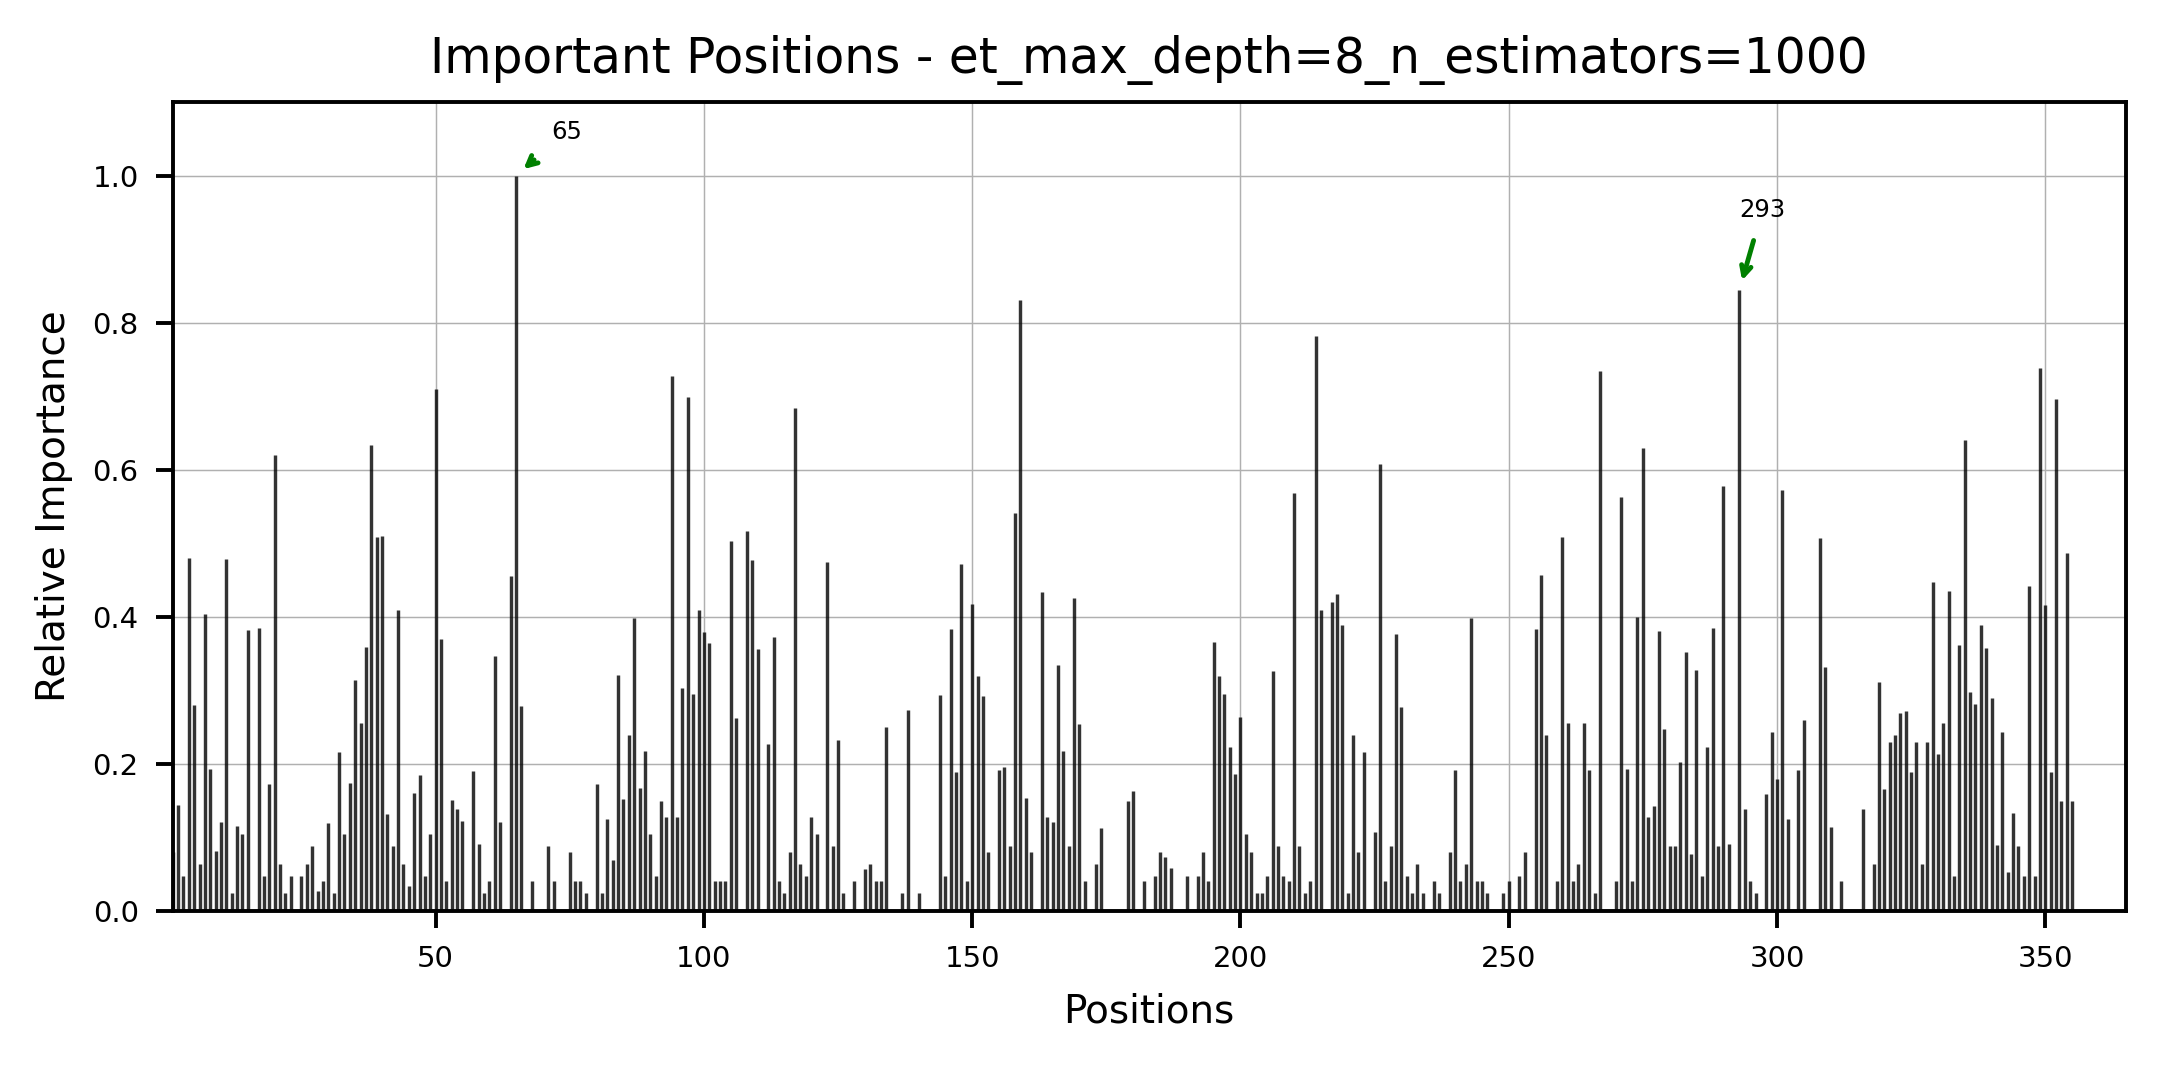

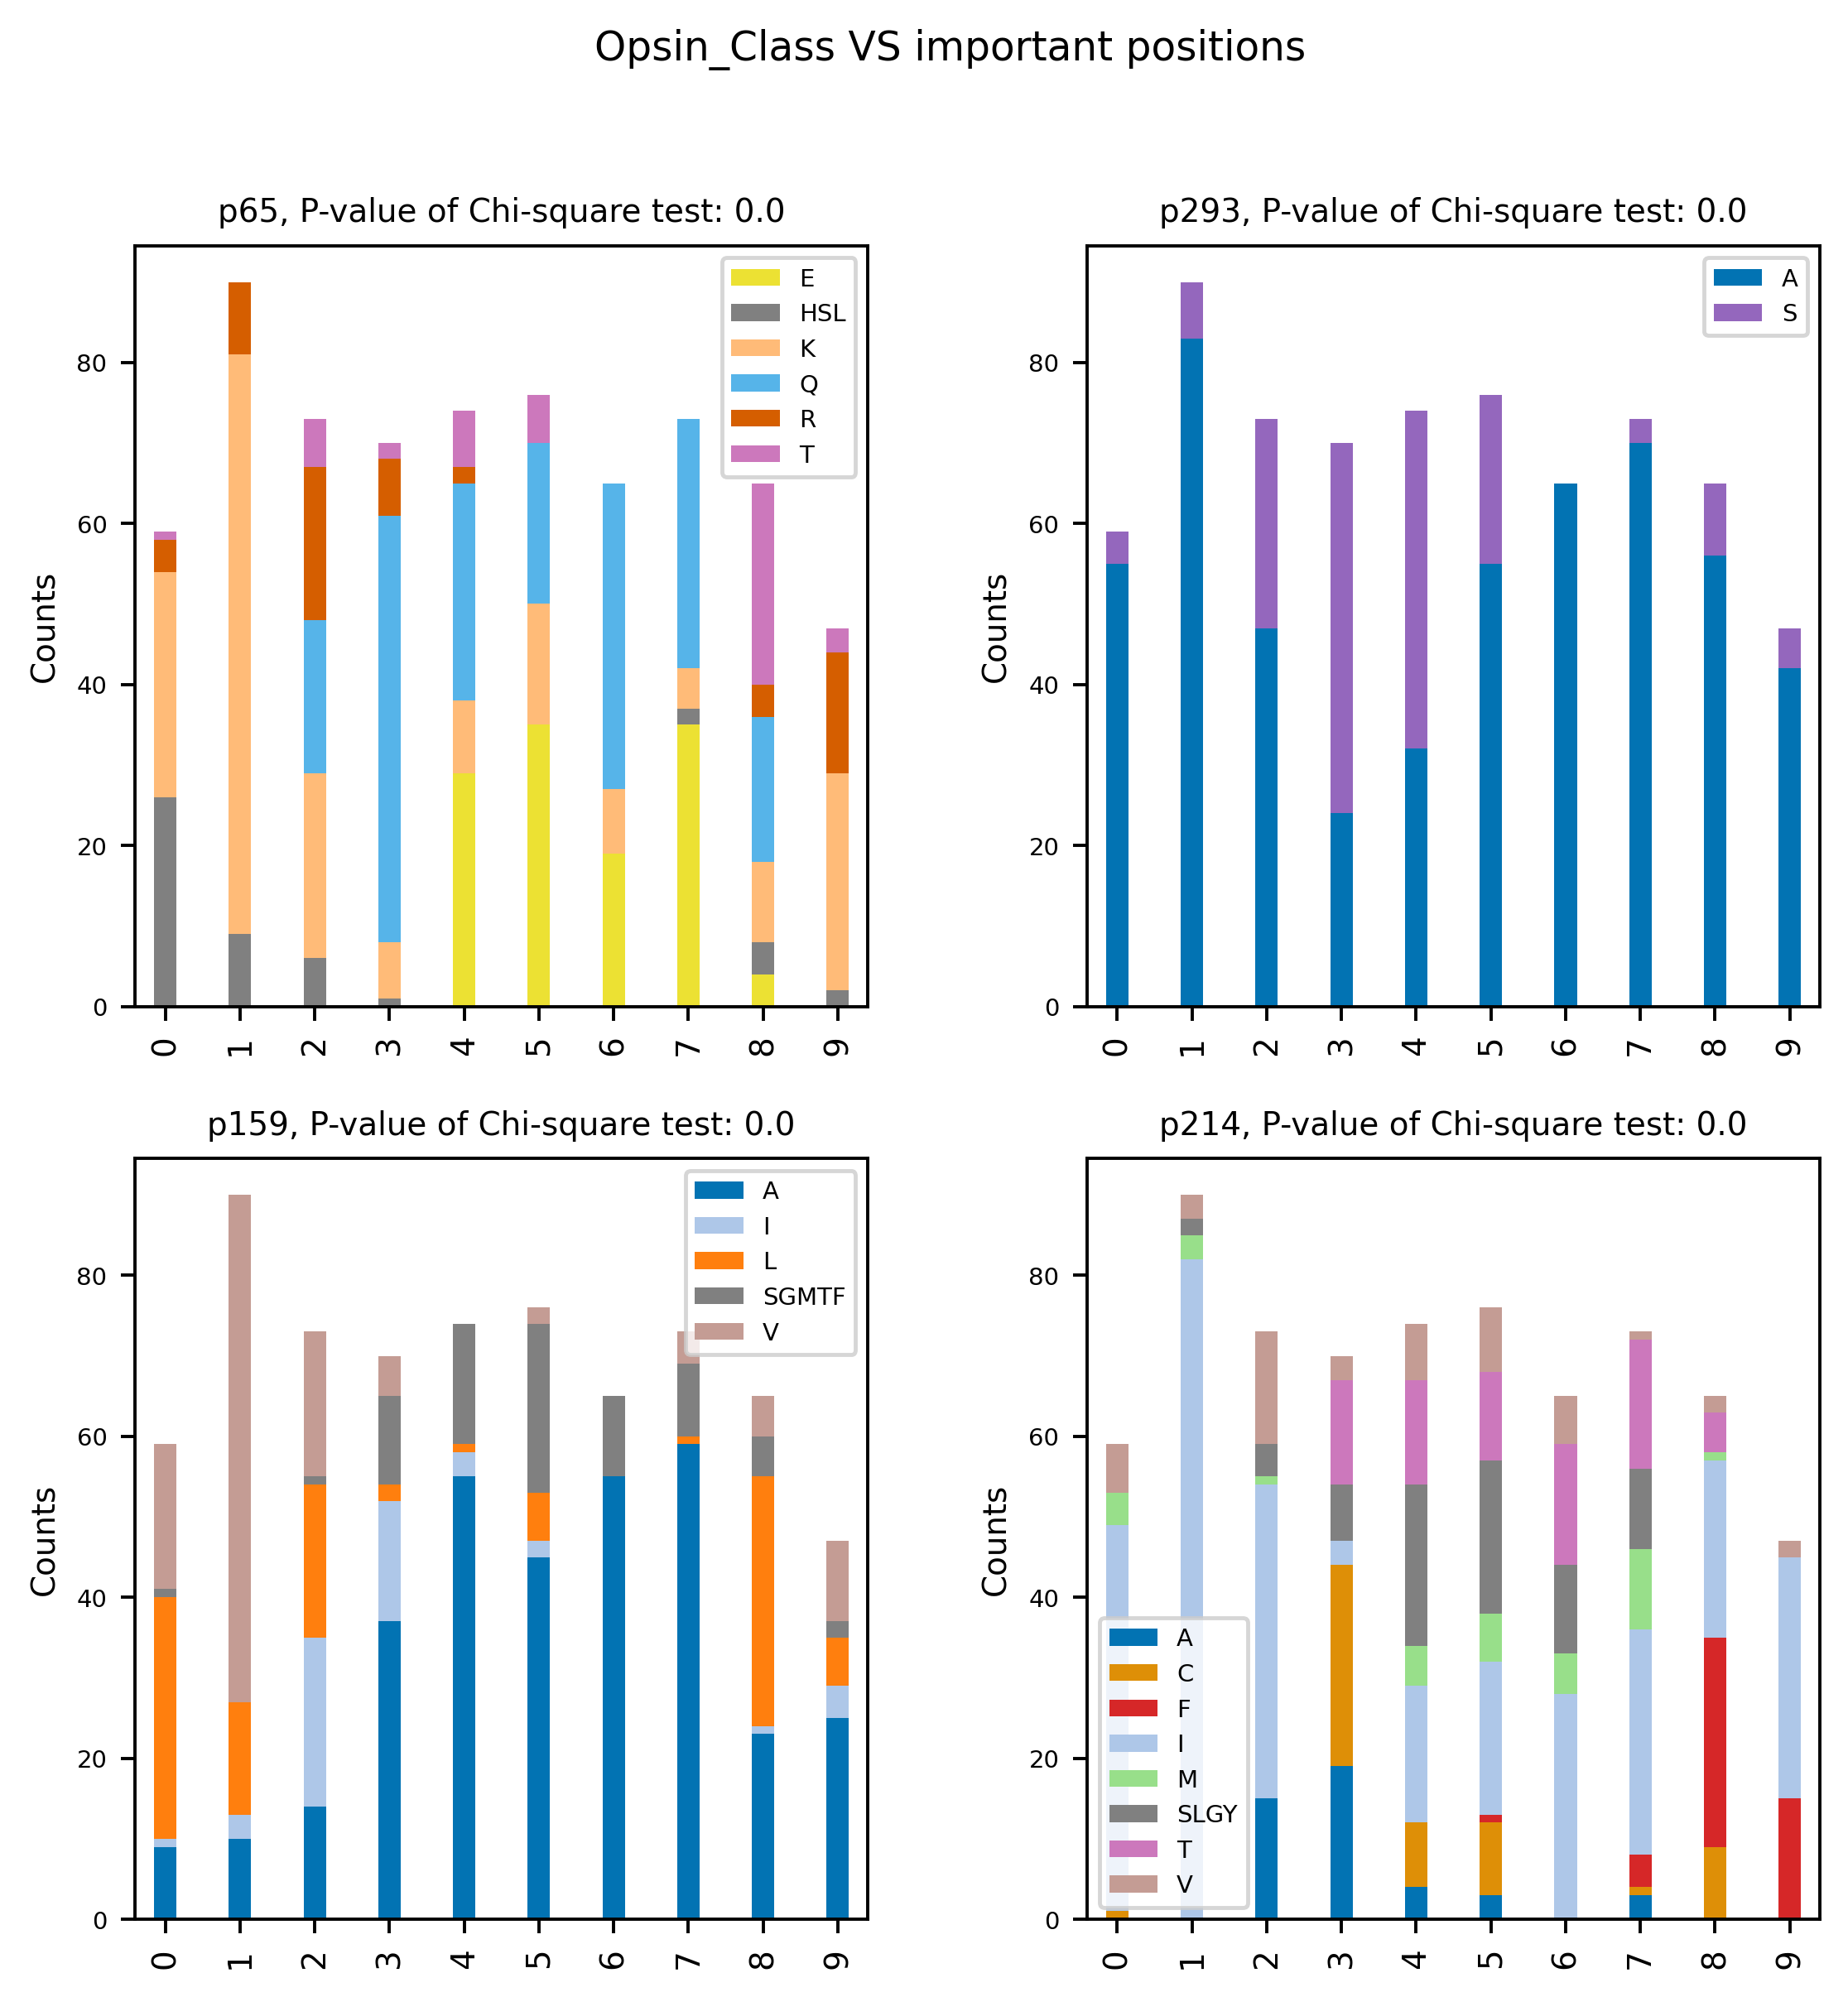

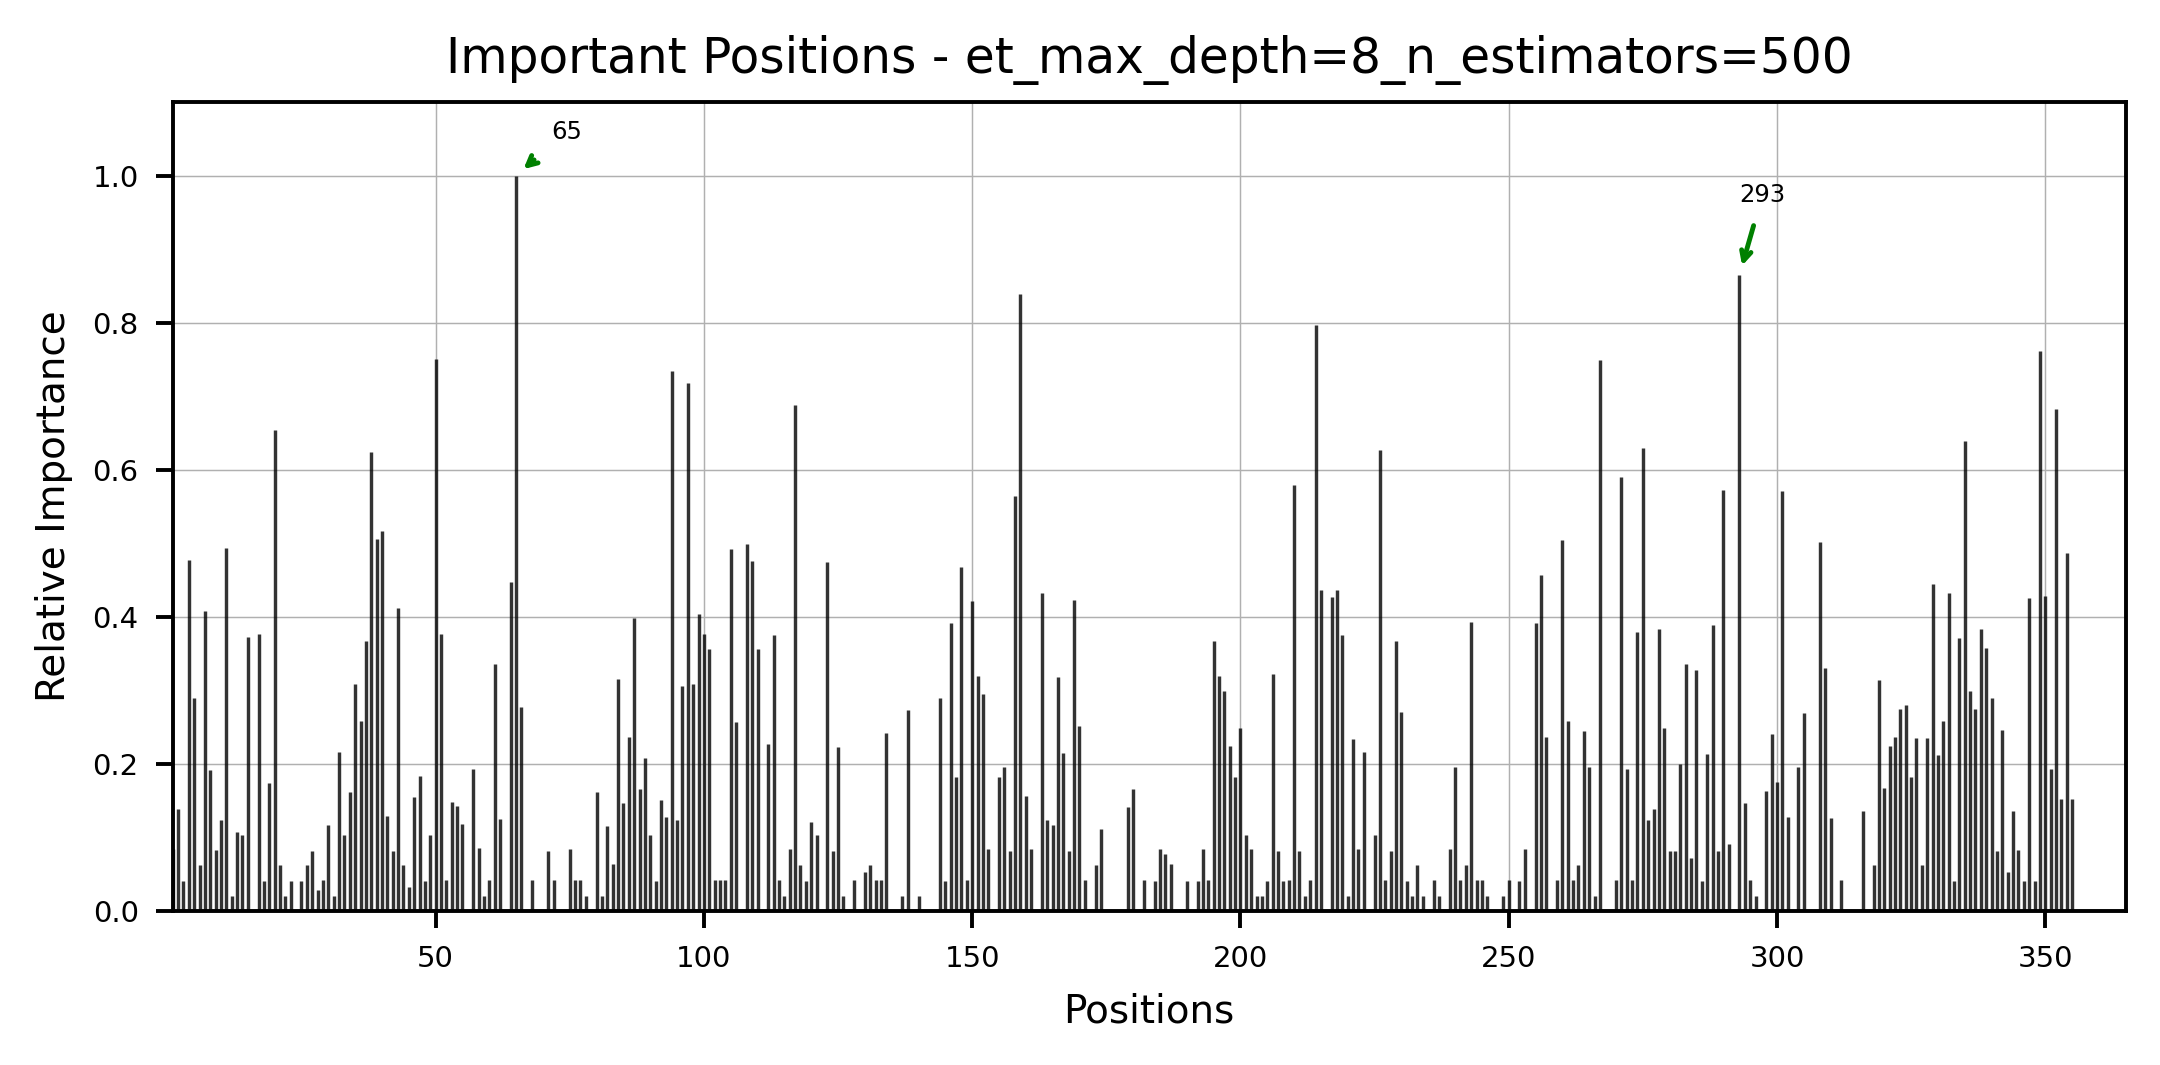

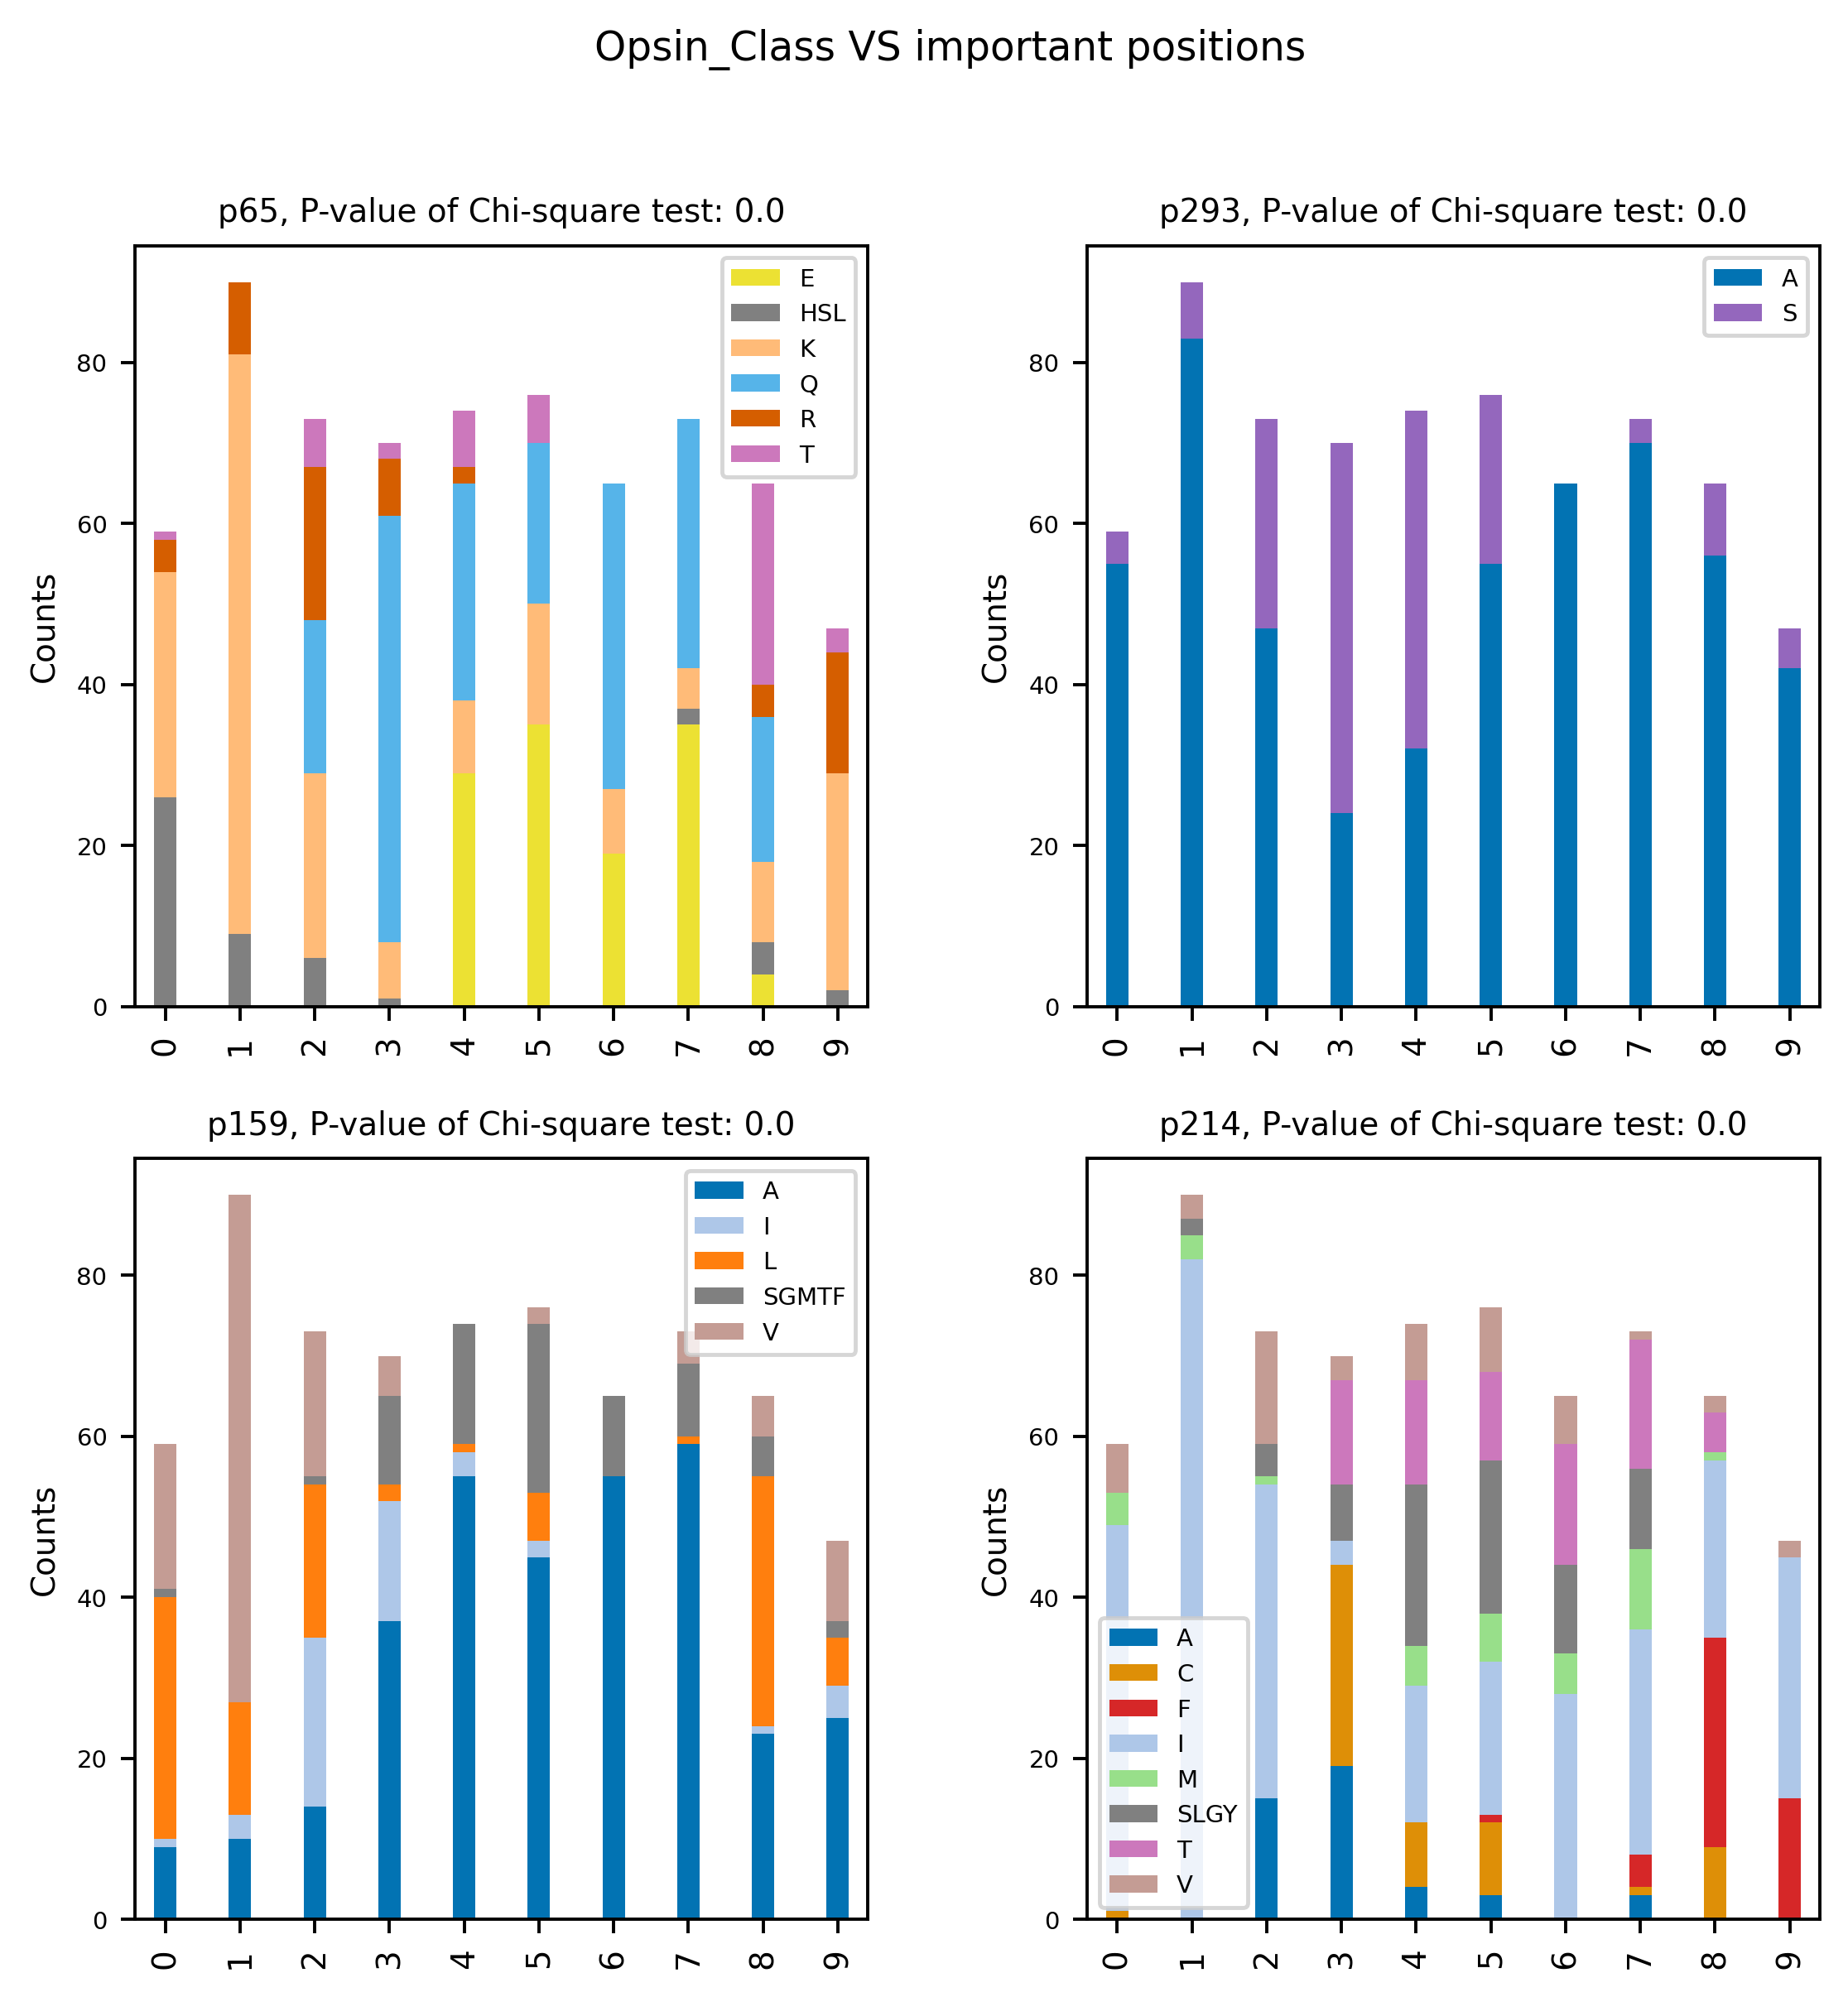

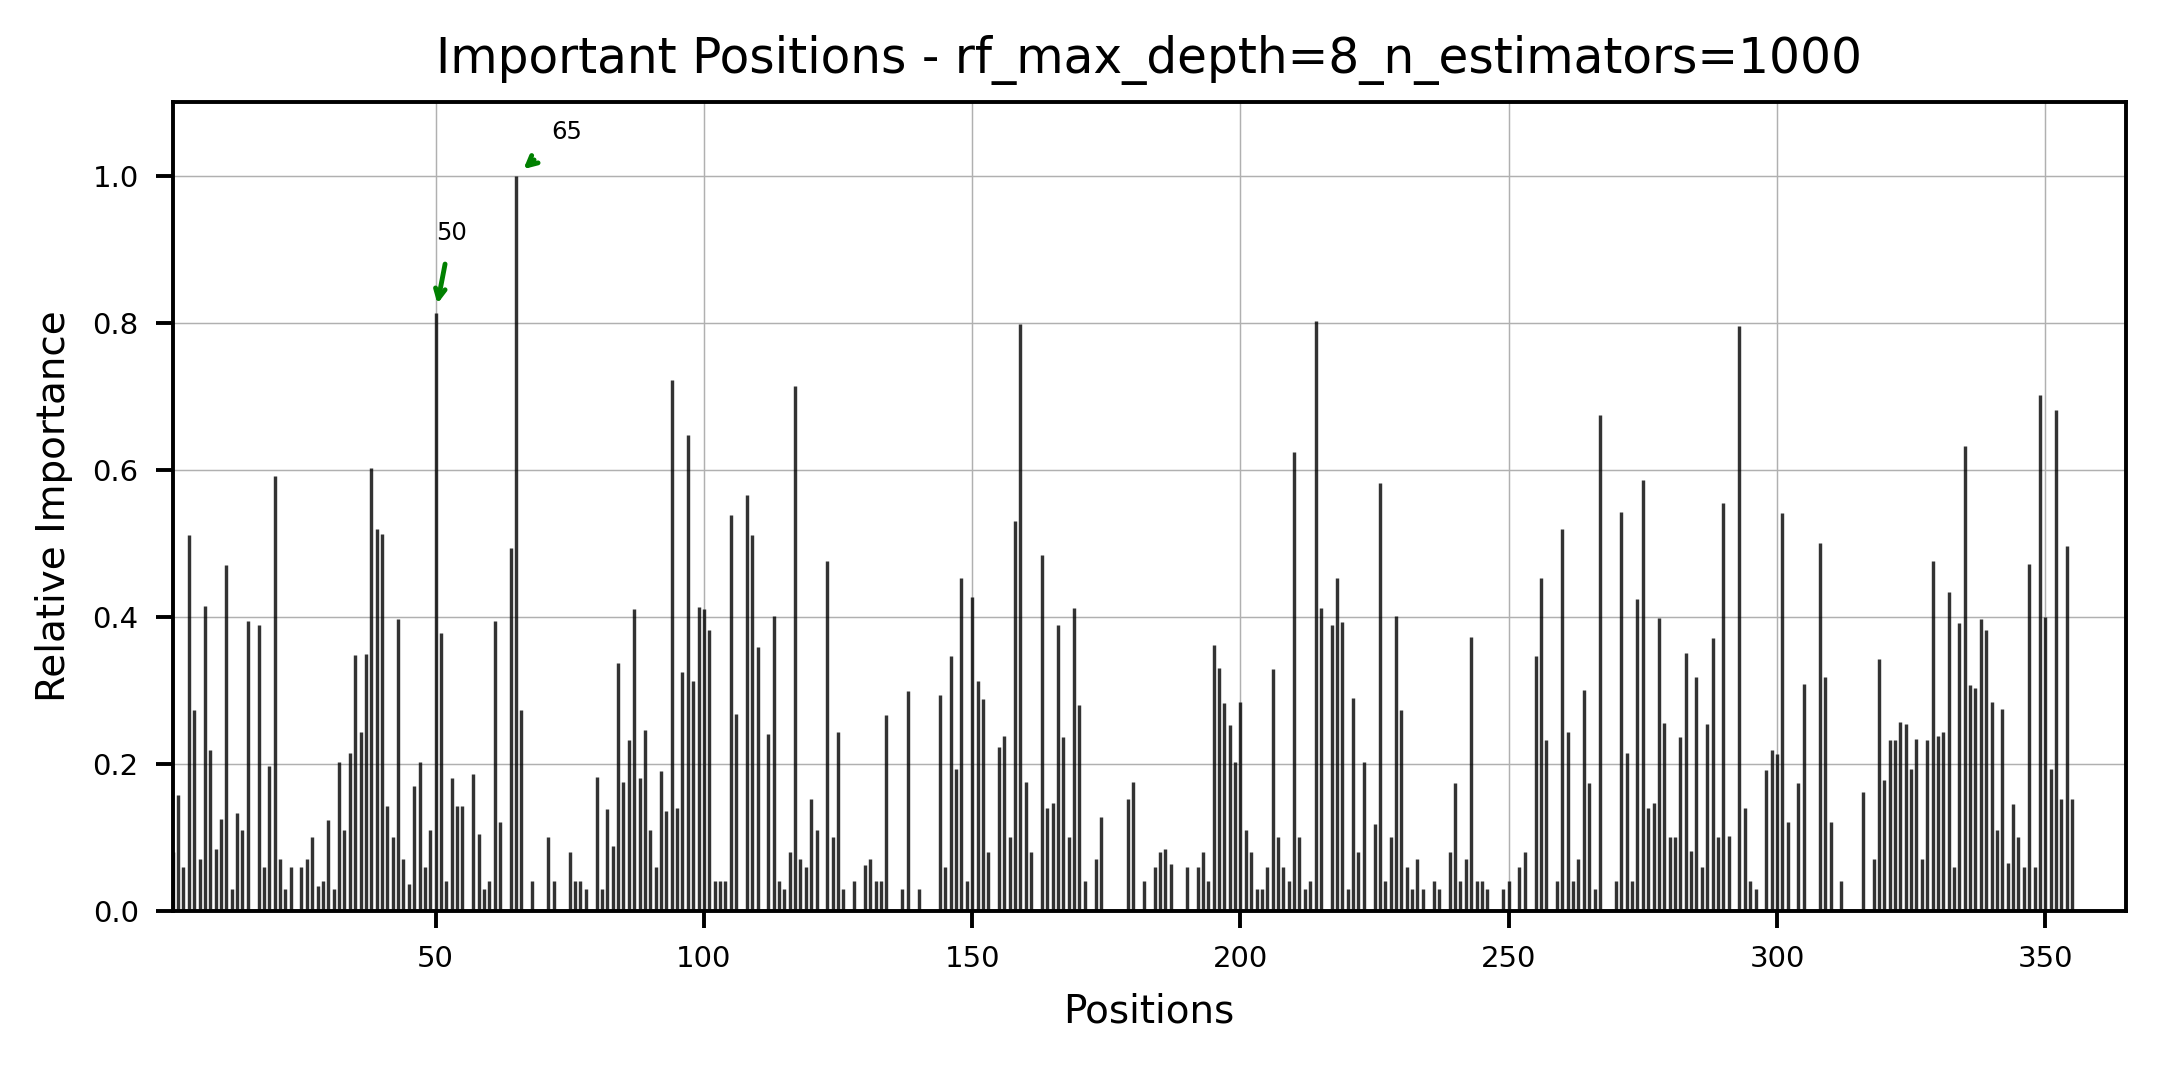

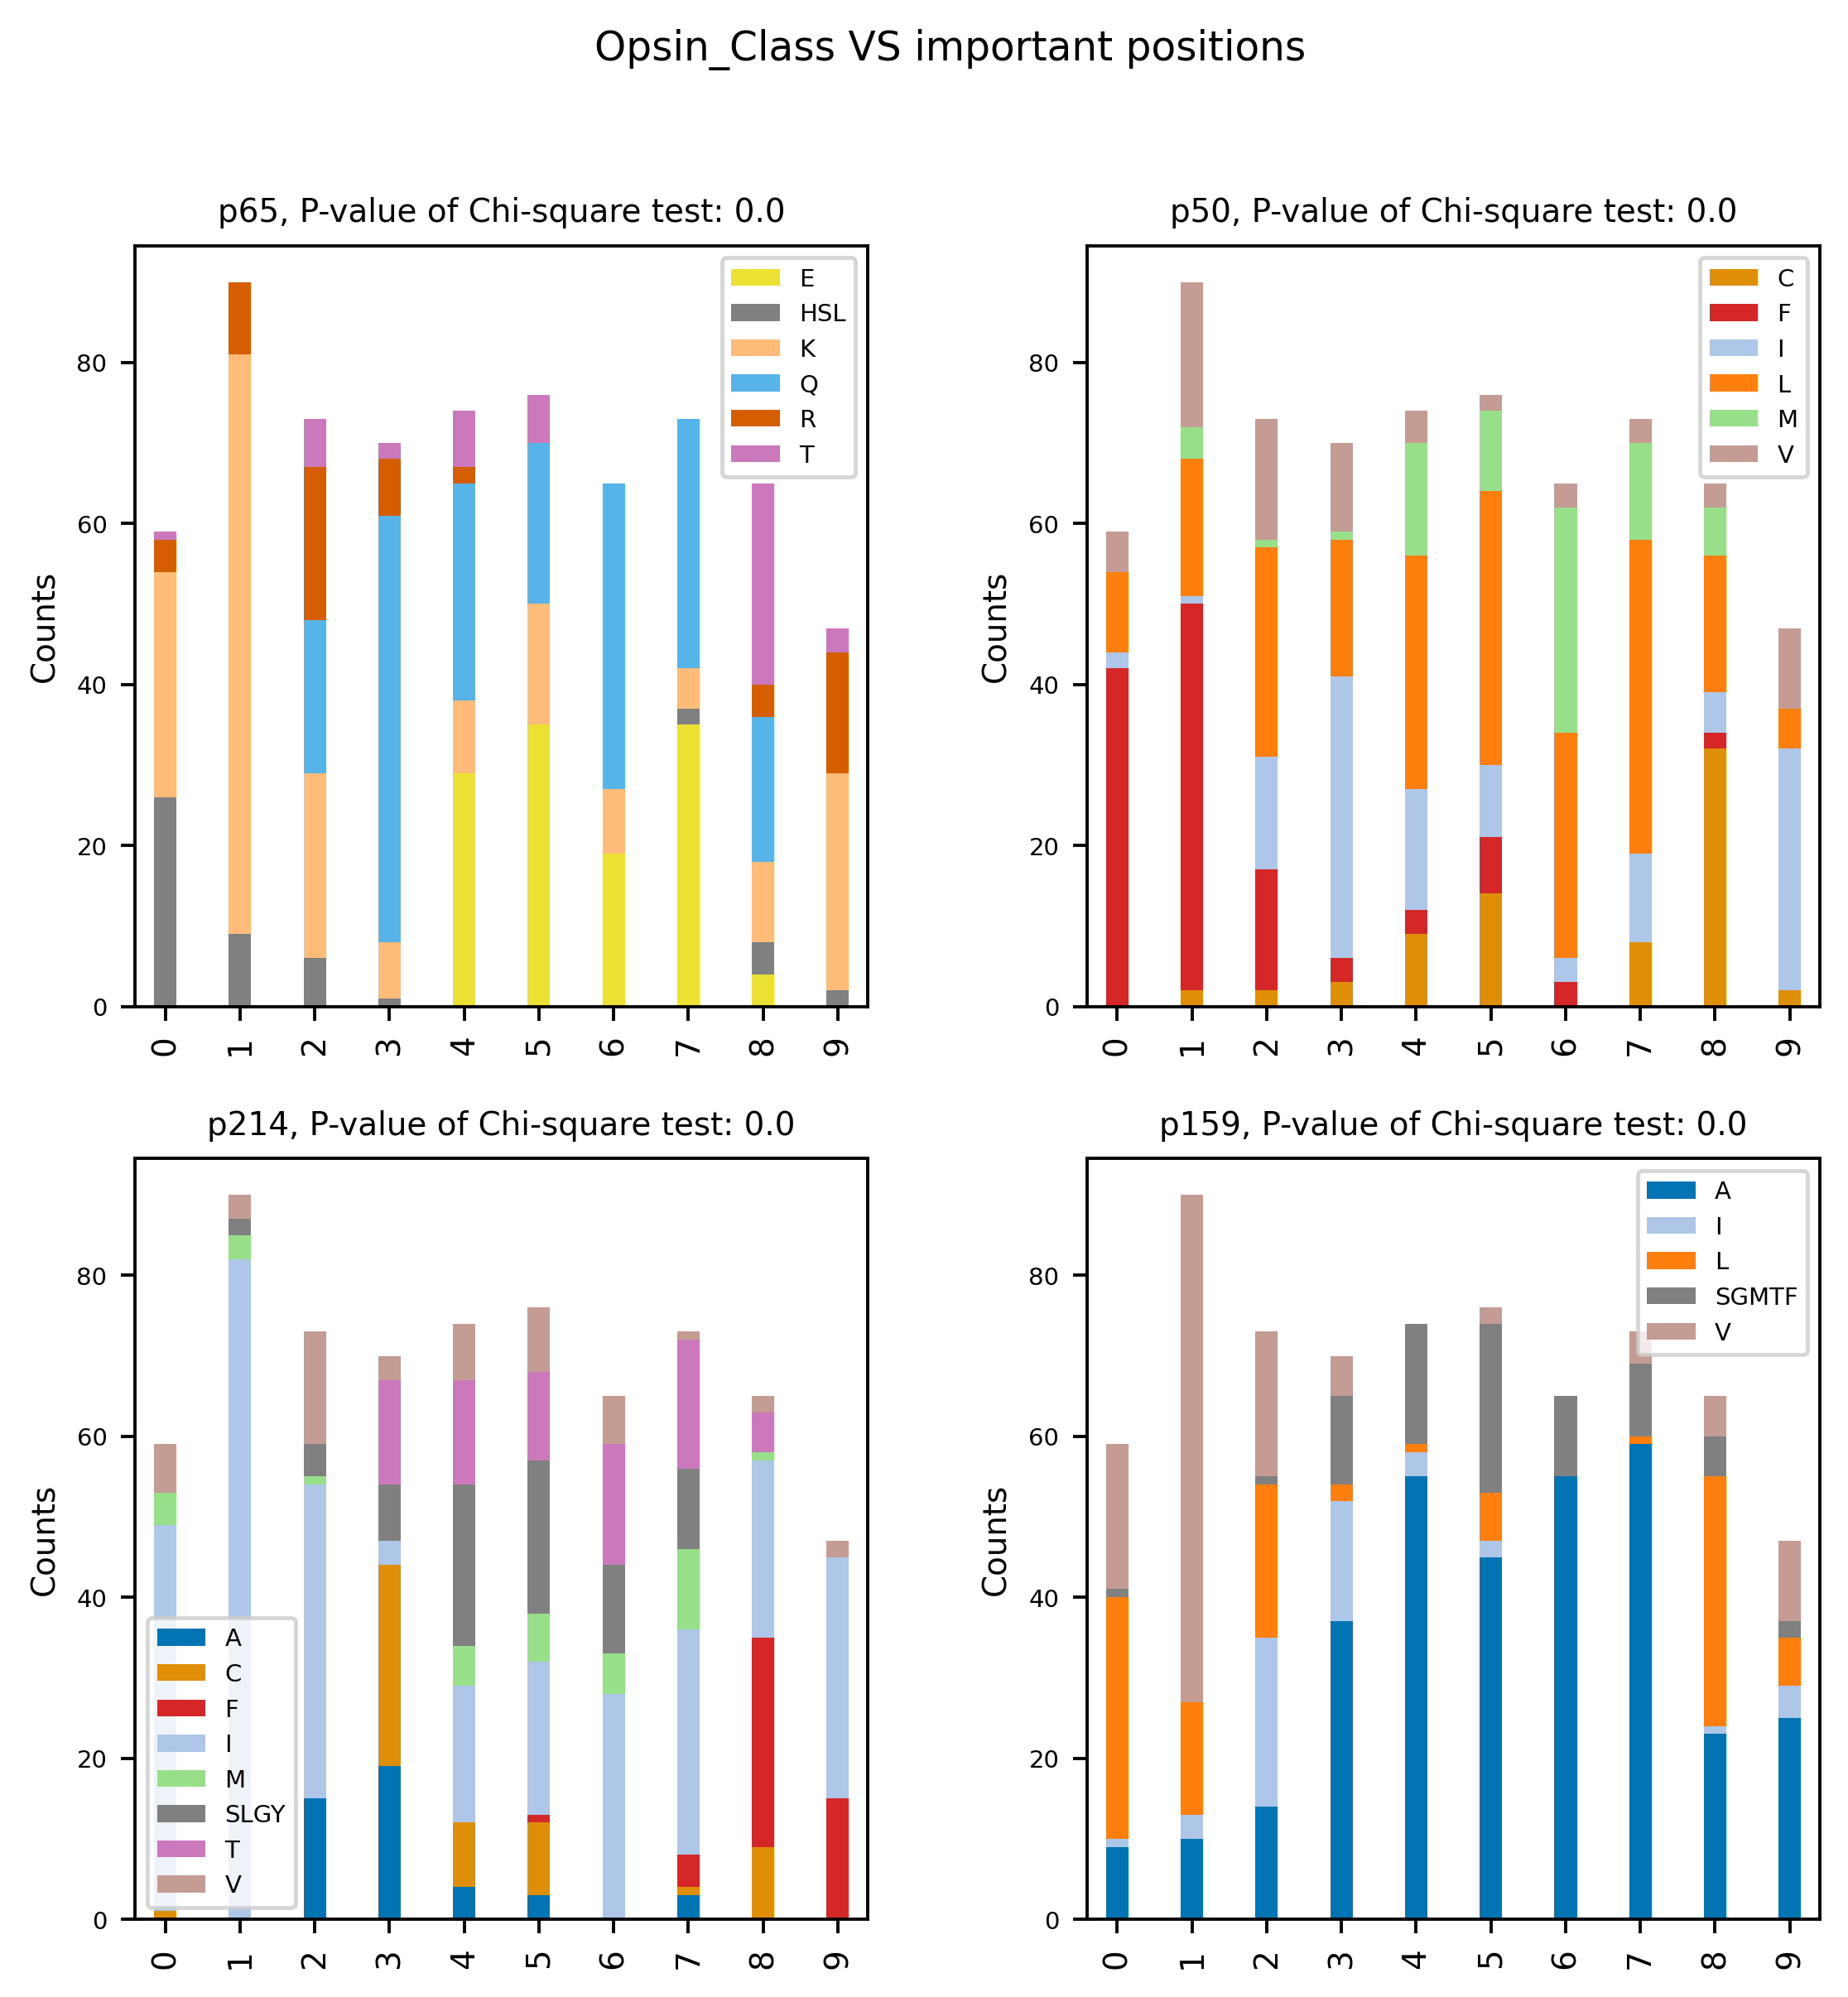

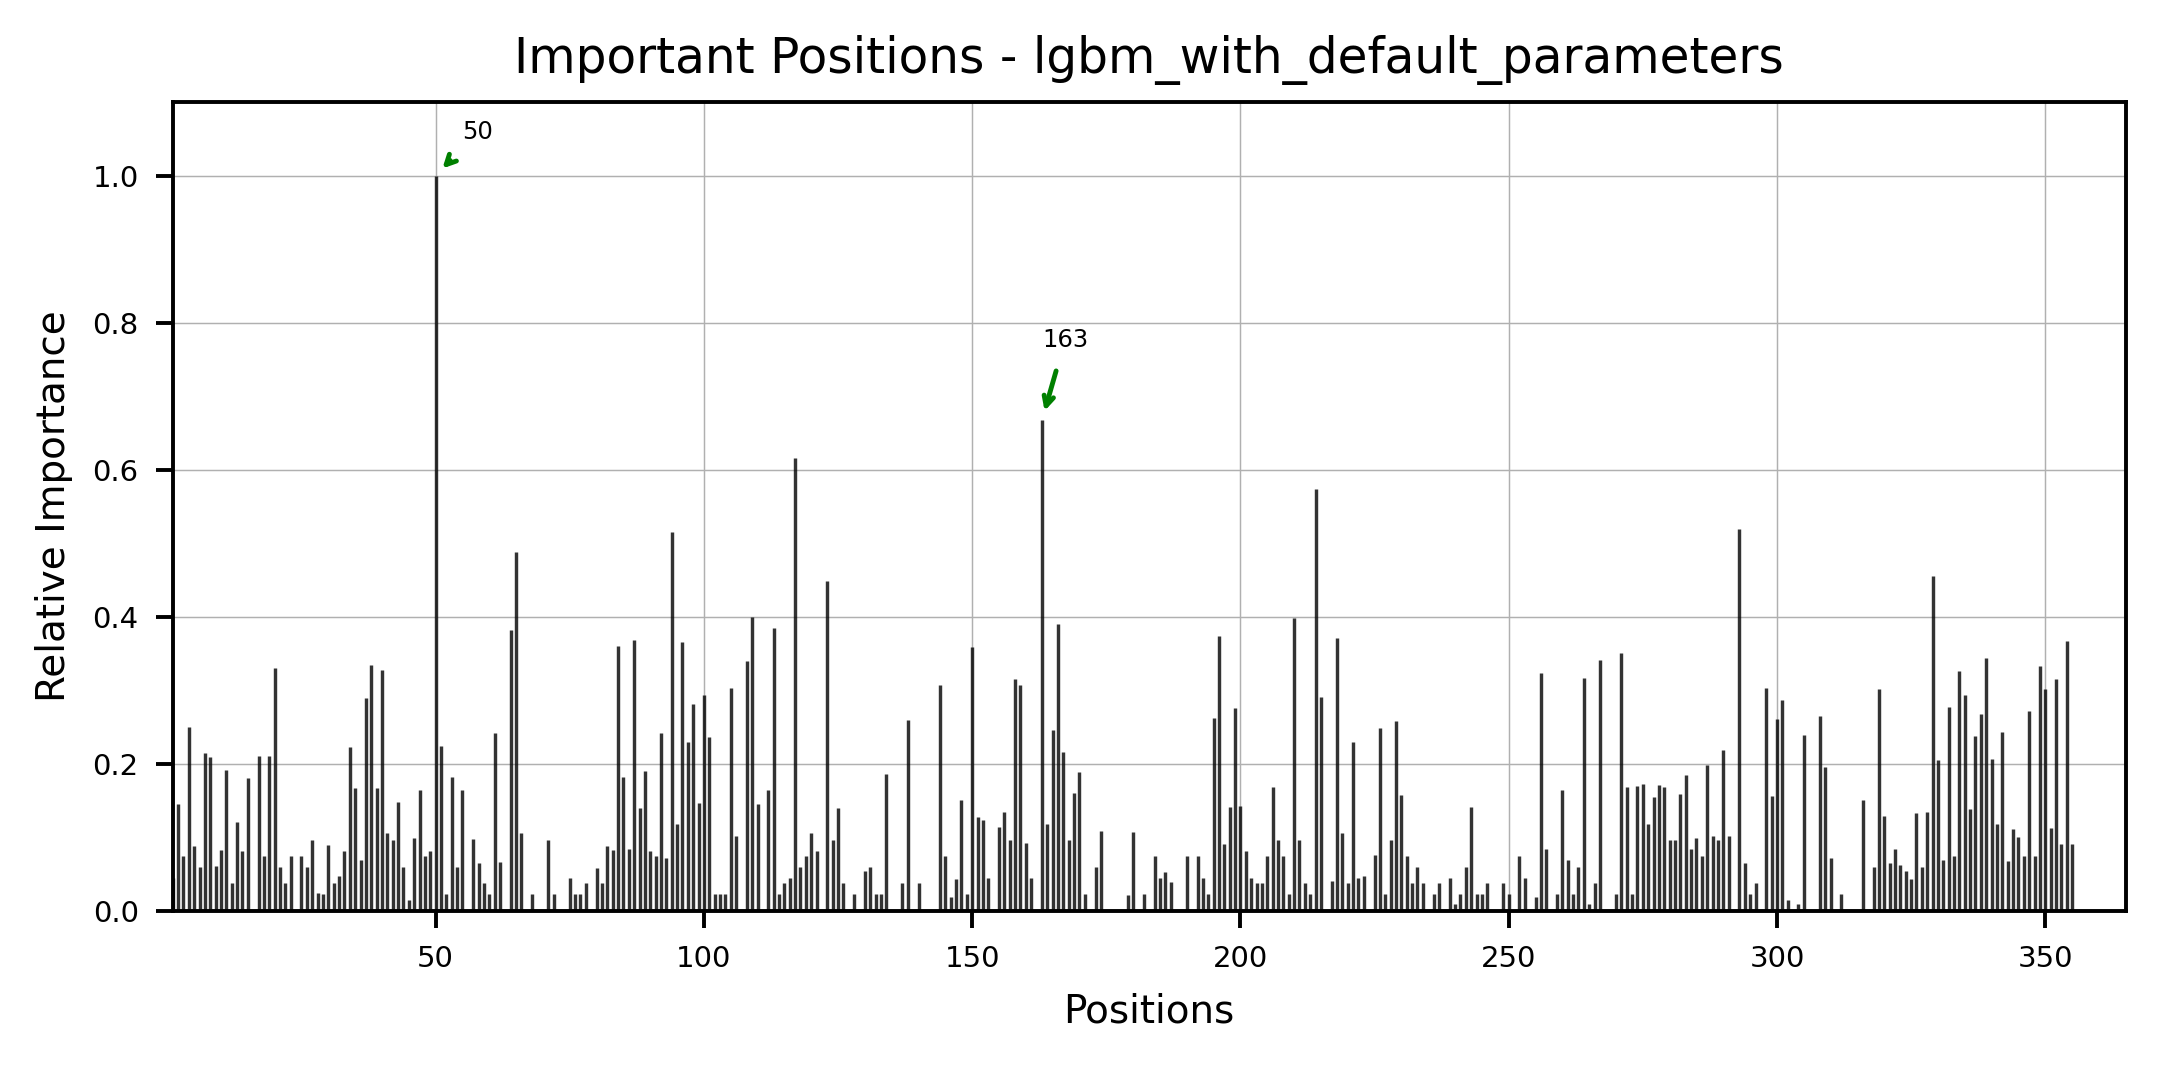

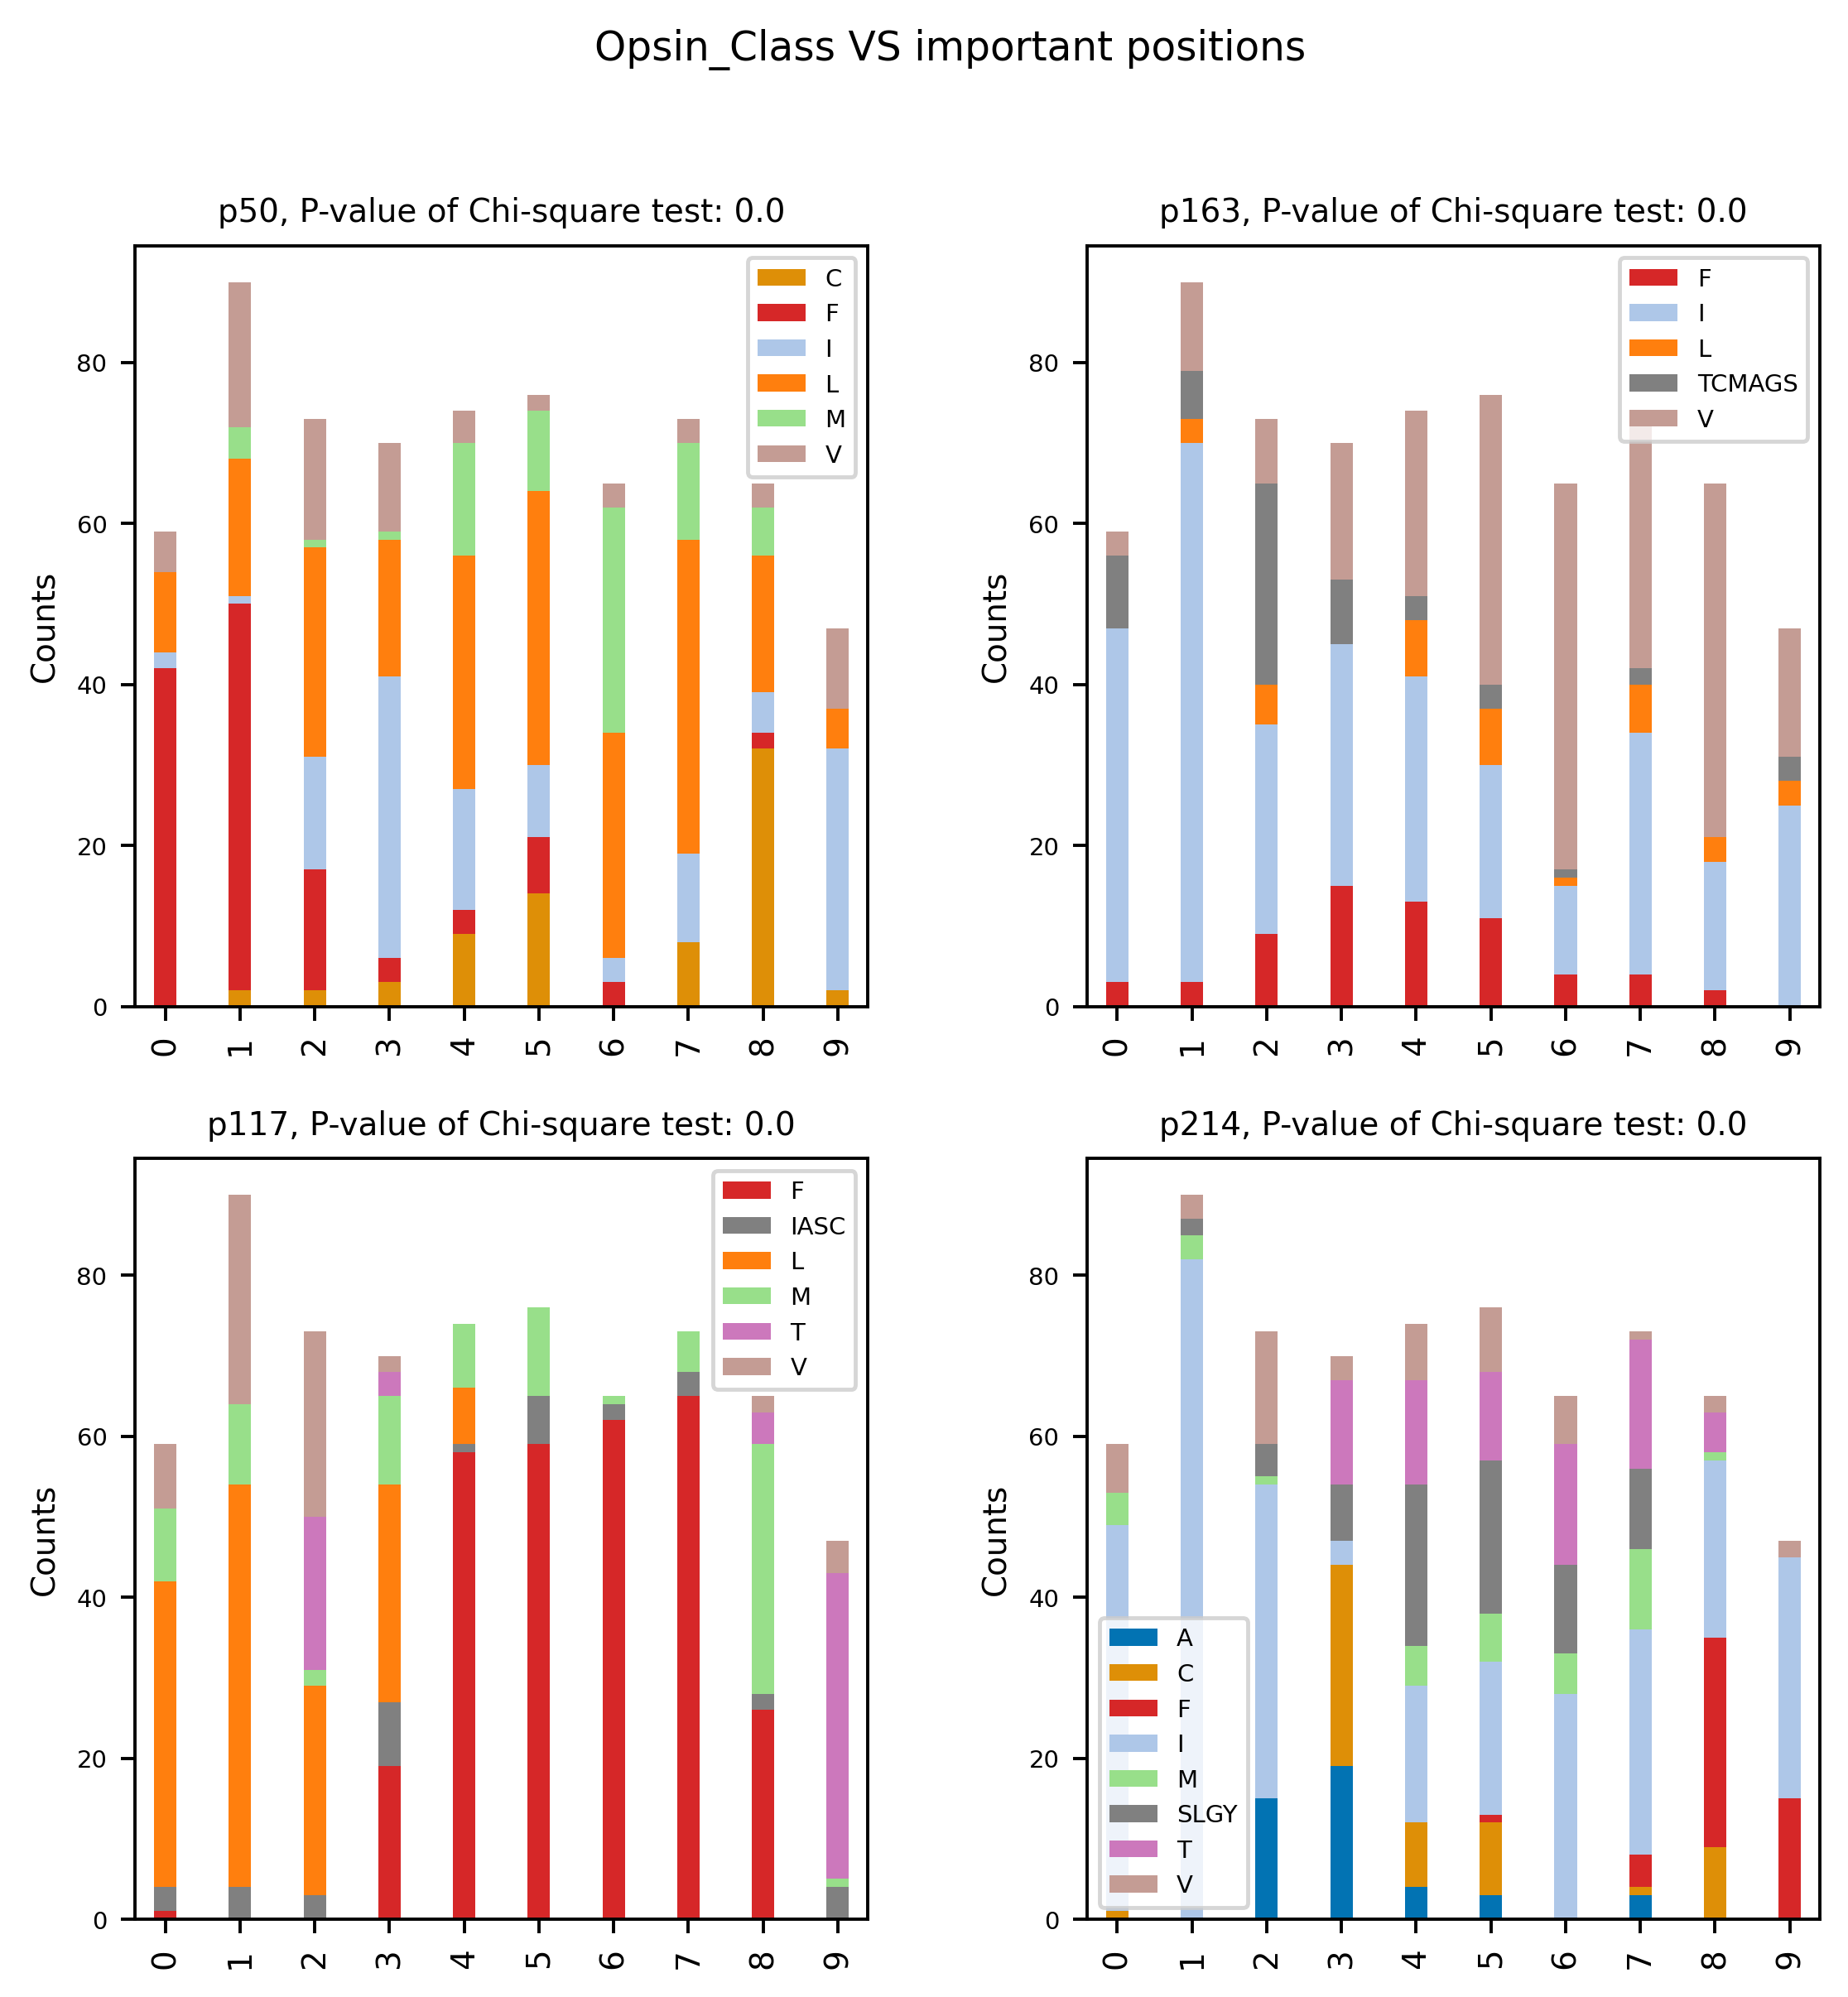

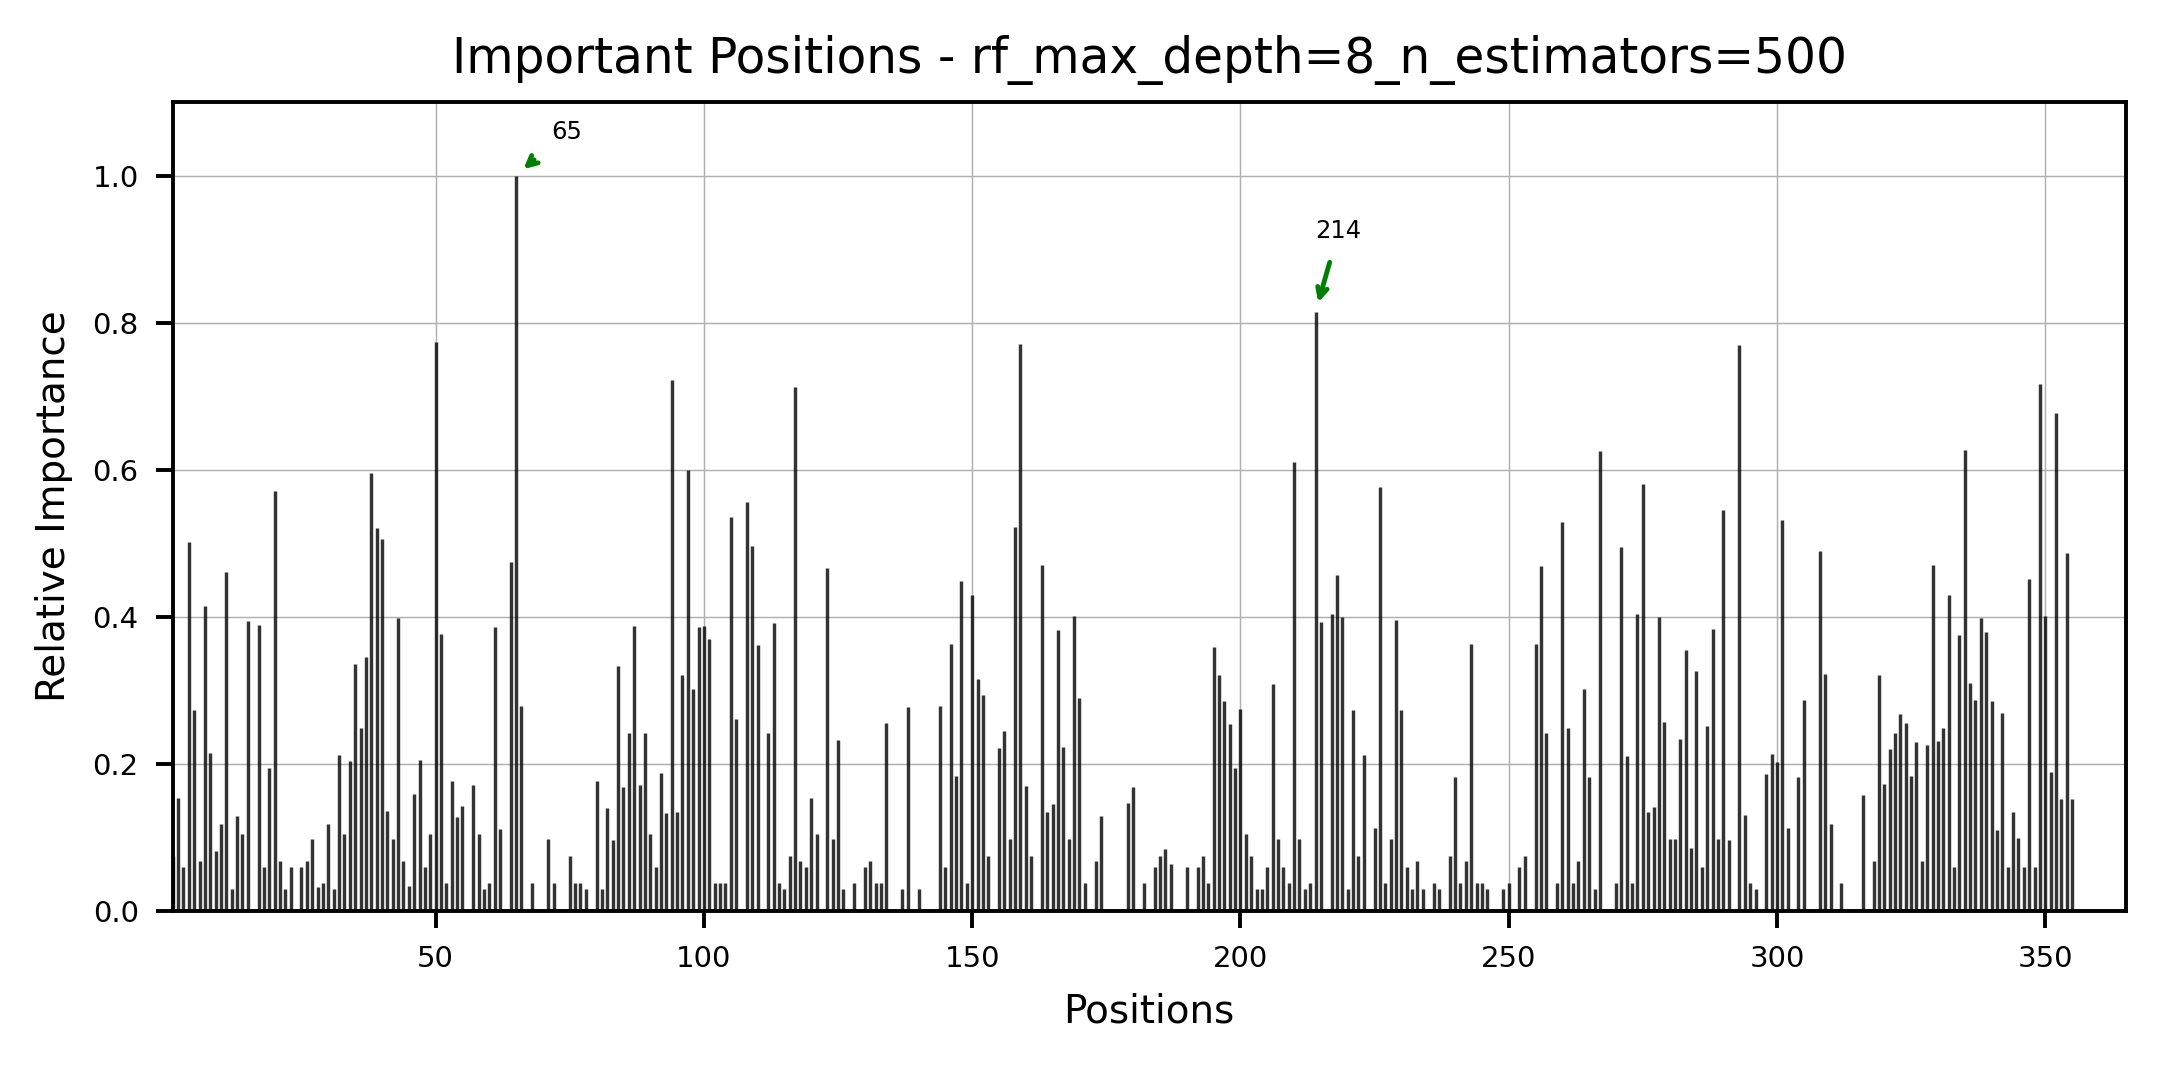

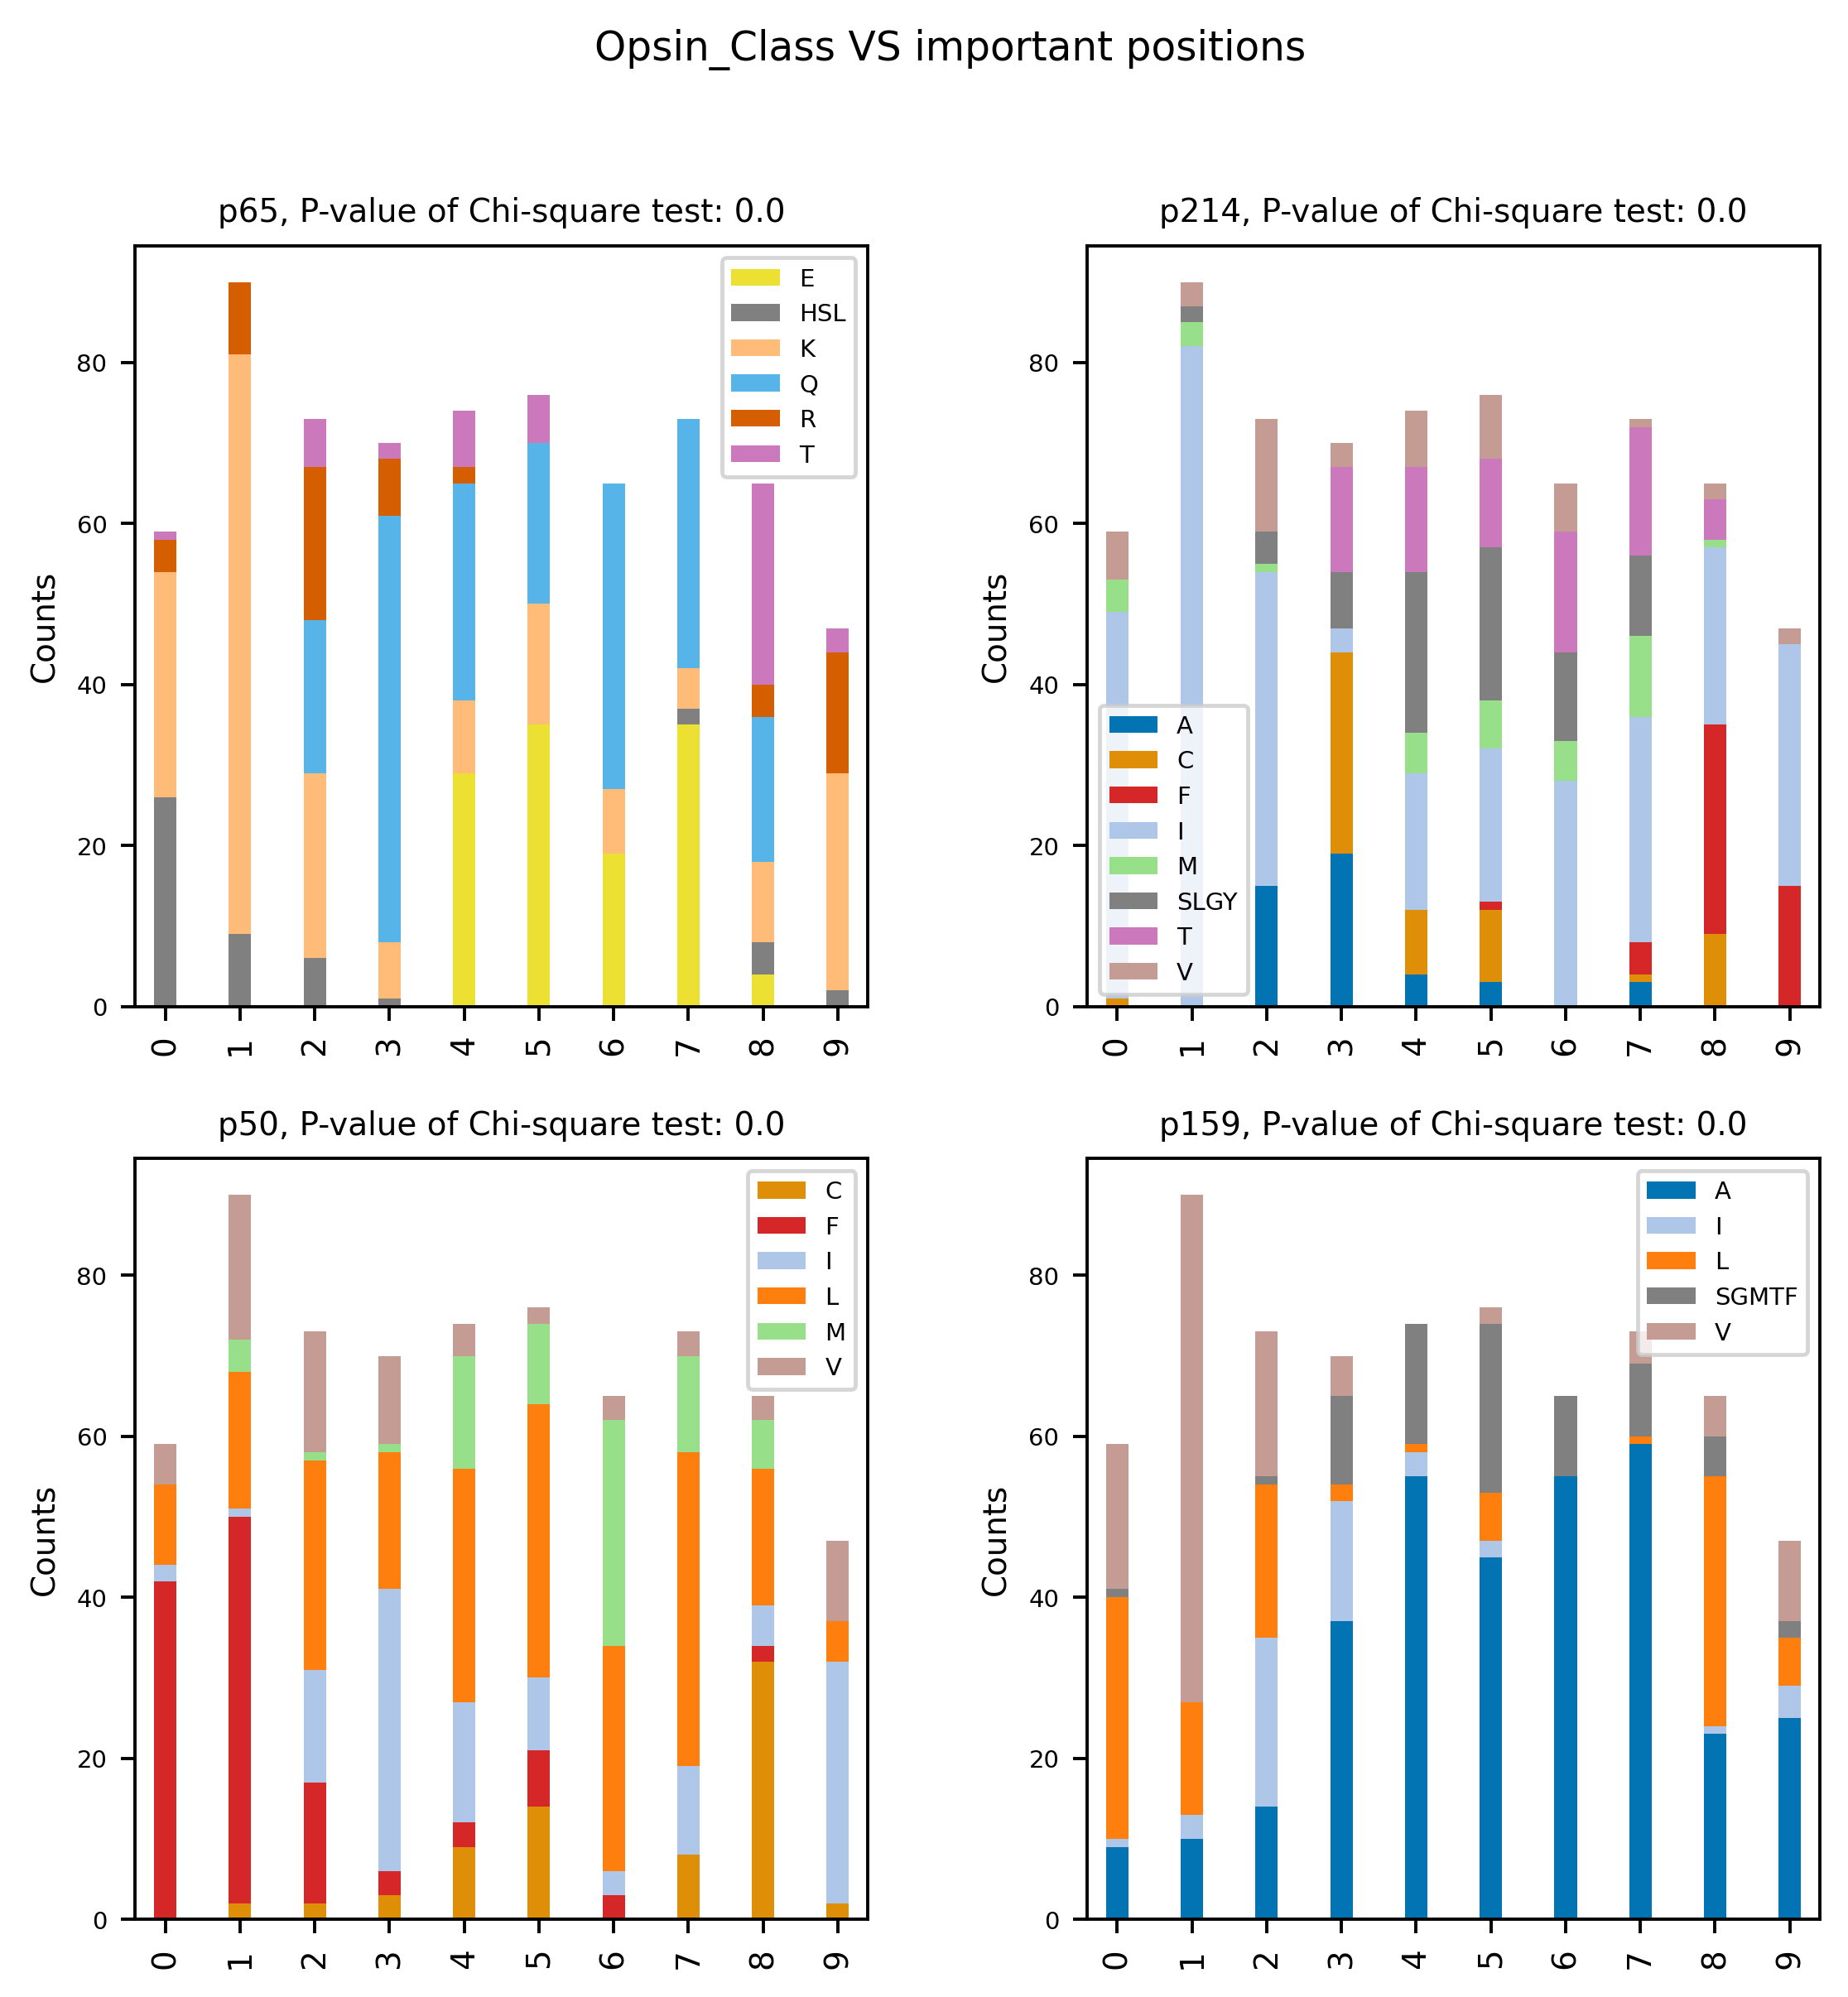

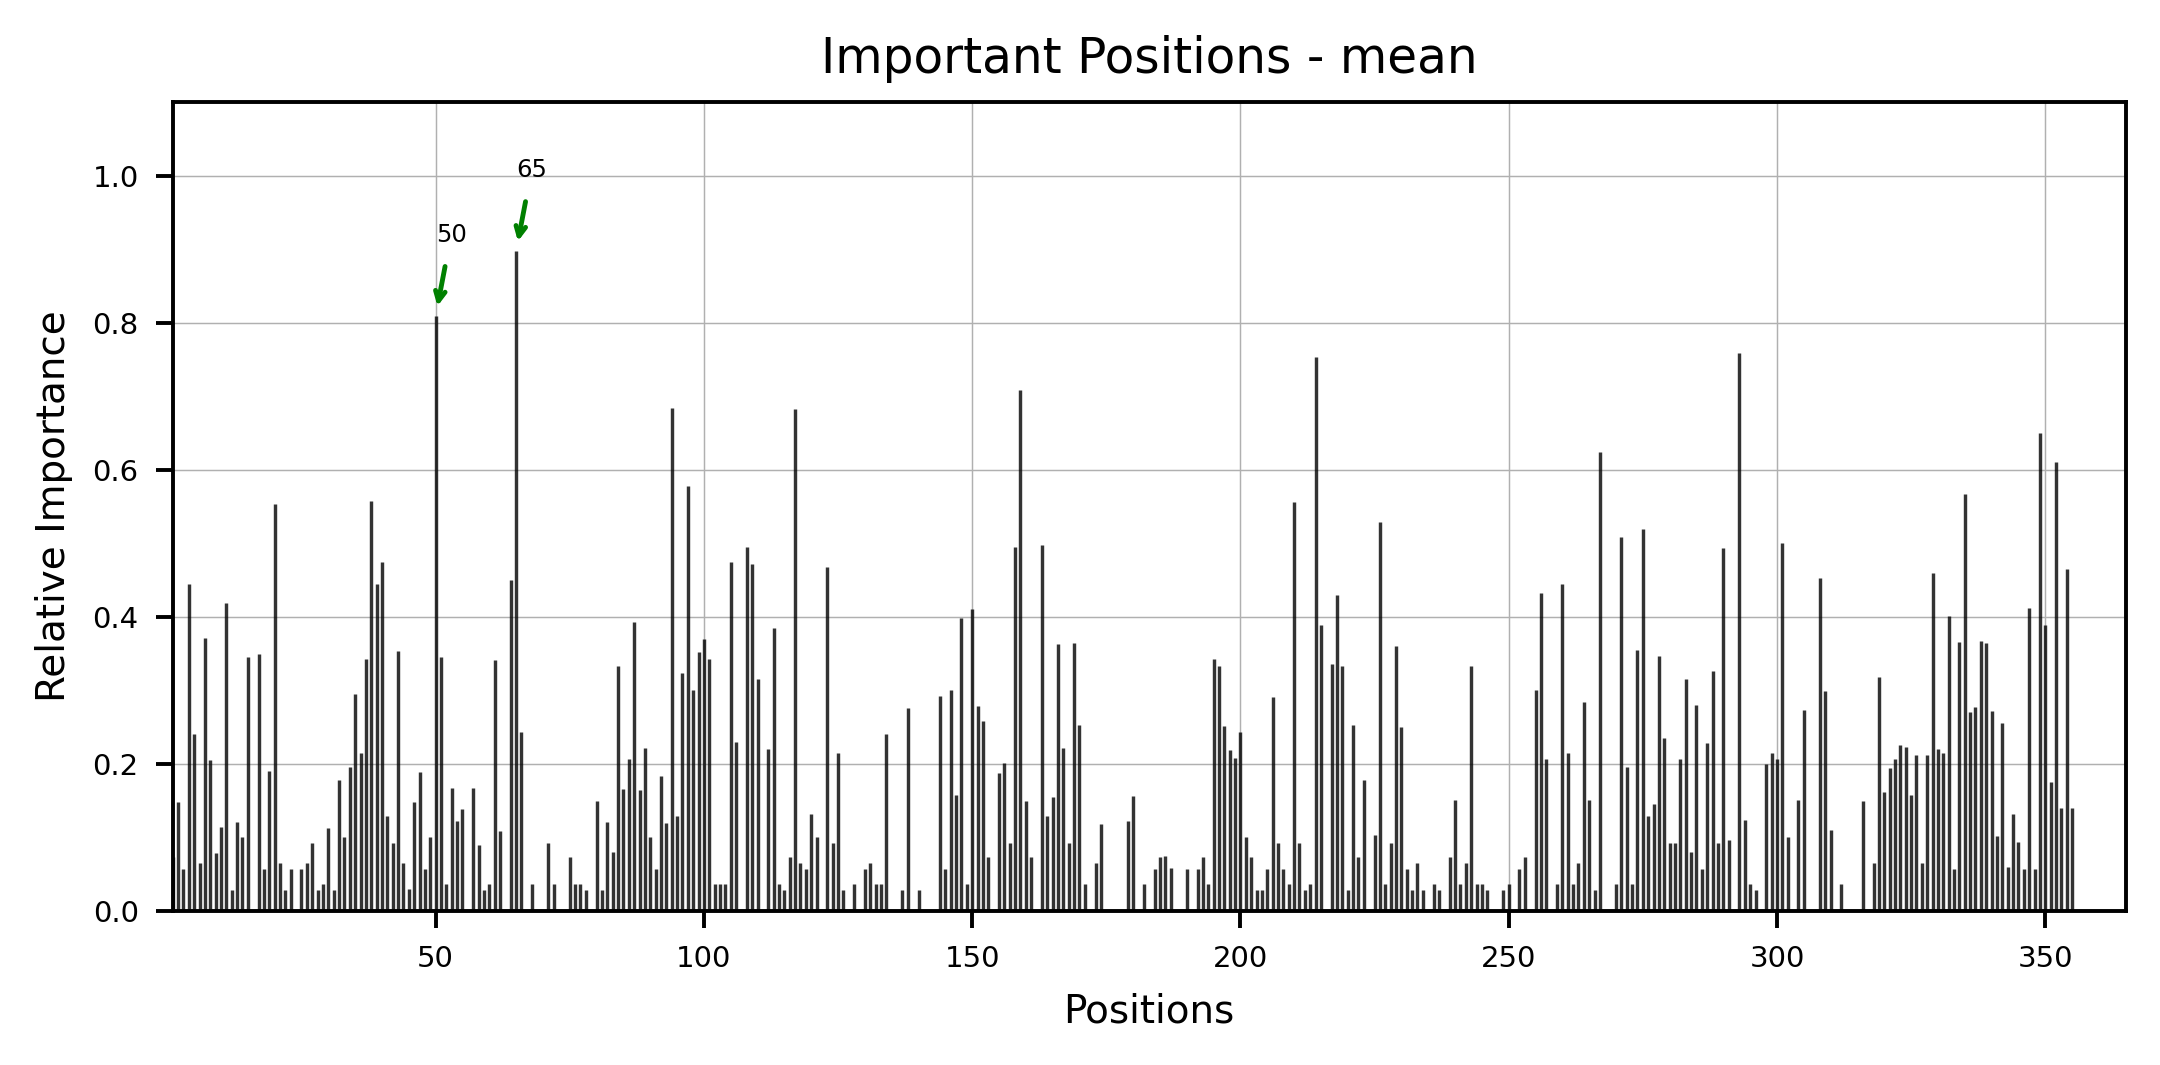

In [130]:
for key in trained_models.keys():
    if key == 'mean':
        # plot the mean importance
        viz.dp_plot(importance=trained_models[key], imp_col='mean', model_name=key, annotate=2, report_dir=report_dir)
    else:
        # importance plot (barplot)
        viz.dp_plot(importance= trained_models[key]['importance'], imp_col='standard_value', 
                model_name=key, annotate=2,report_dir=report_dir)
        # top 4 position from each model
        viz.plot_imp_model(importance=trained_models[key]['importance'],
                           X_train=df.loc[:, df.columns != mt],
                           y_train=df.loc[:, mt],
                           model_name=key, meta_var=mt, model_type=anaType,
                           report_dir=report_dir)

<span style="color:red">**Running the next cell will produce individual plots for all of the positions in you sequence.**</span>

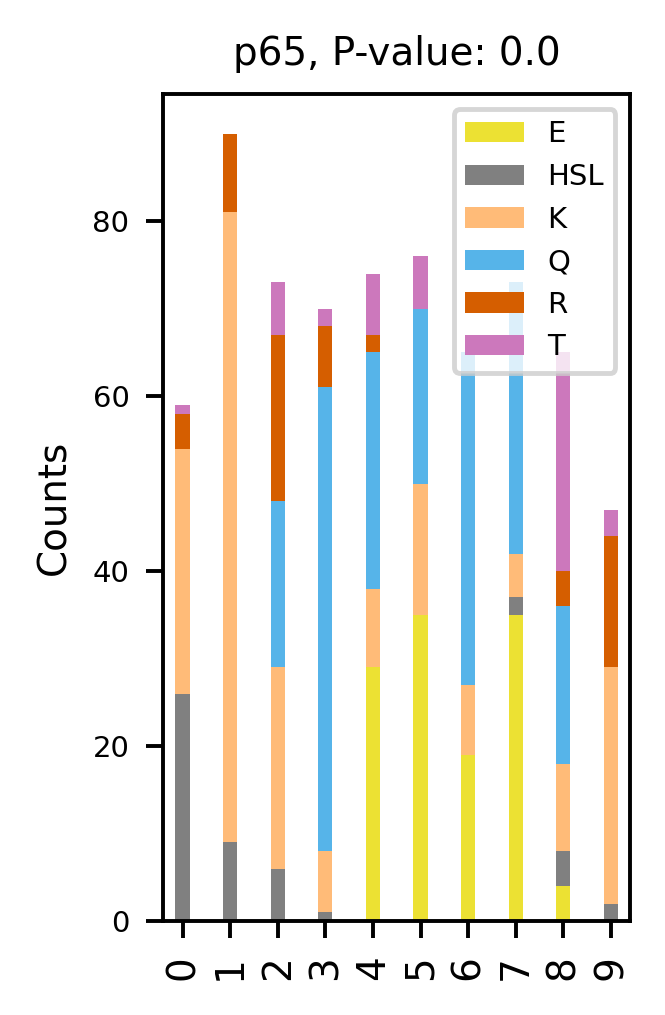

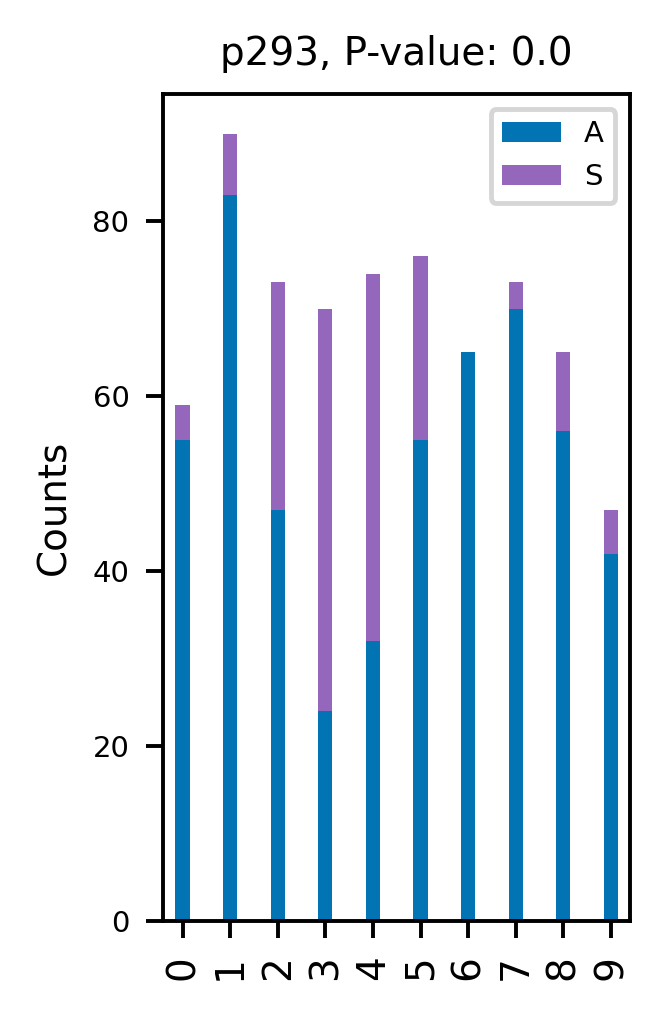

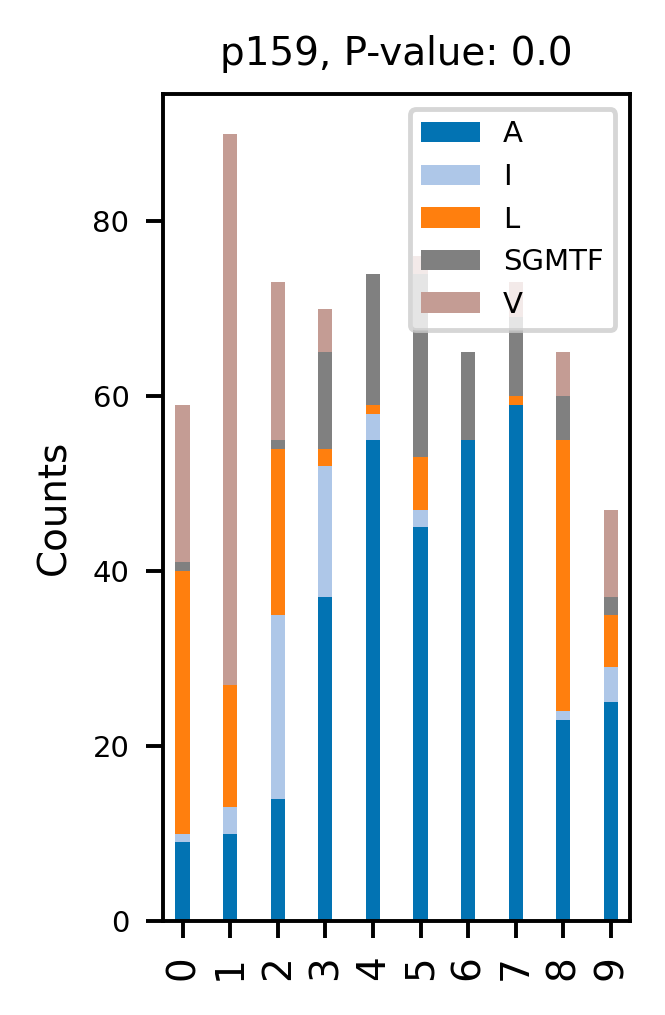

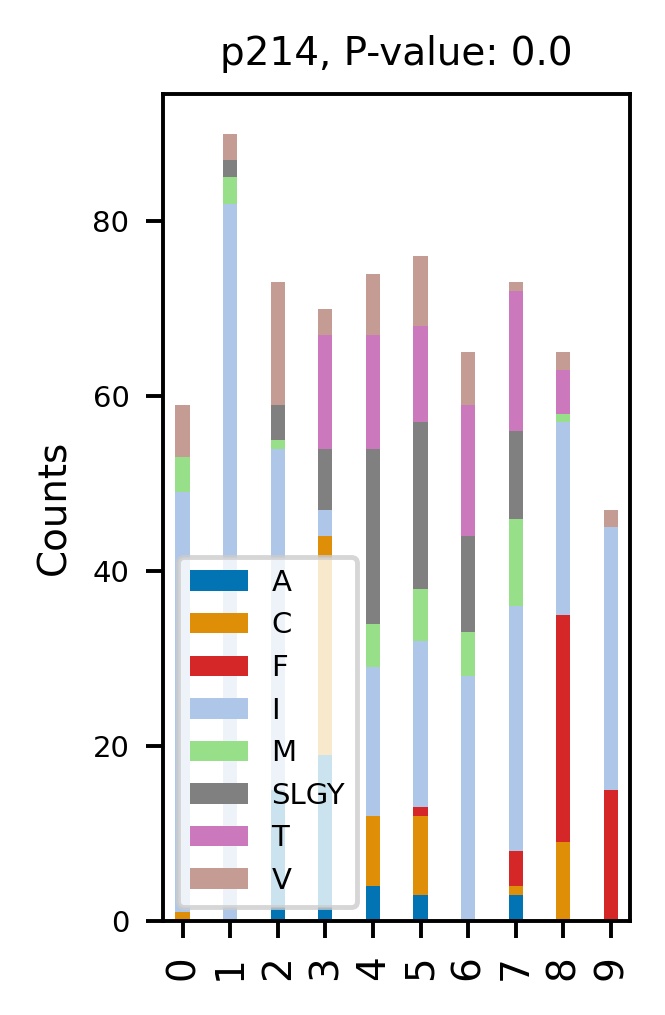

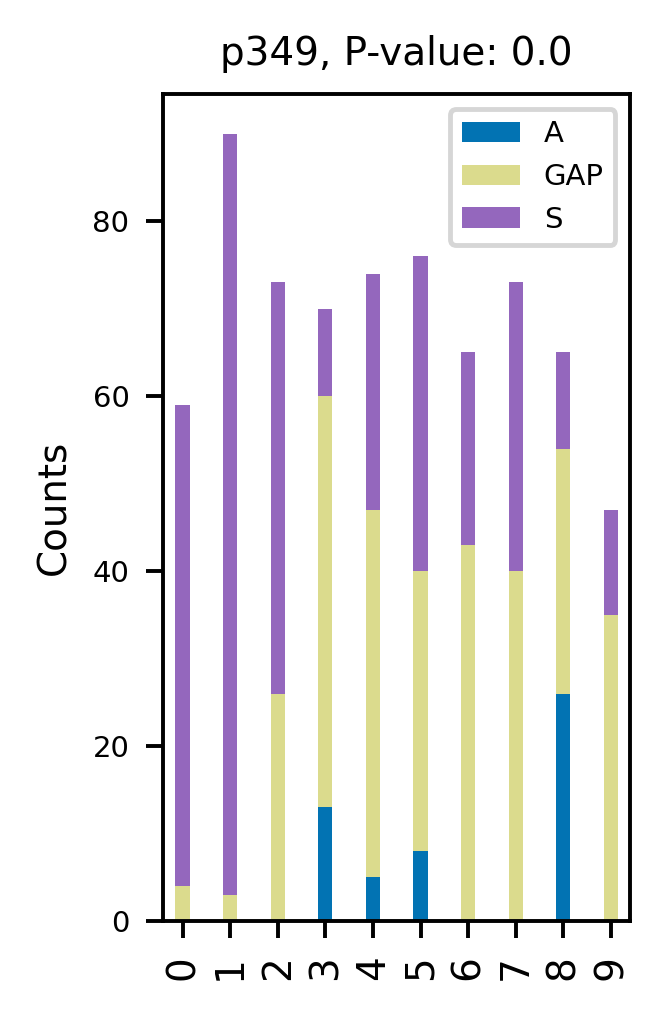

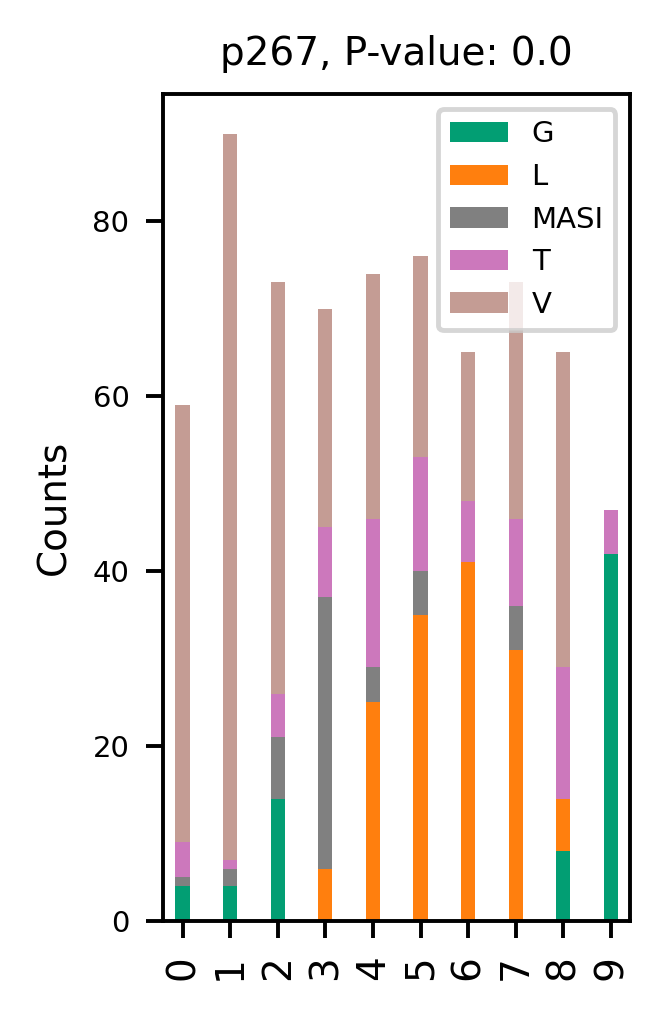

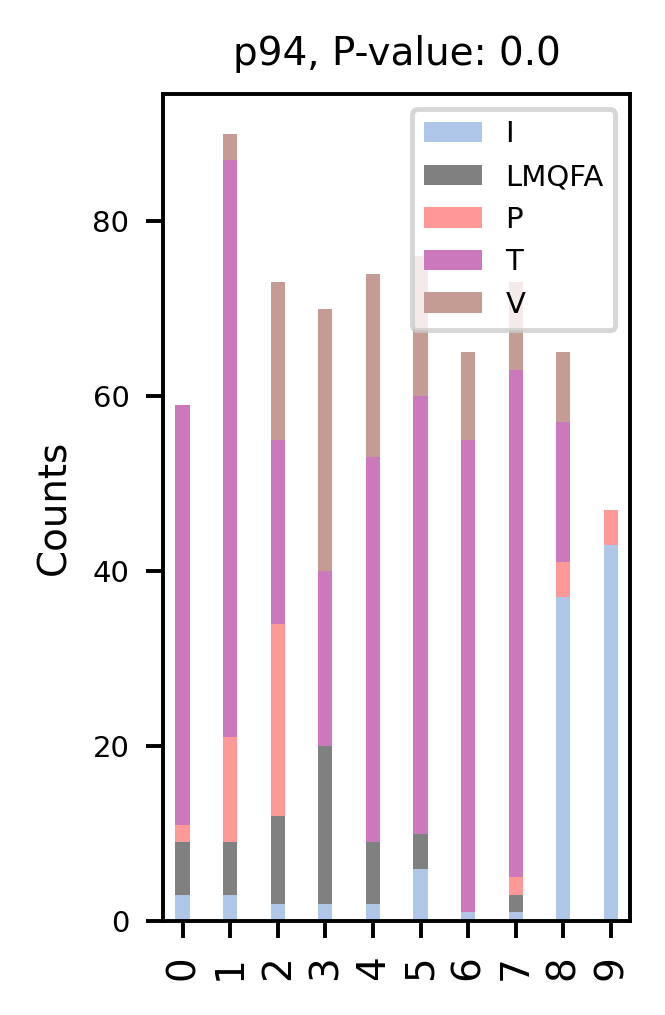

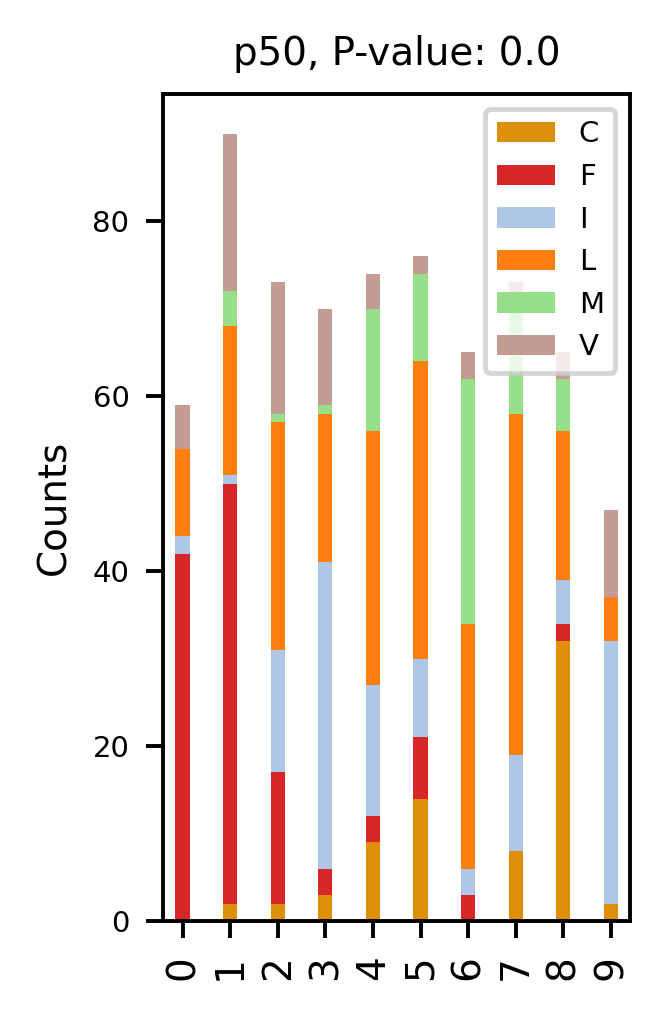

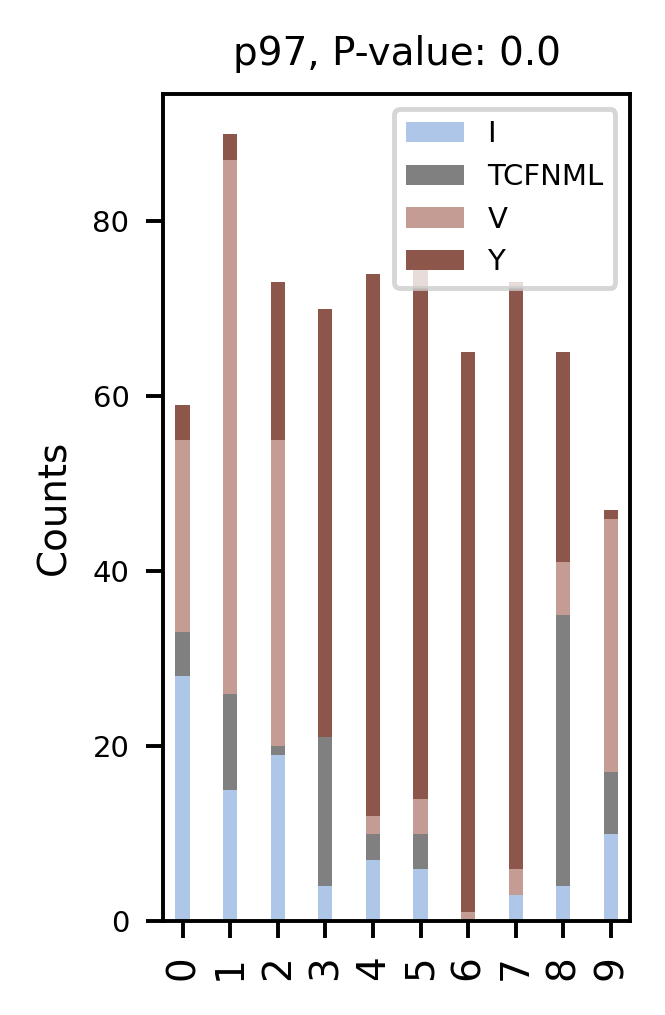

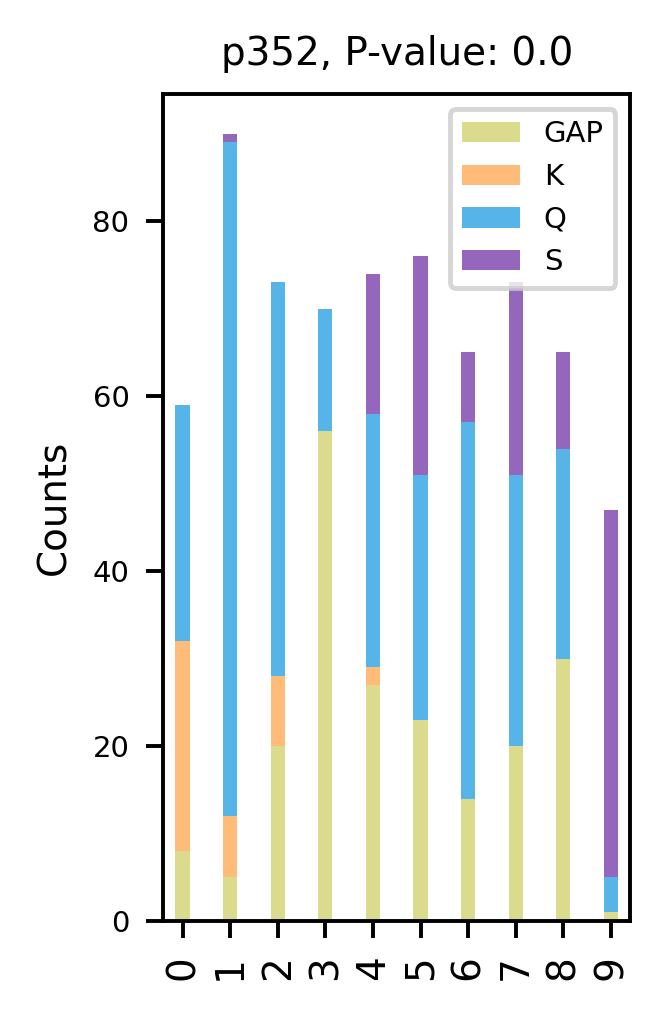

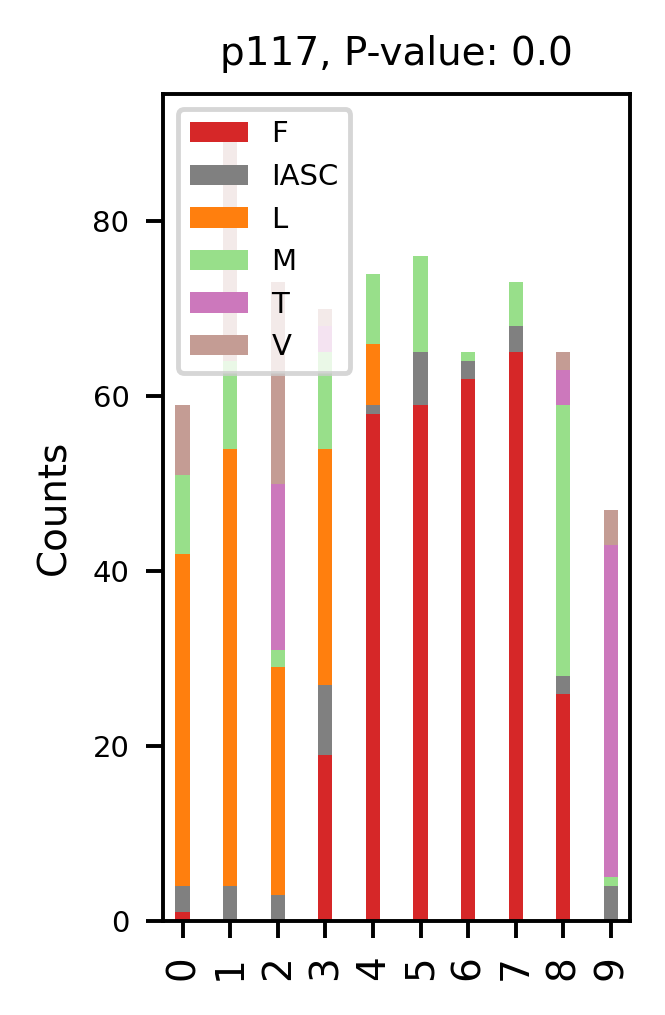

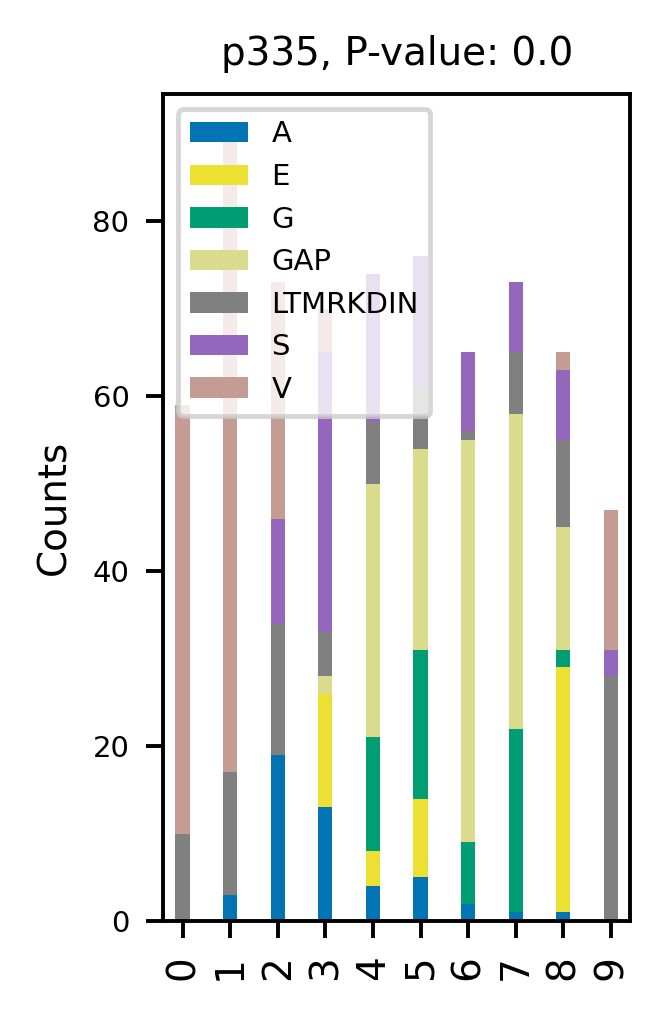

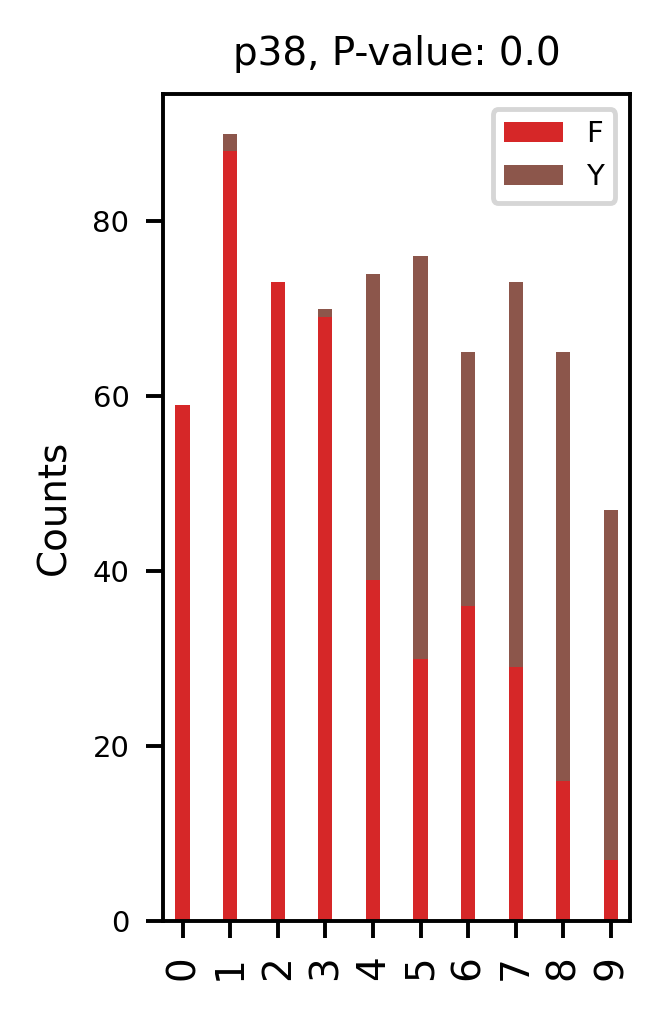

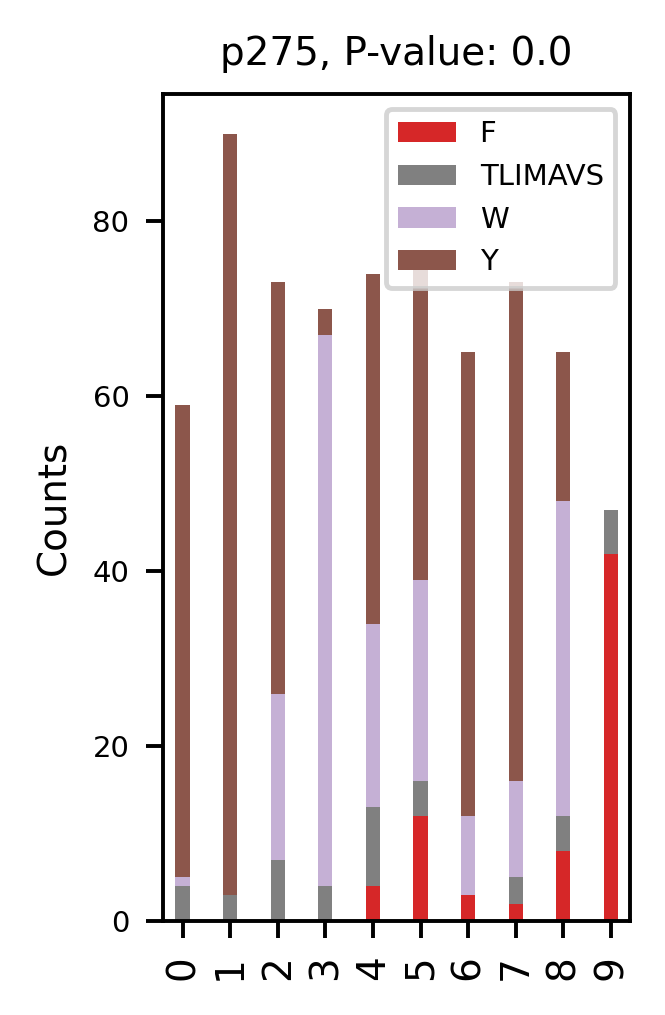

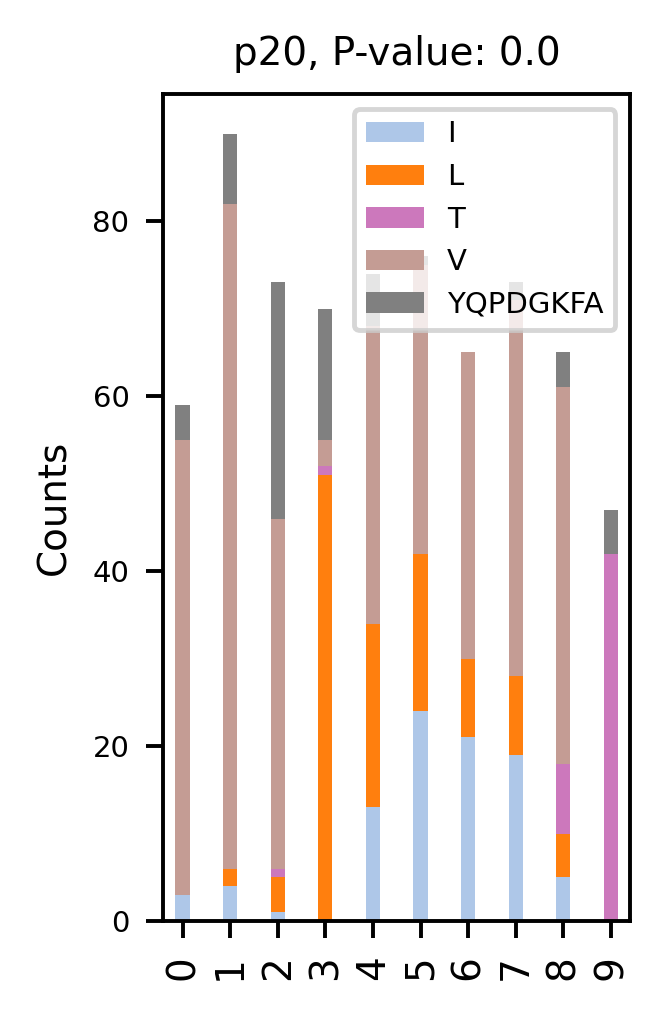

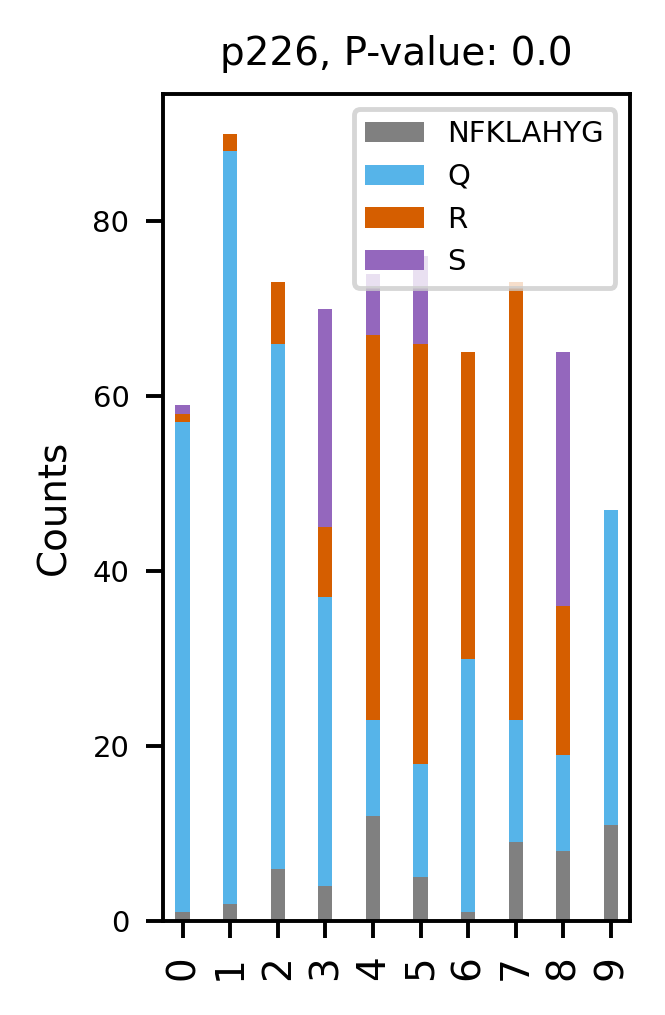

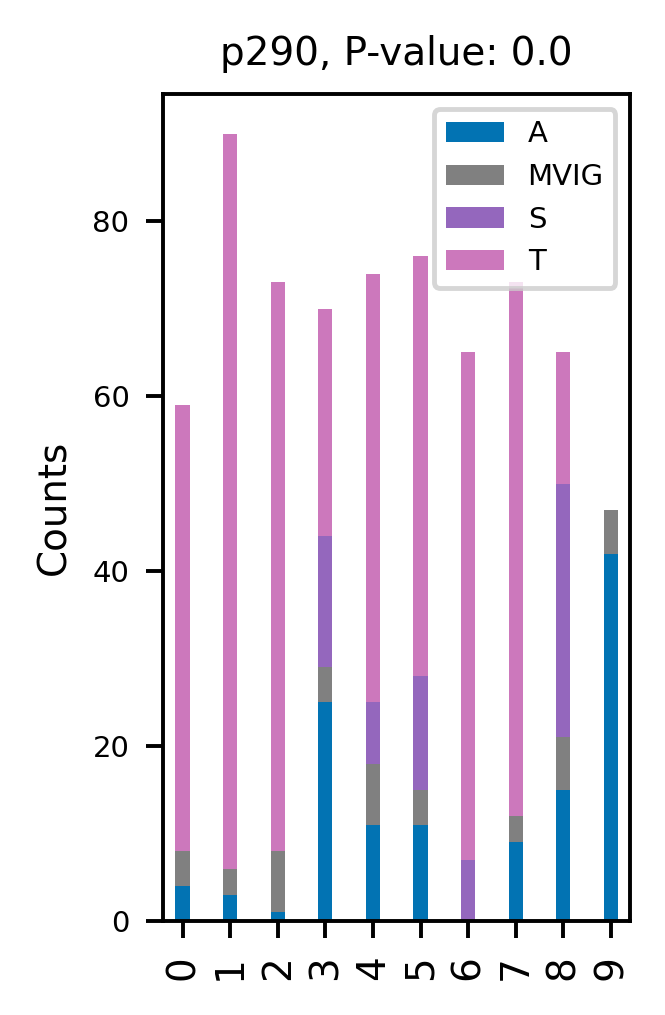

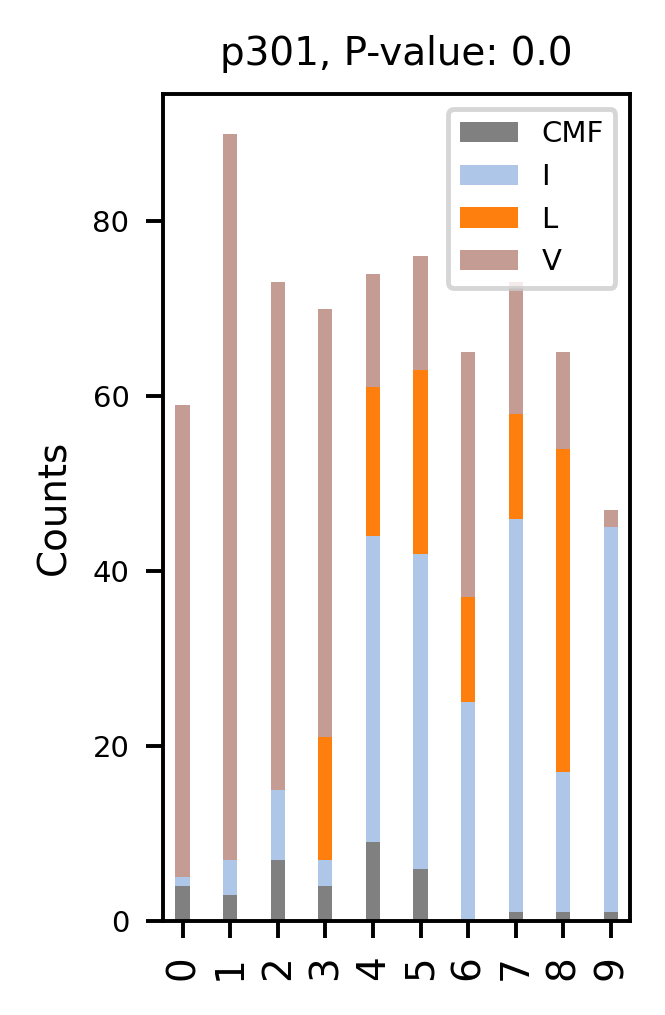

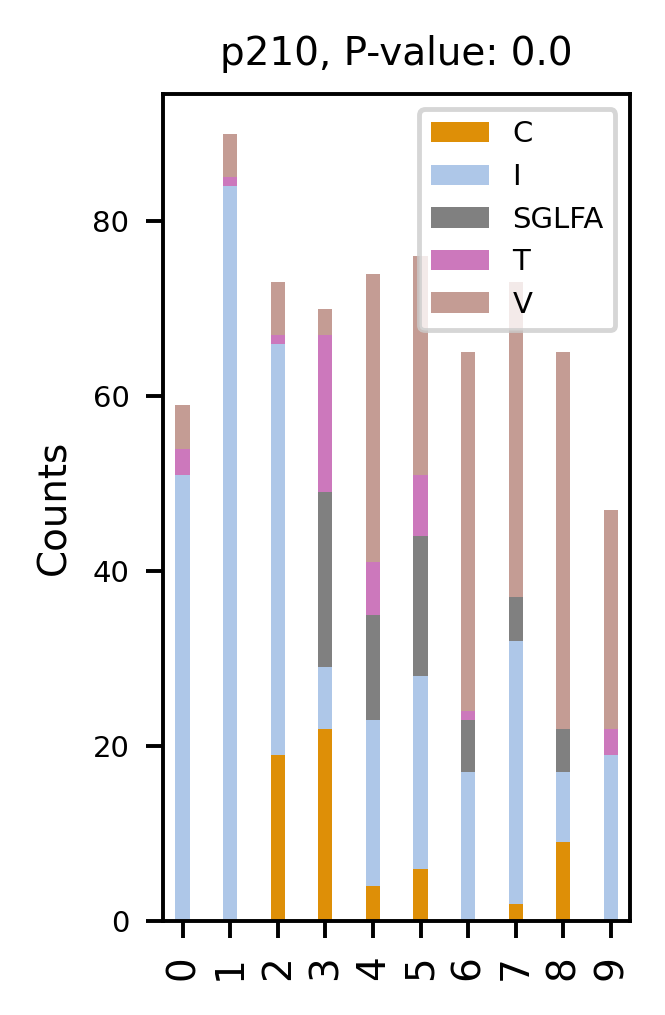

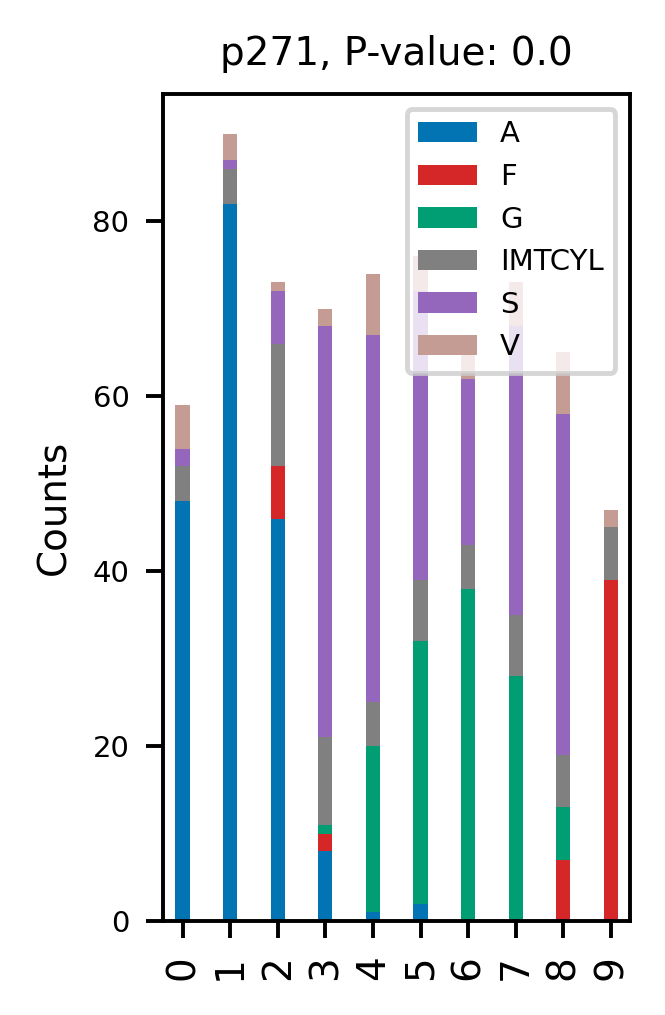

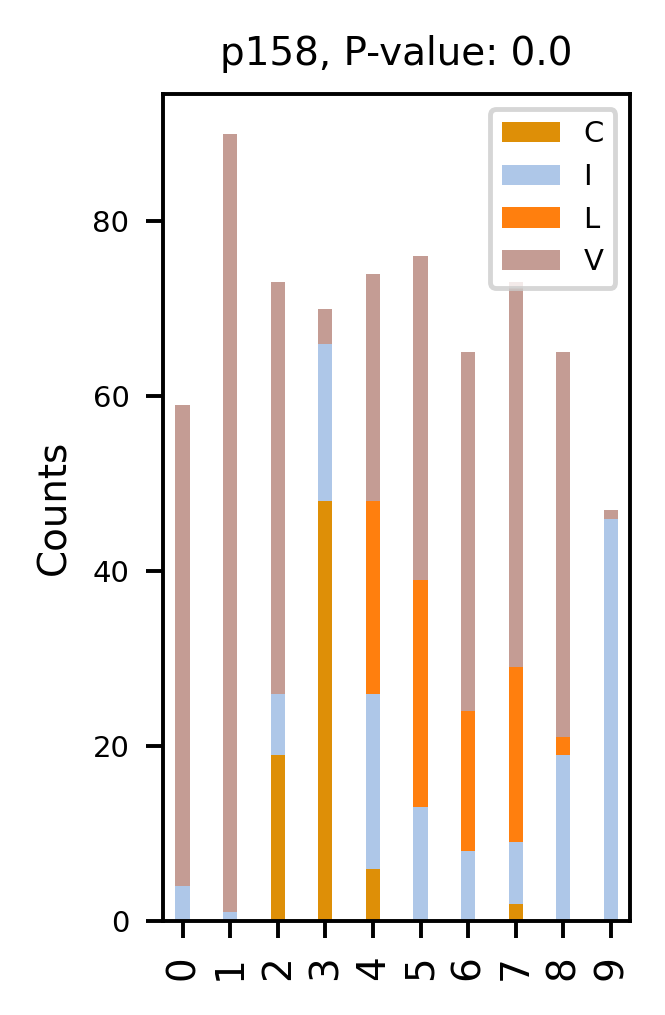

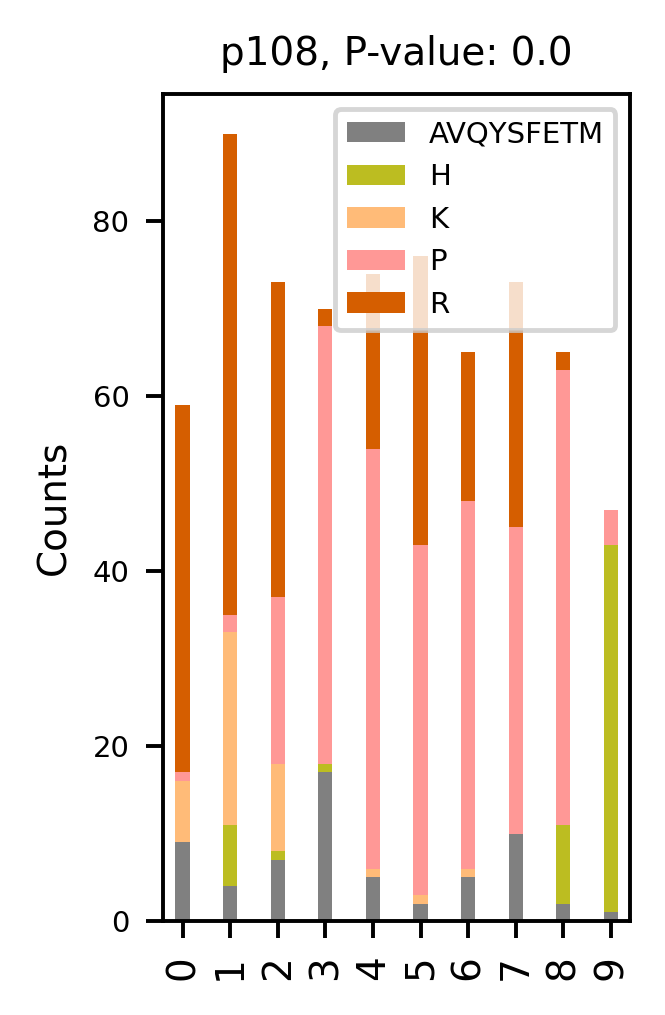

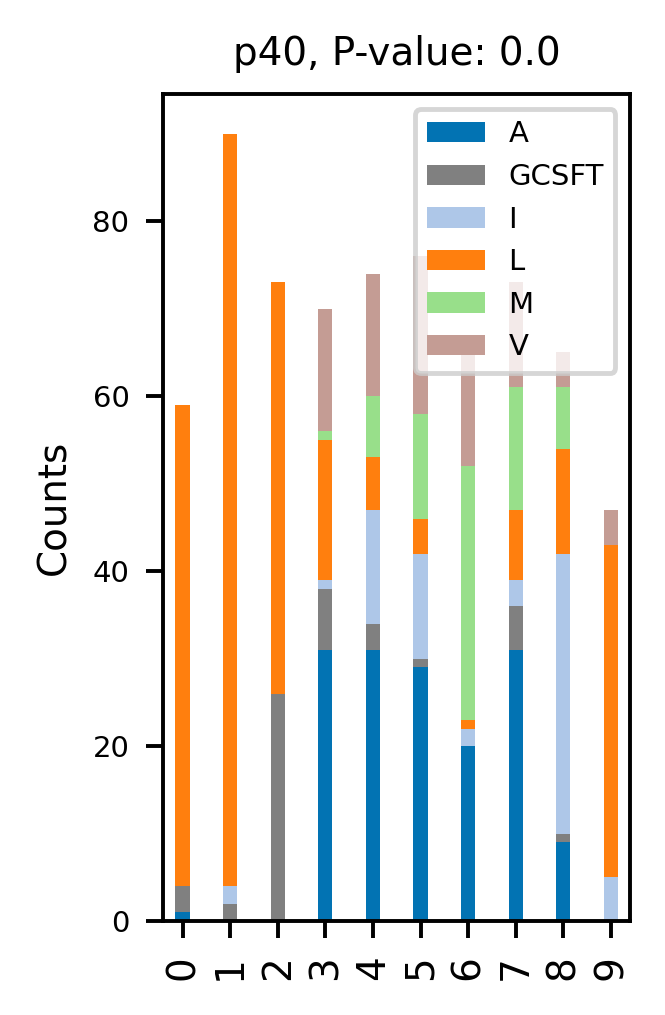

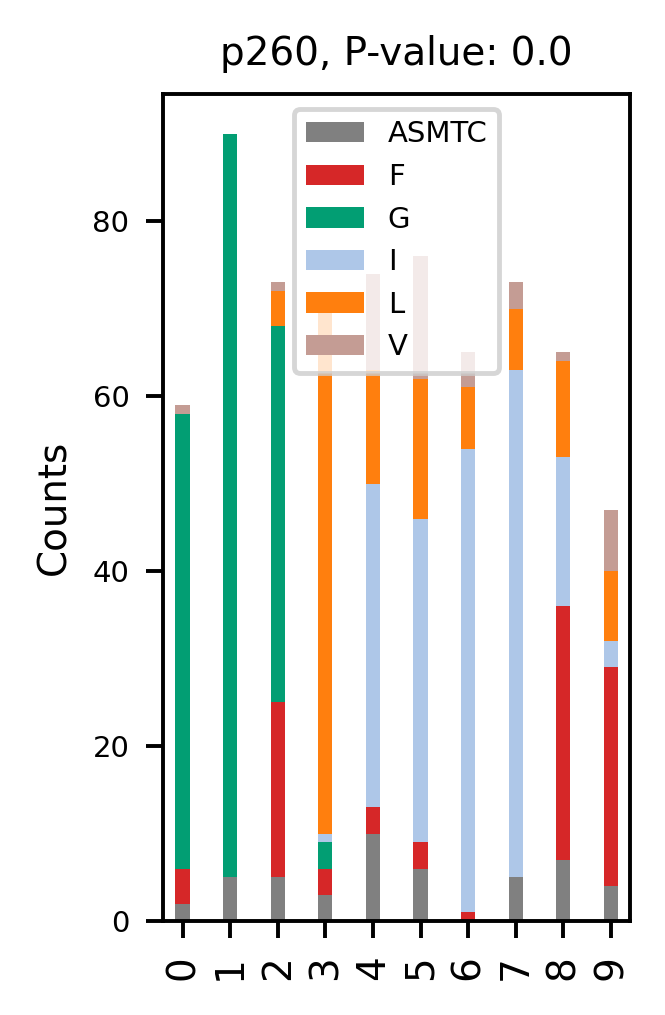

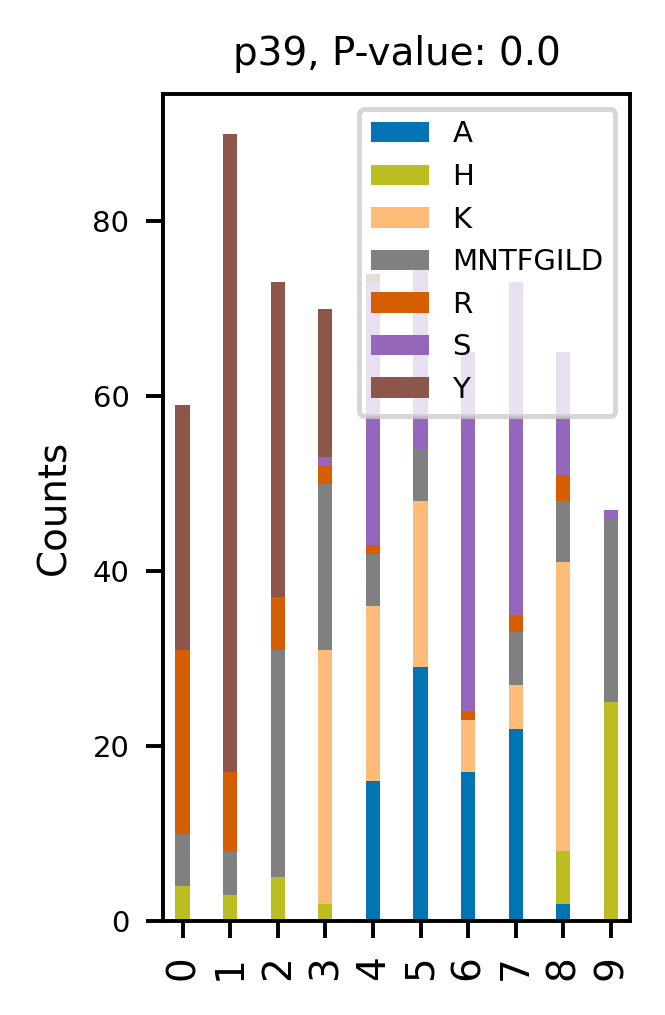

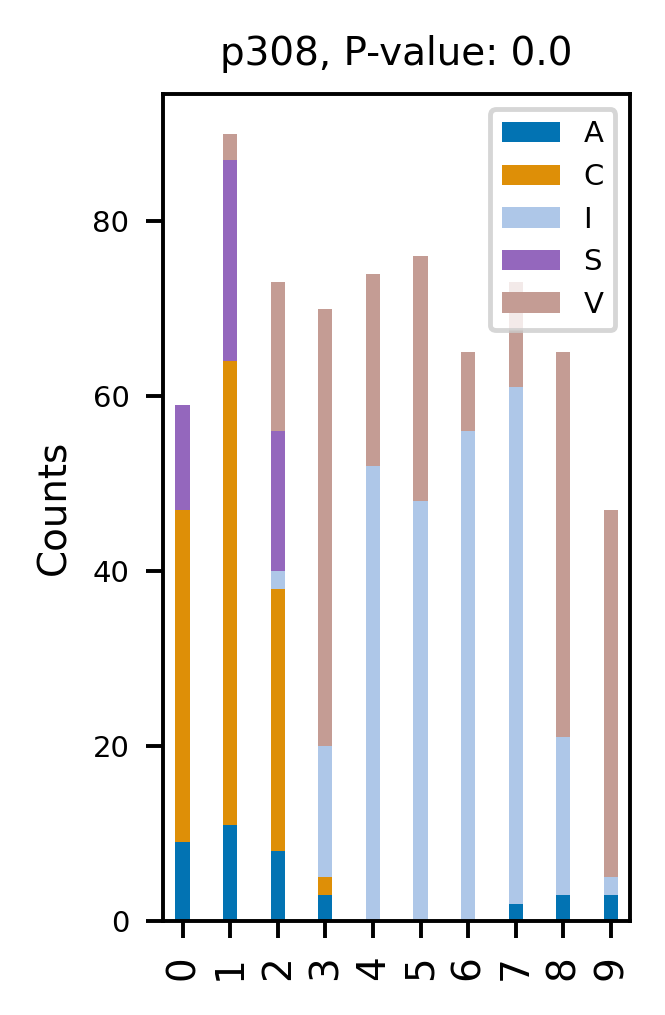

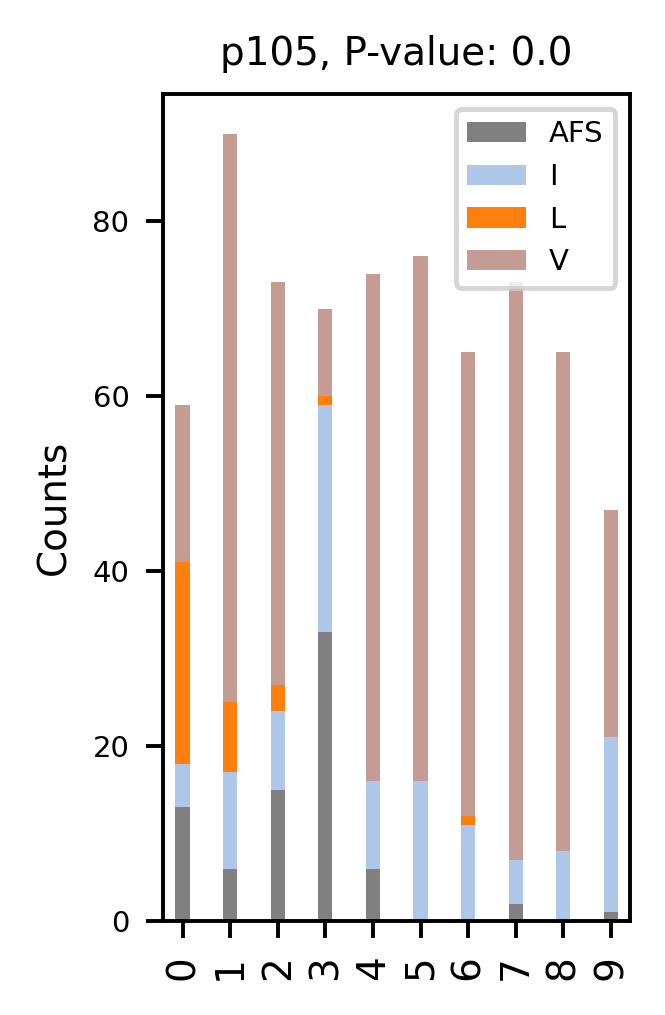

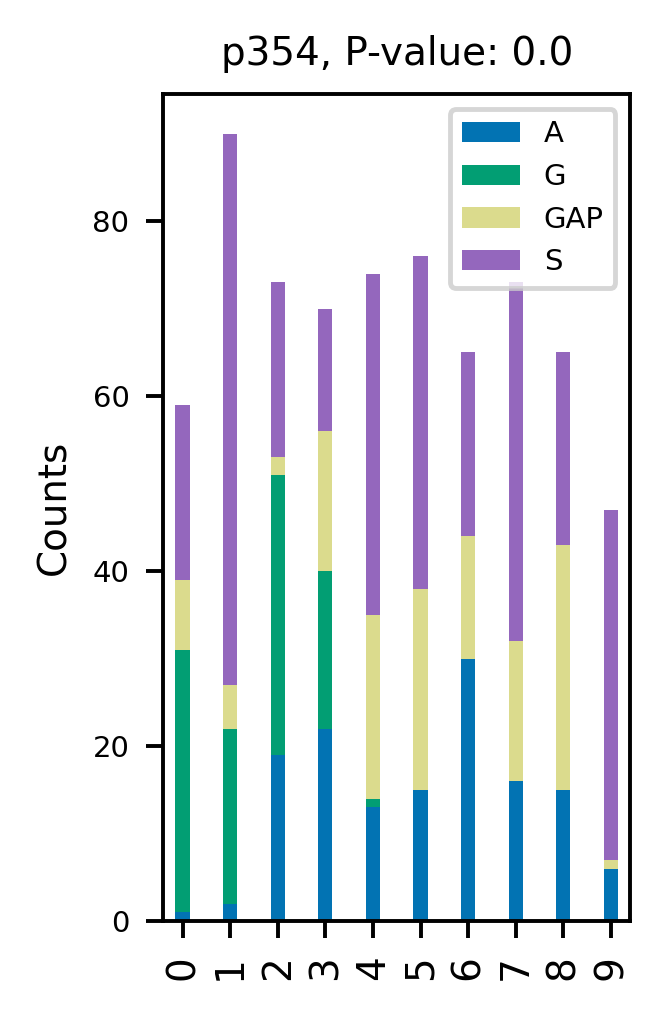

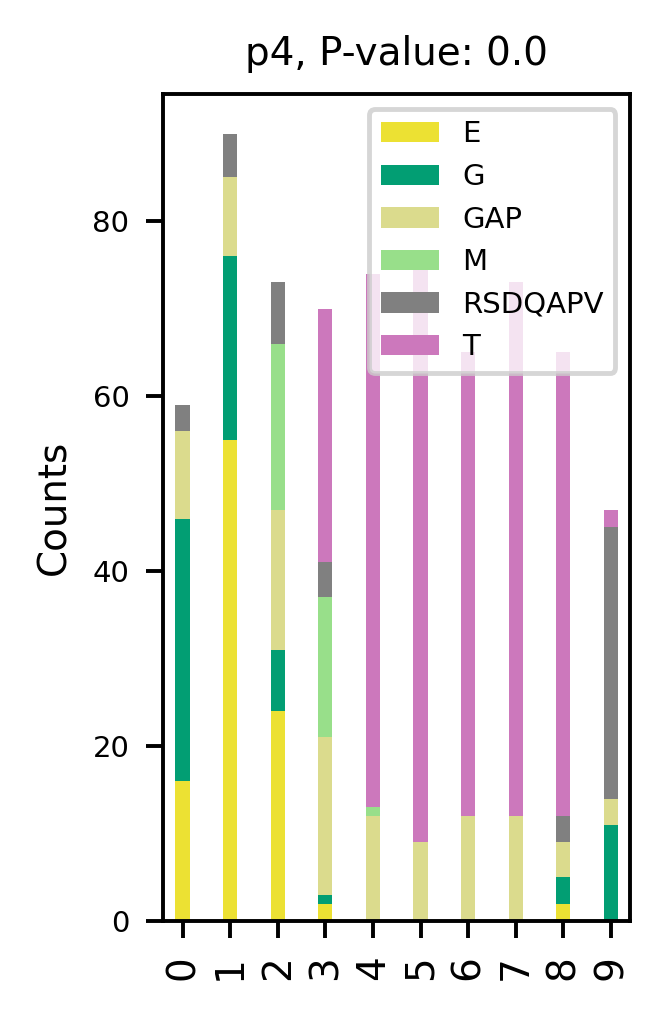

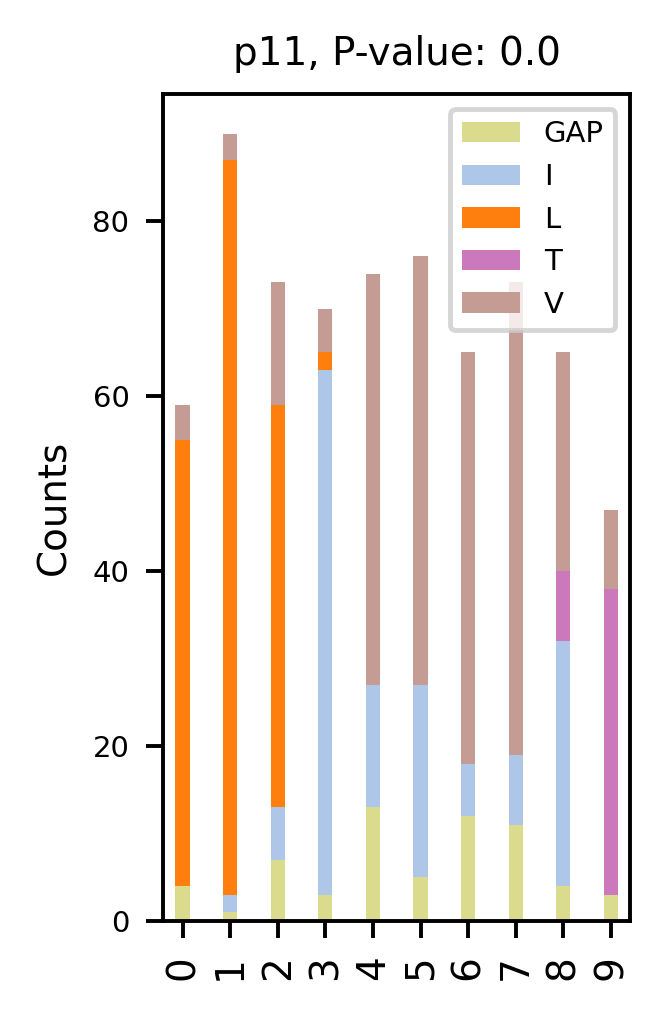

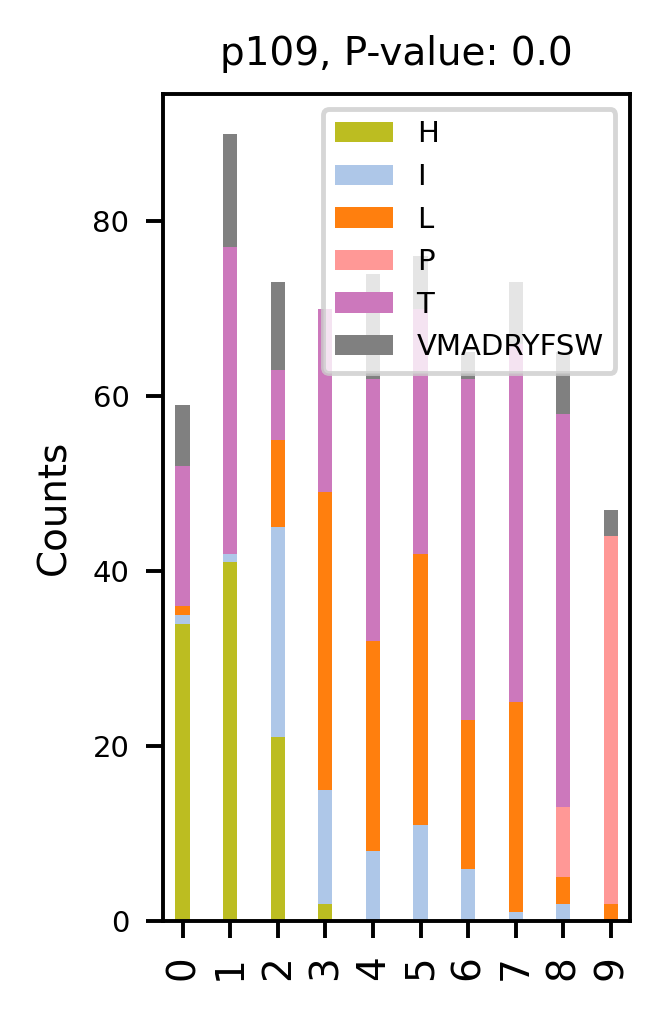

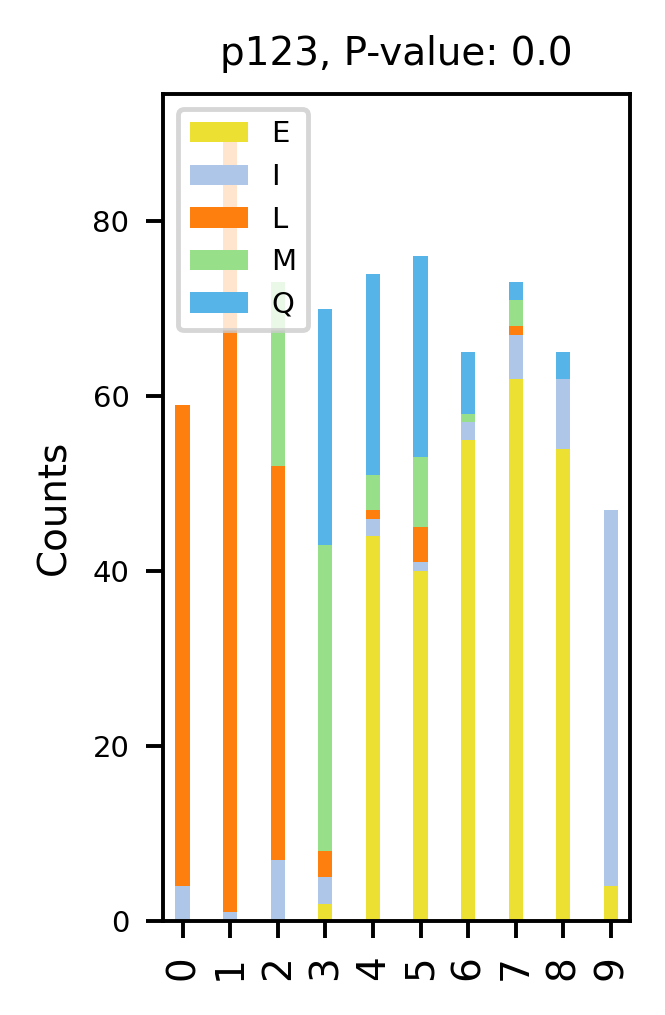

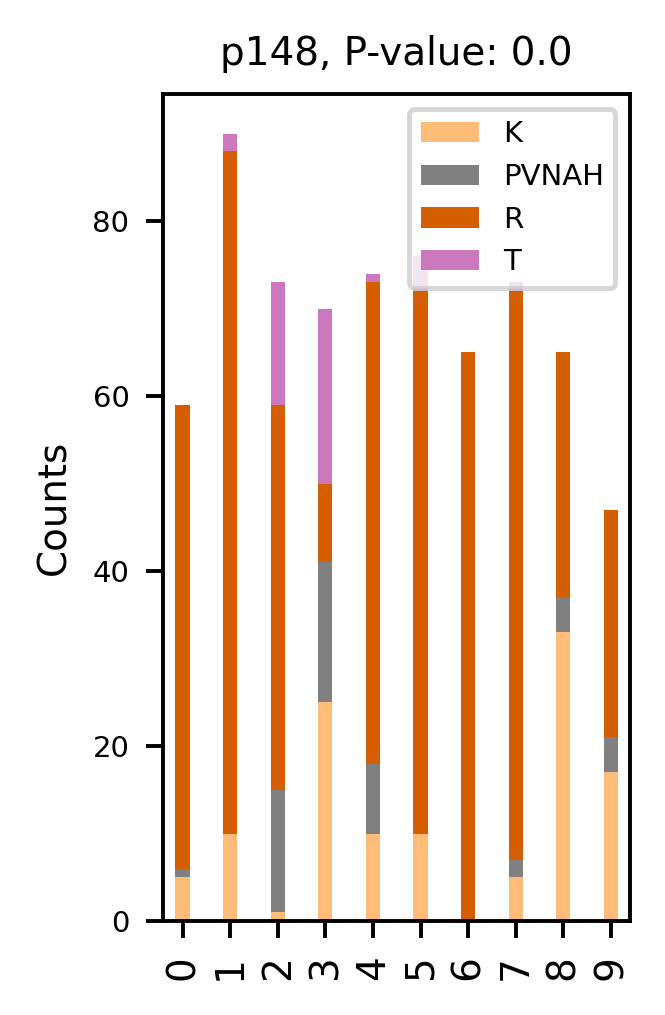

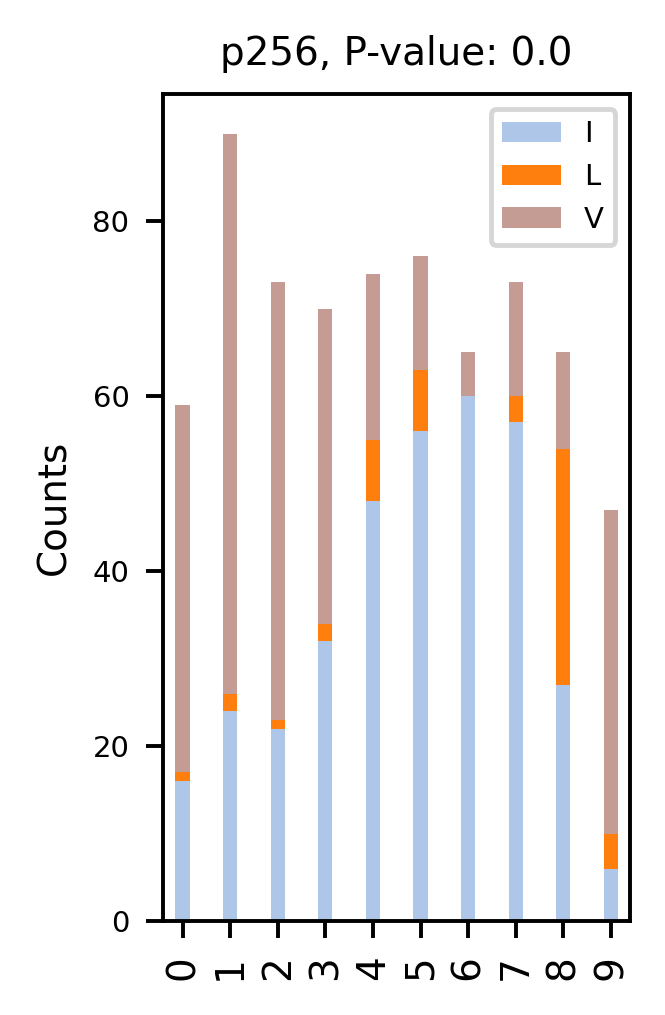

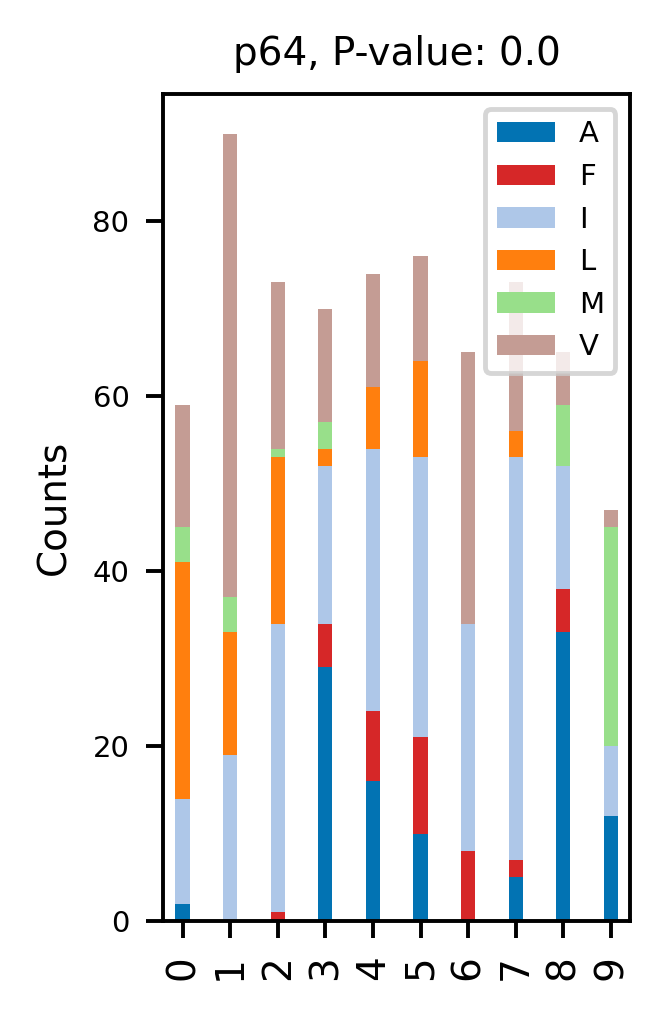

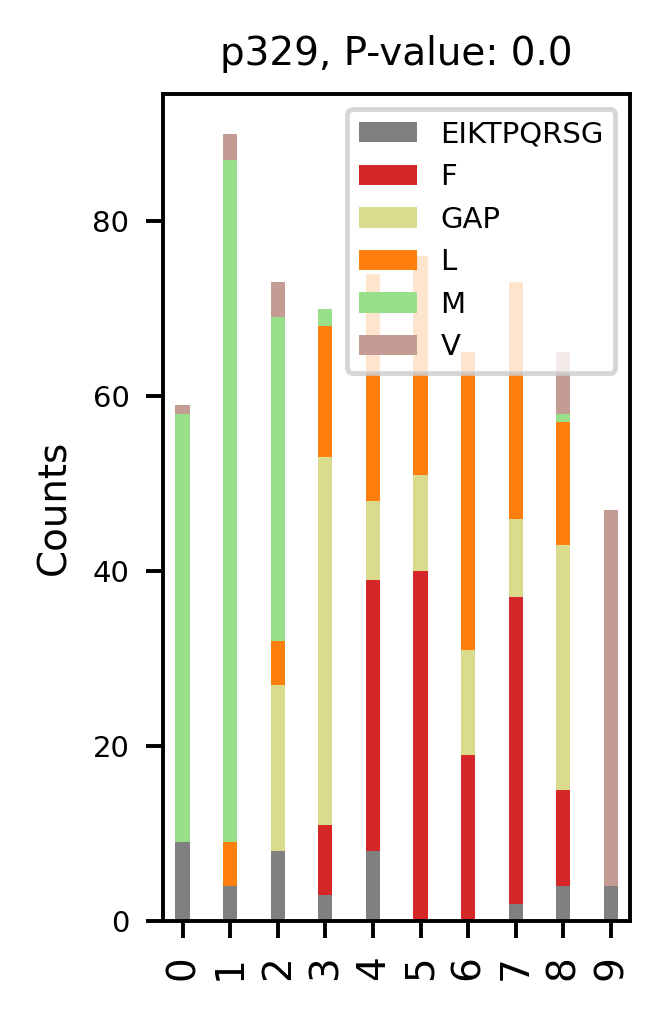

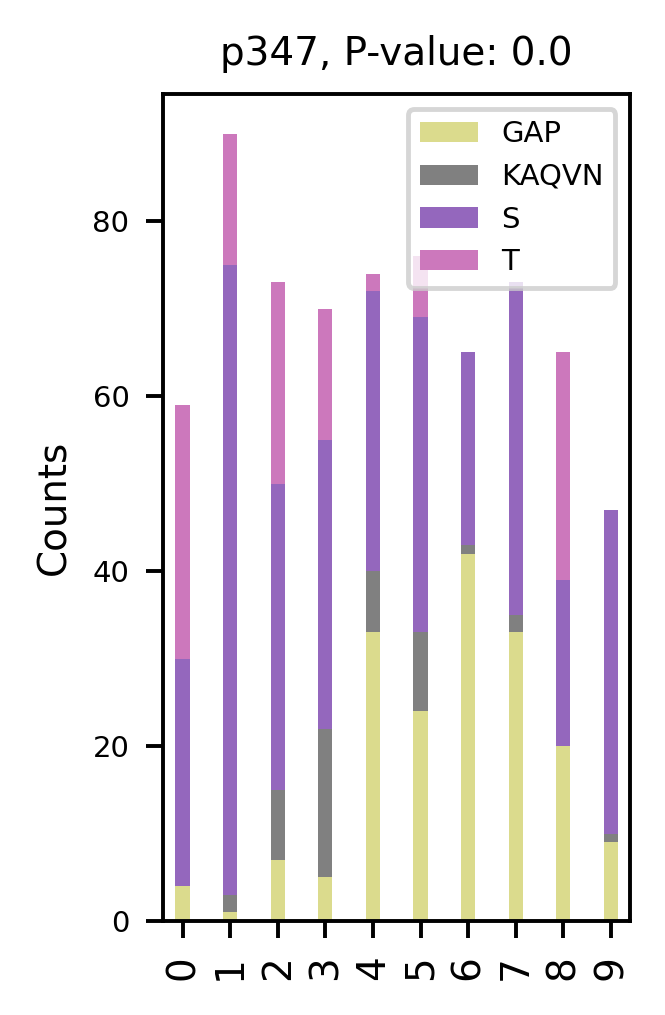

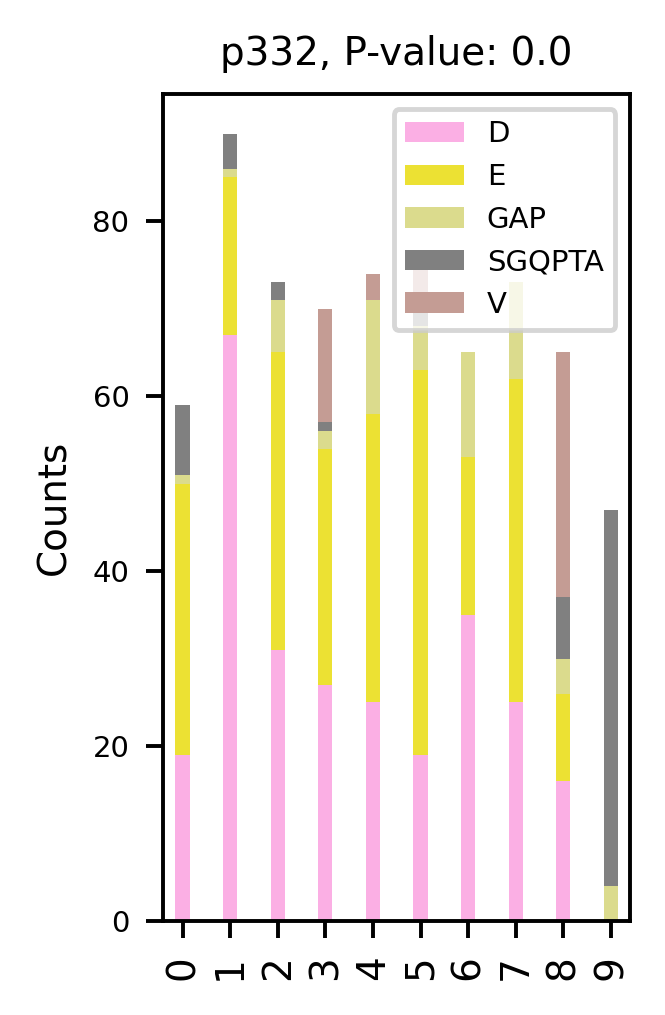

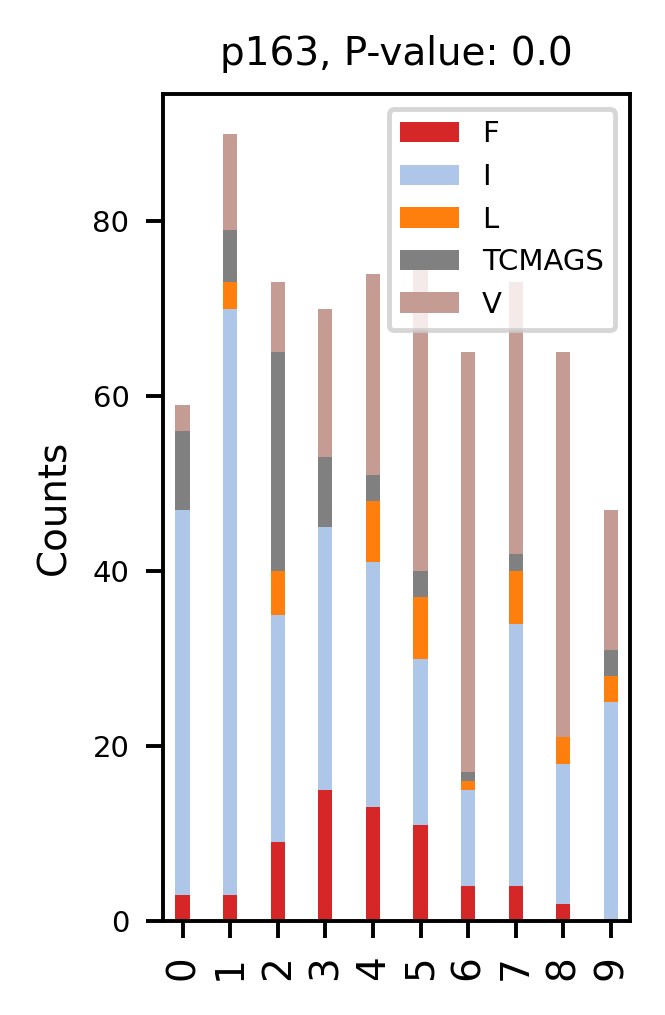

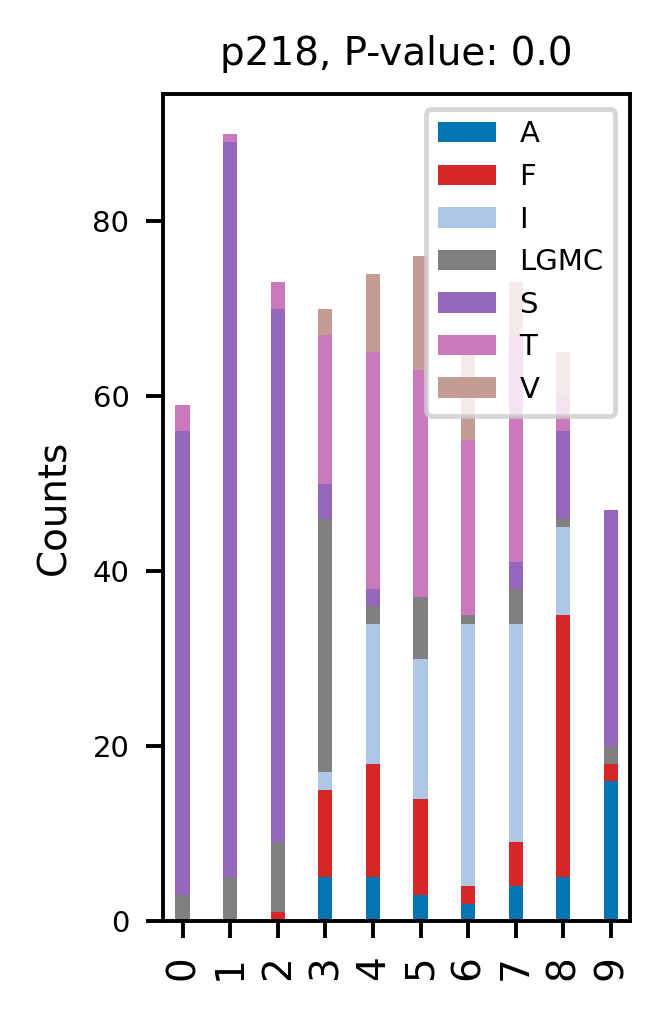

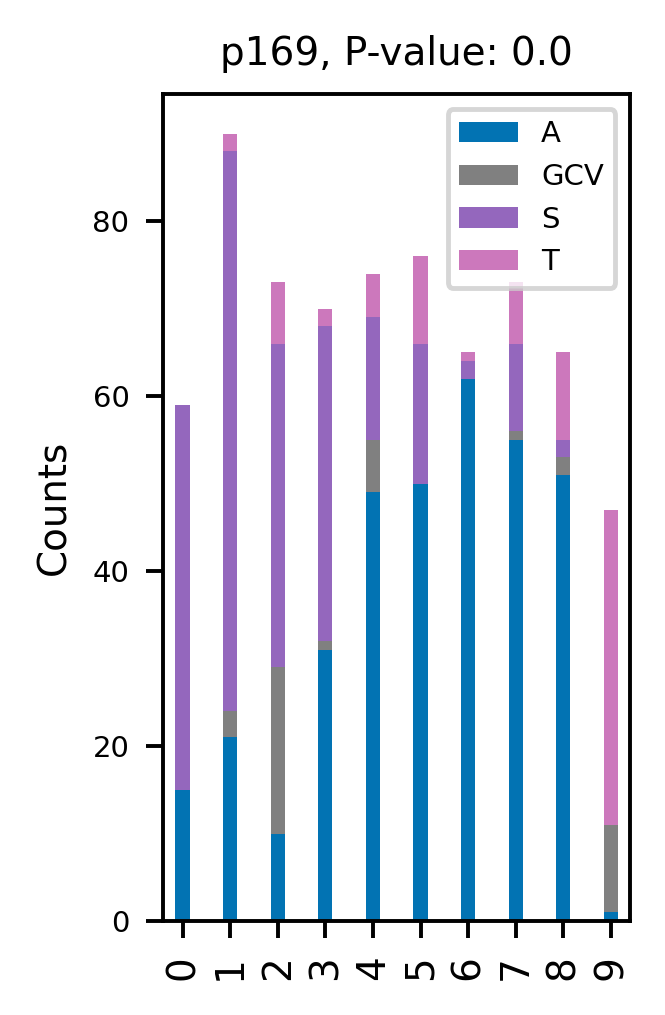

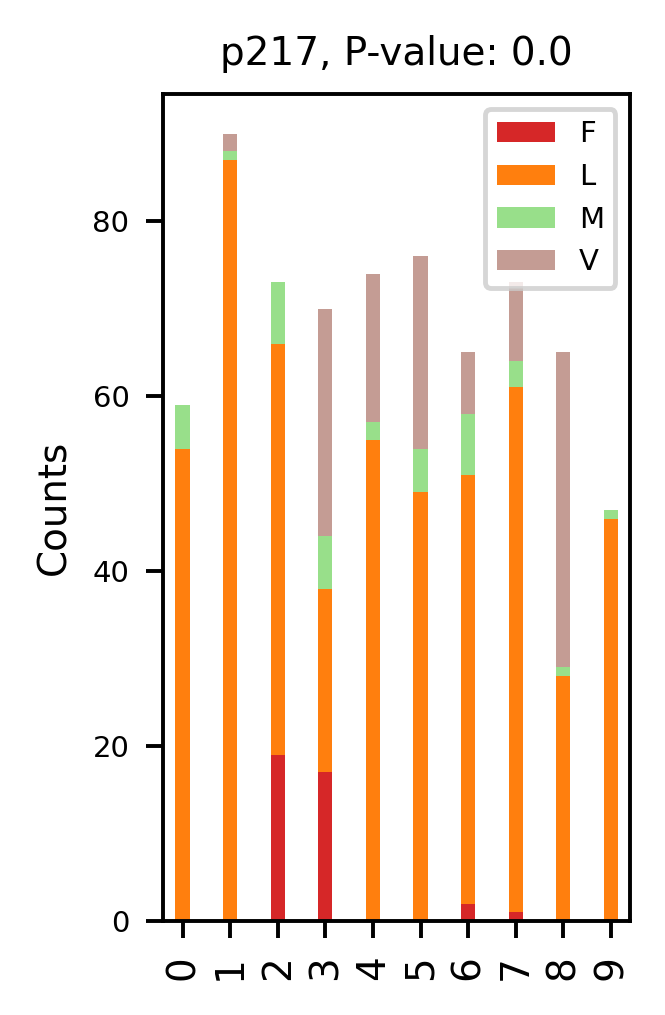

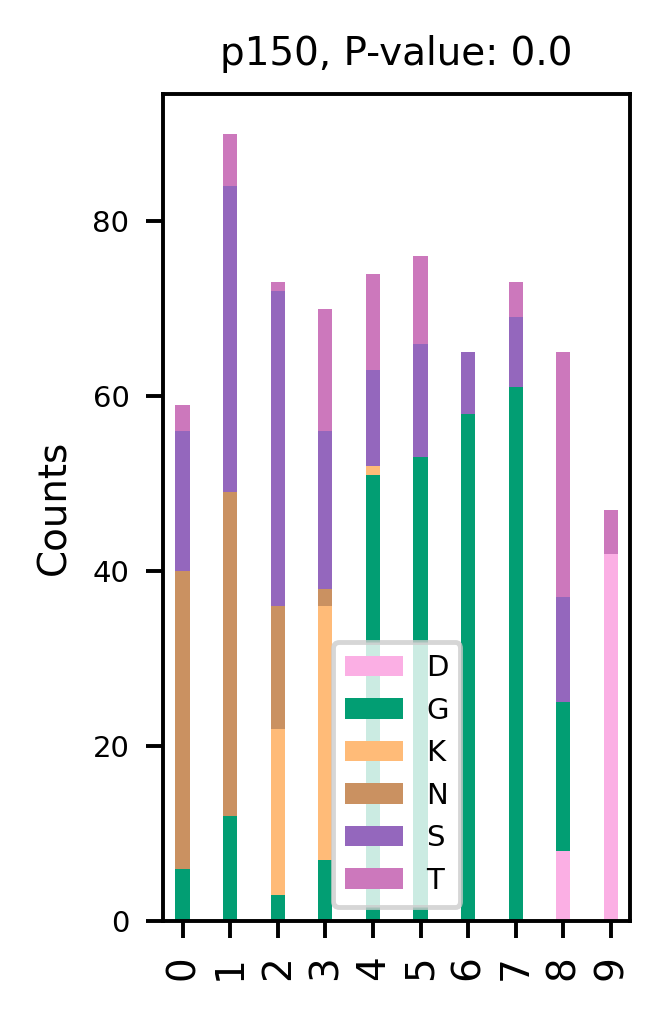

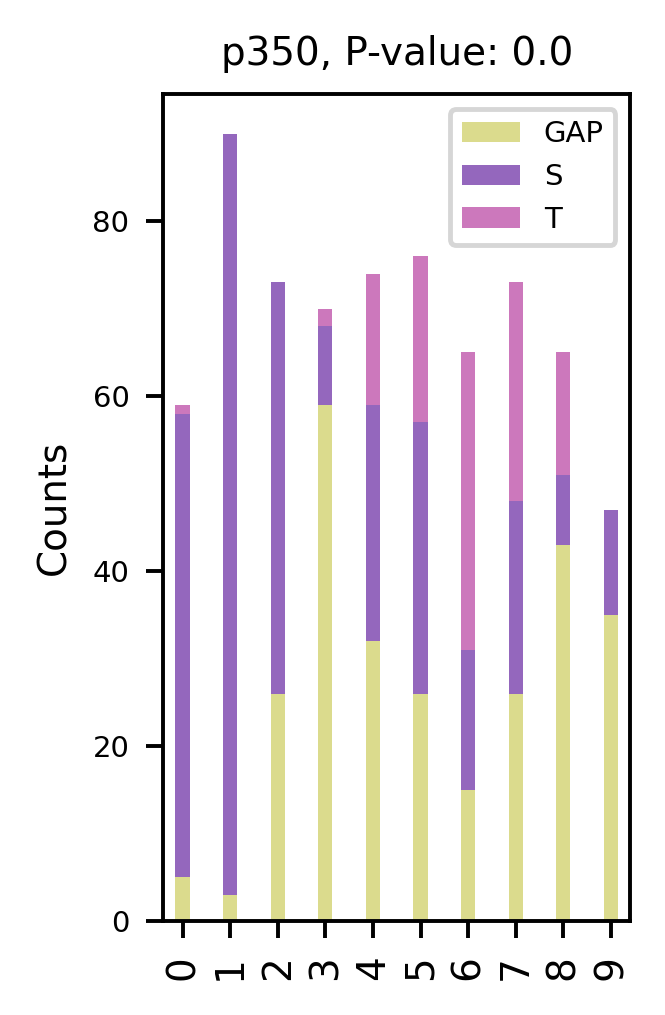

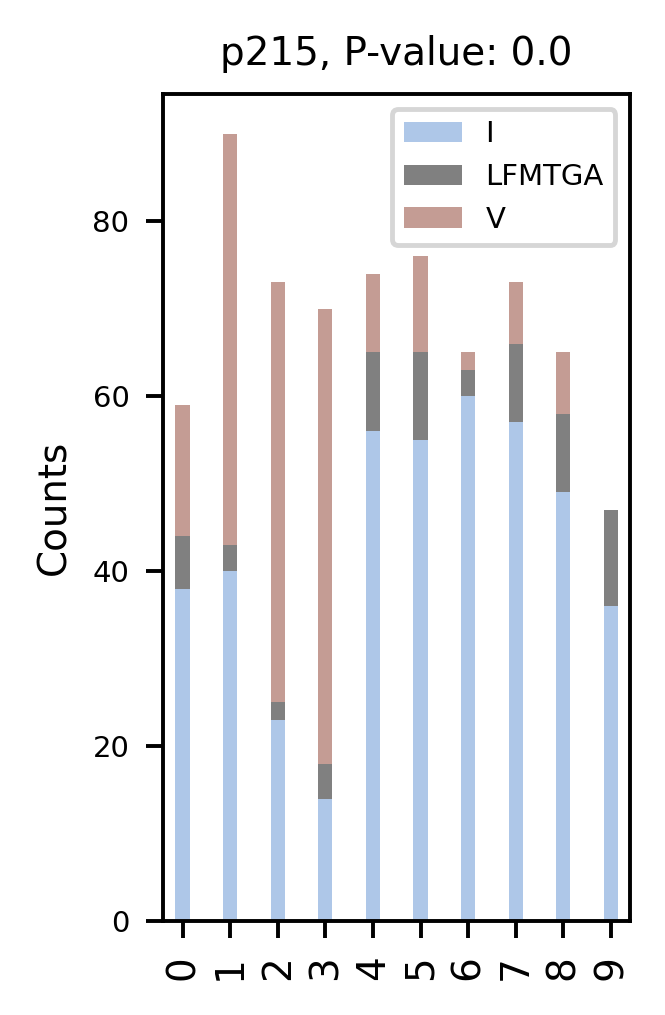

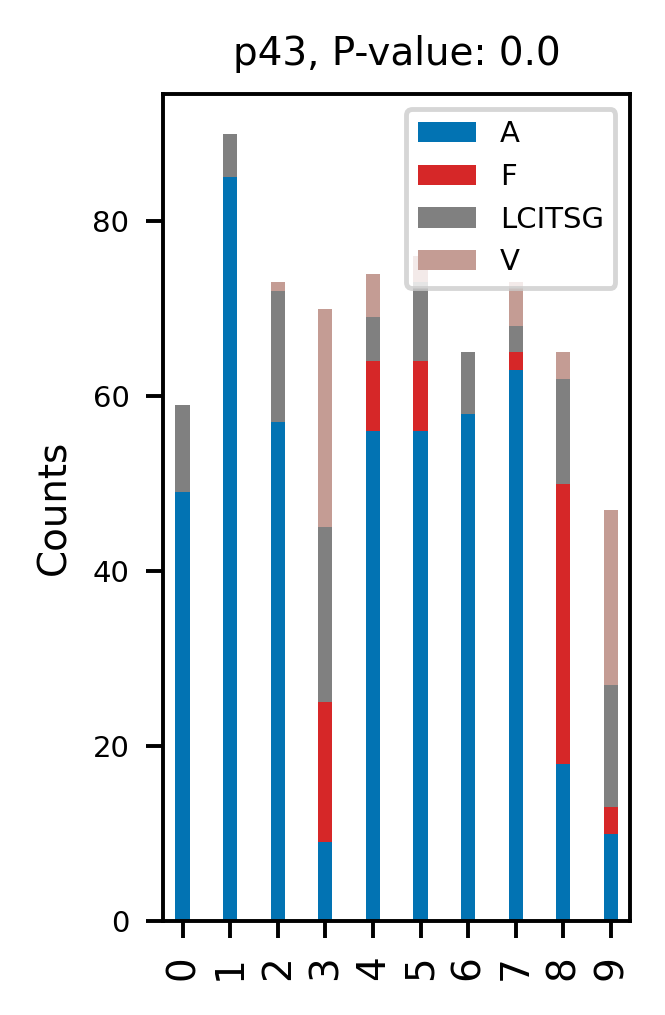

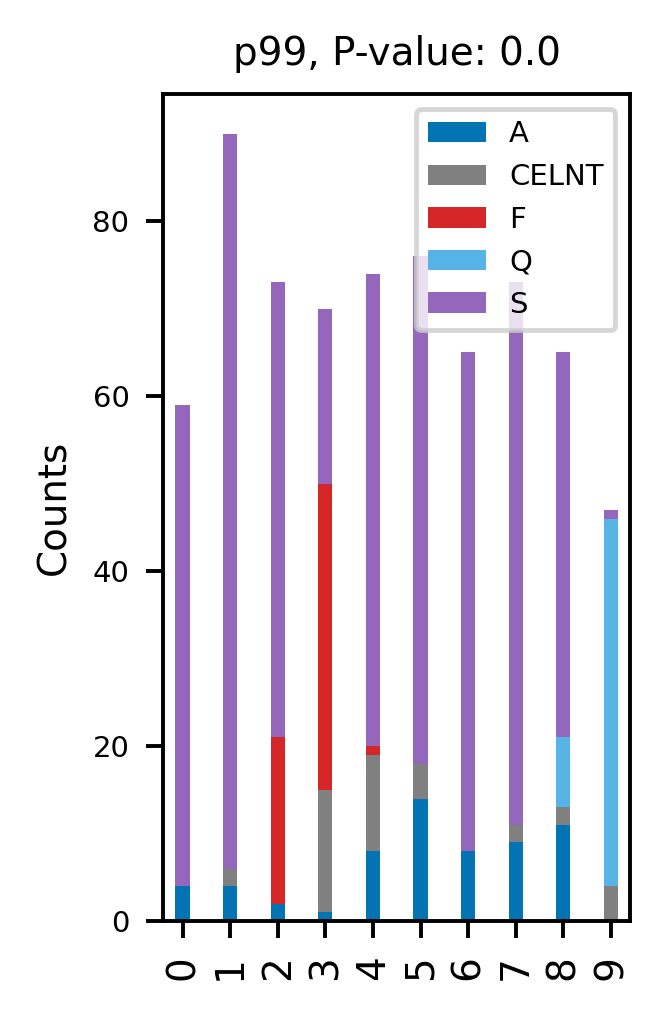

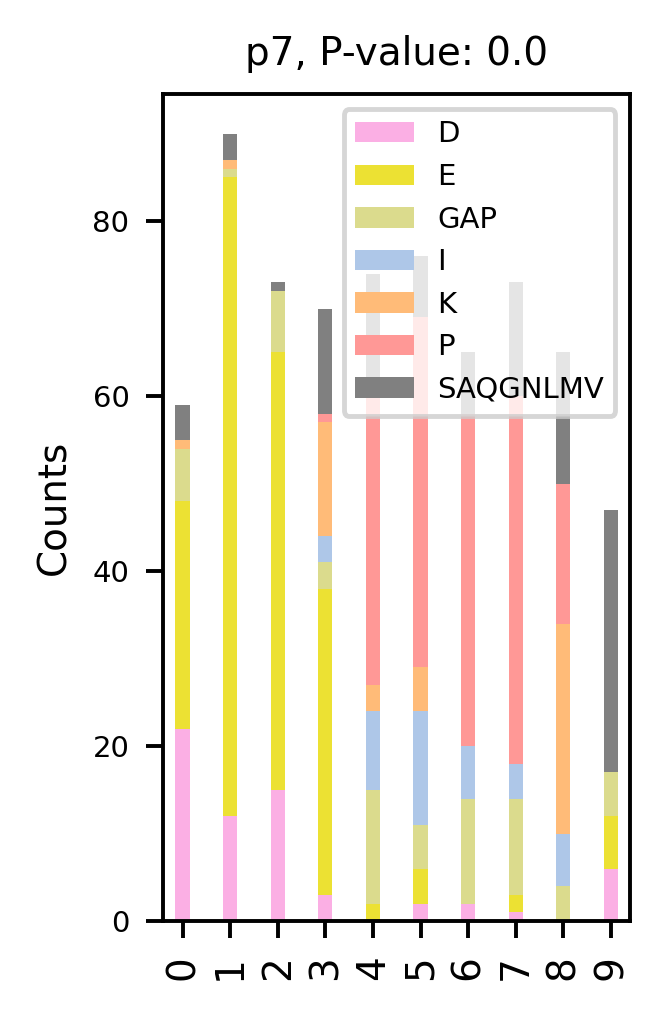

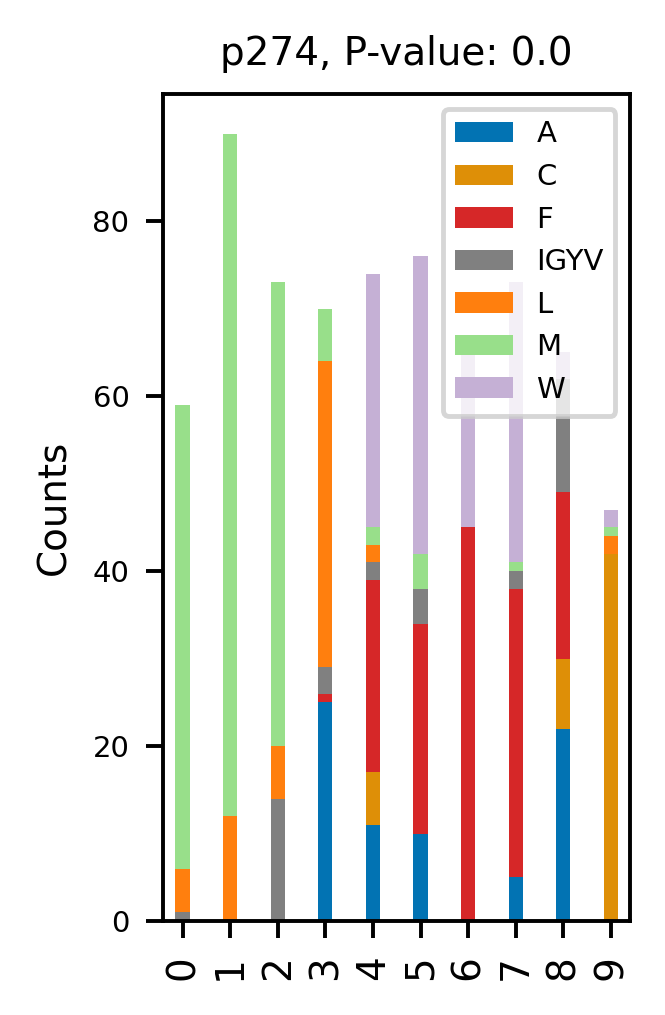

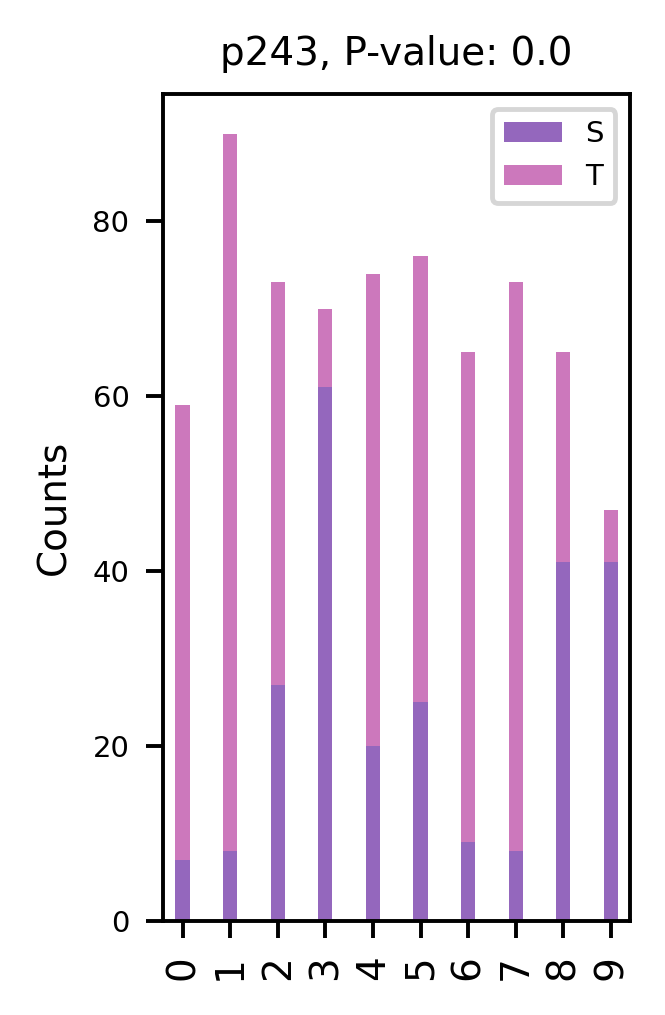

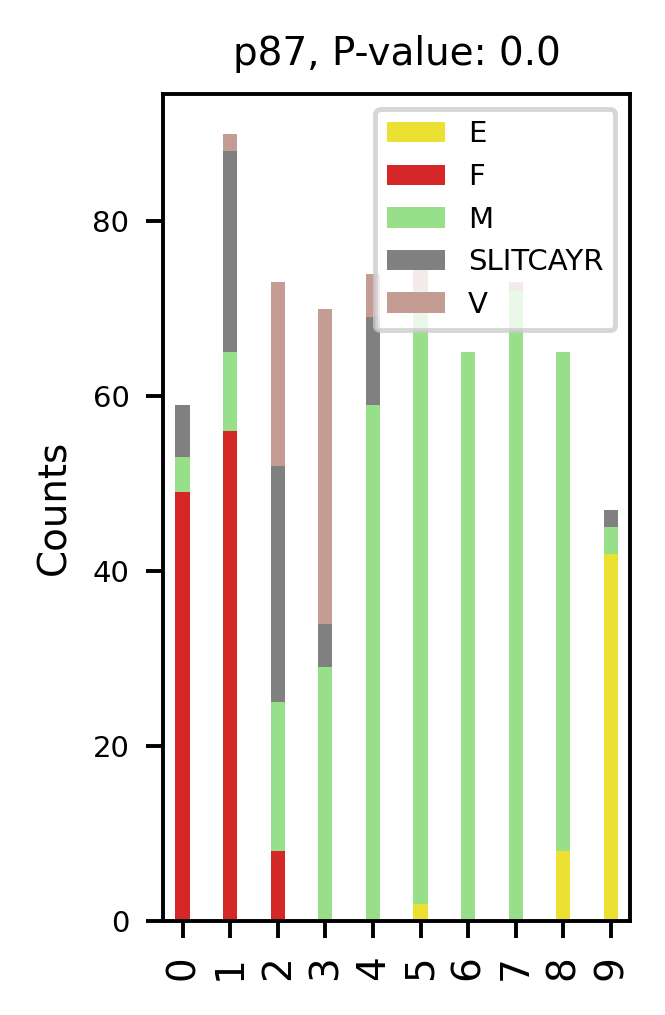

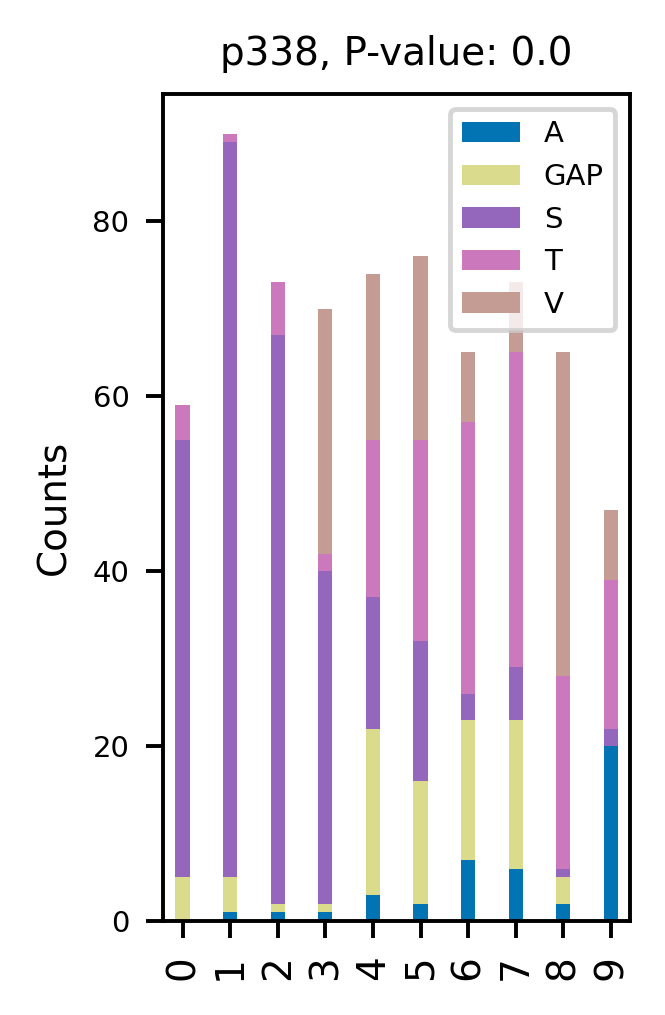

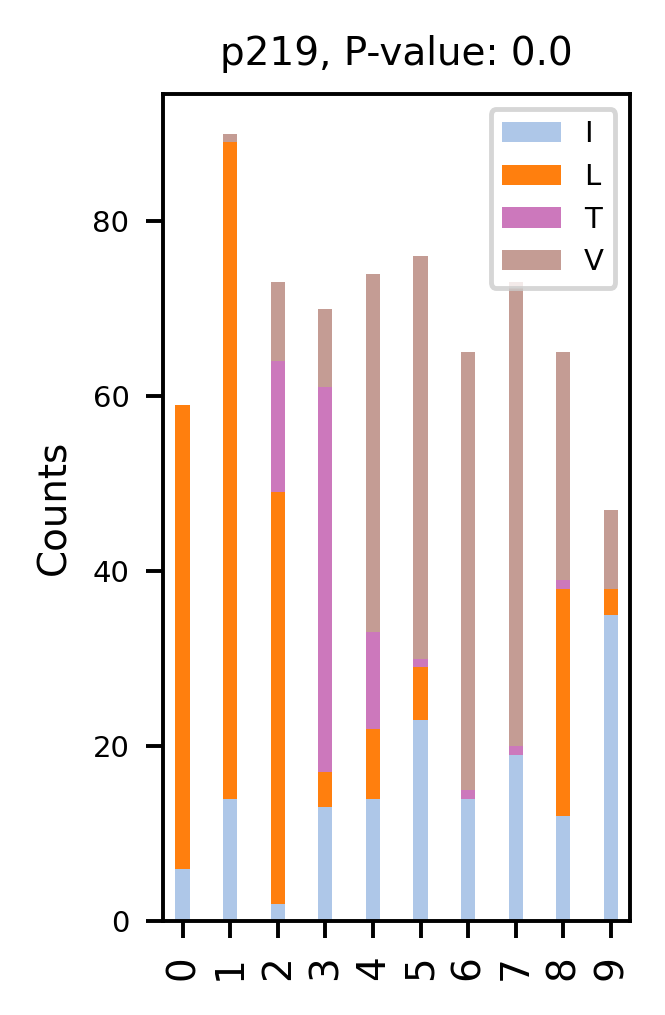

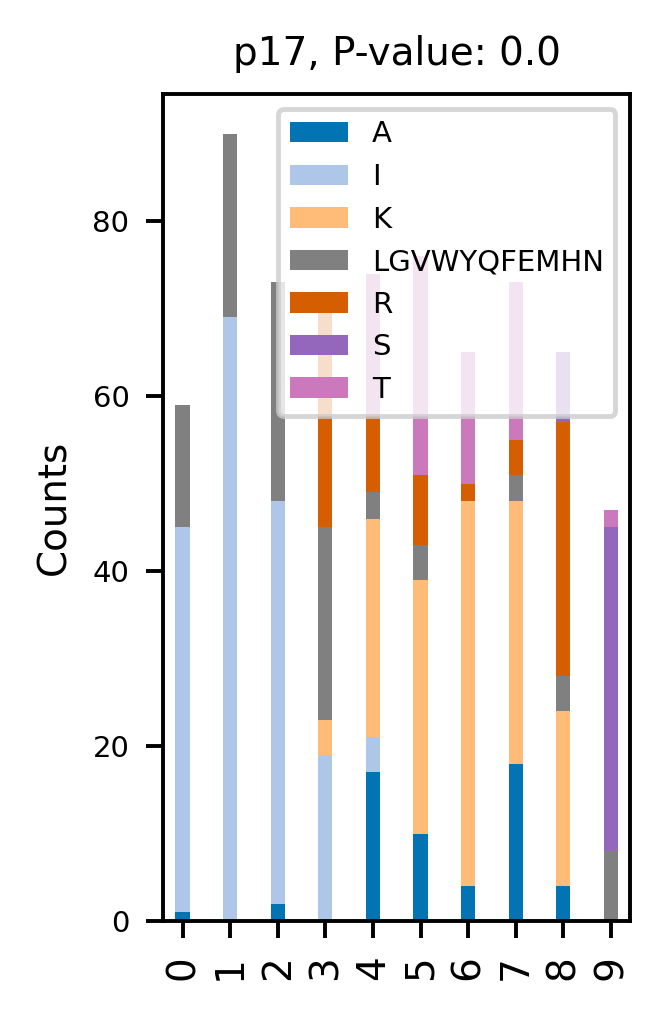

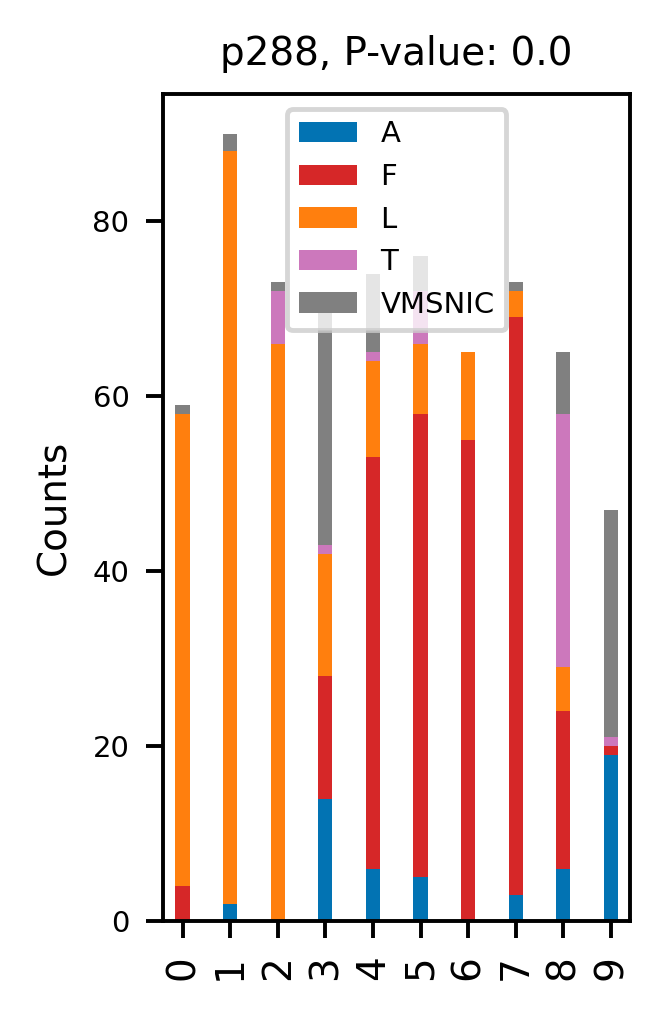

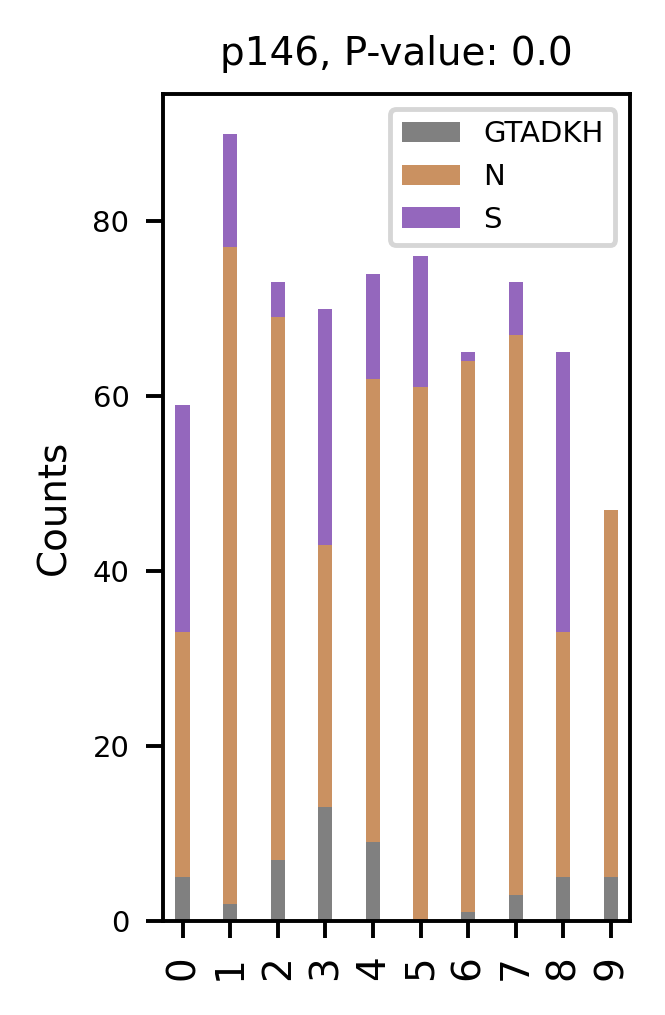

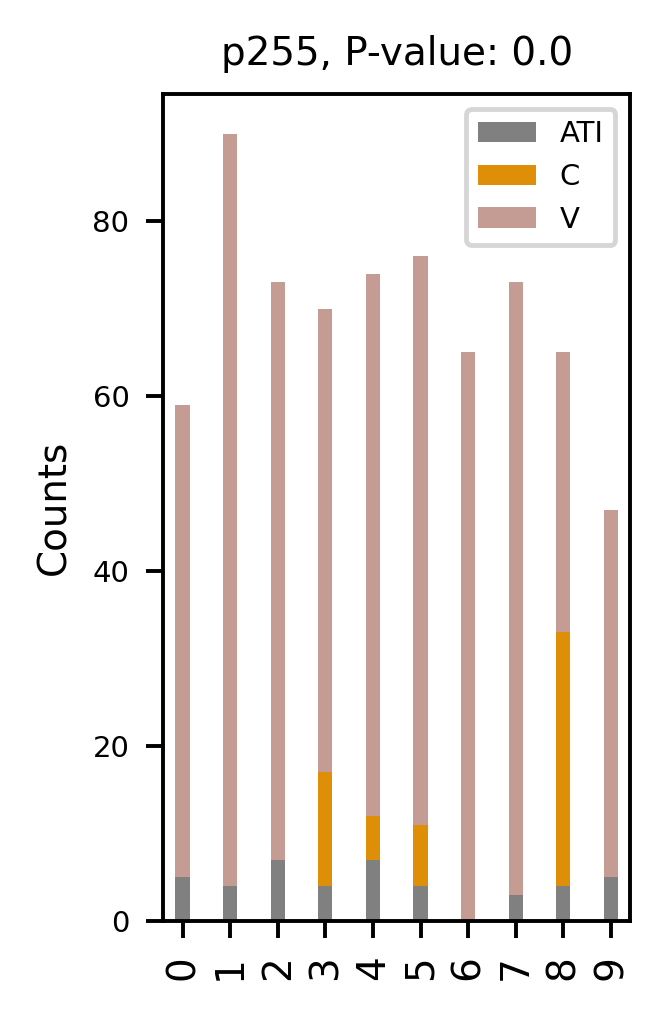

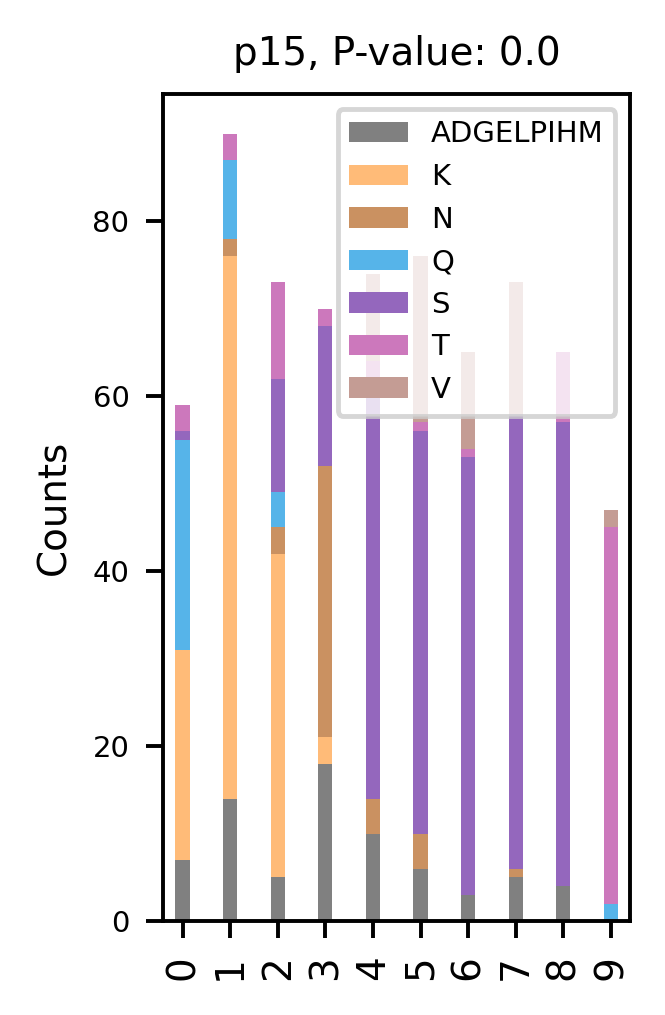

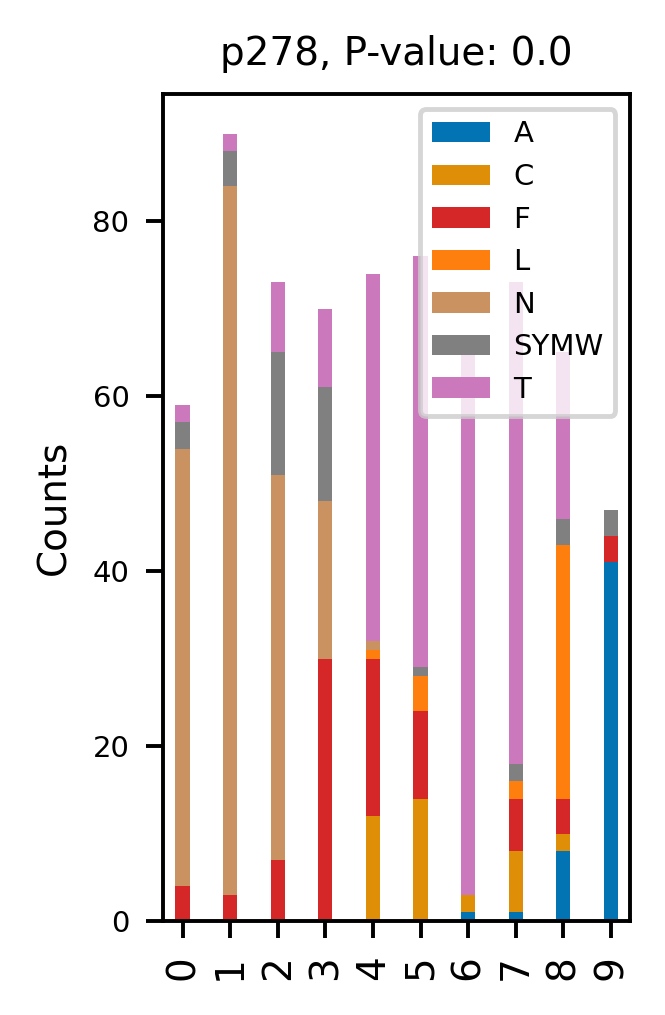

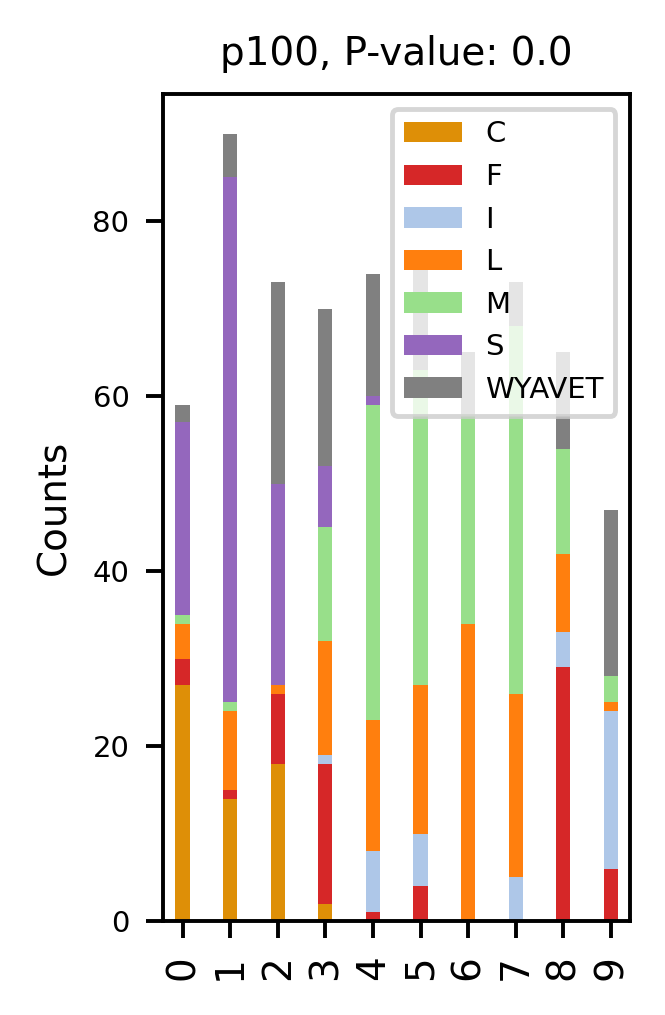

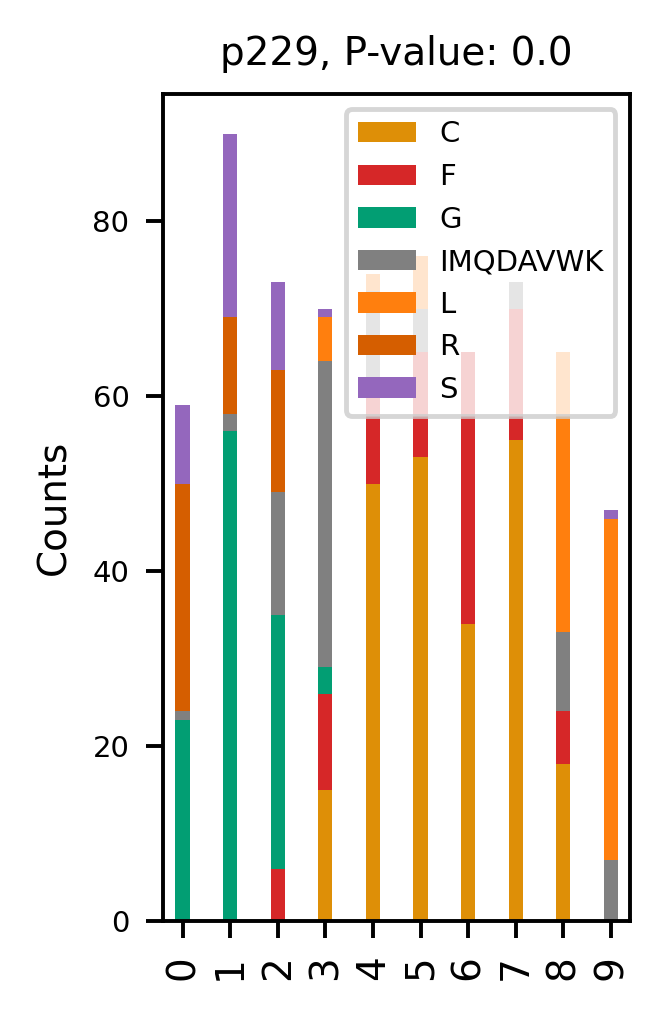

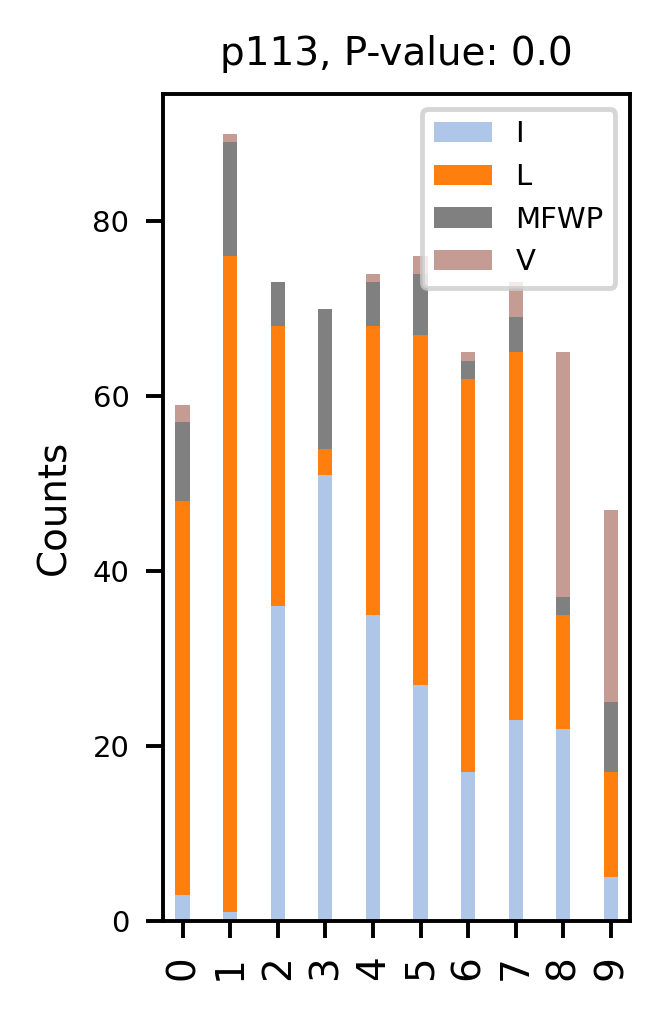

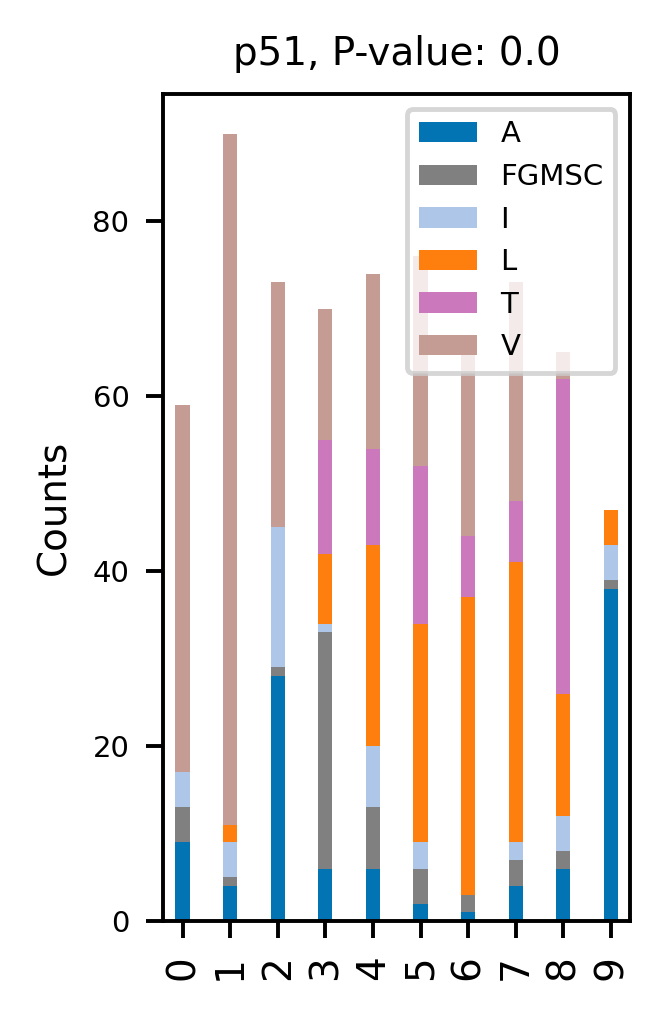

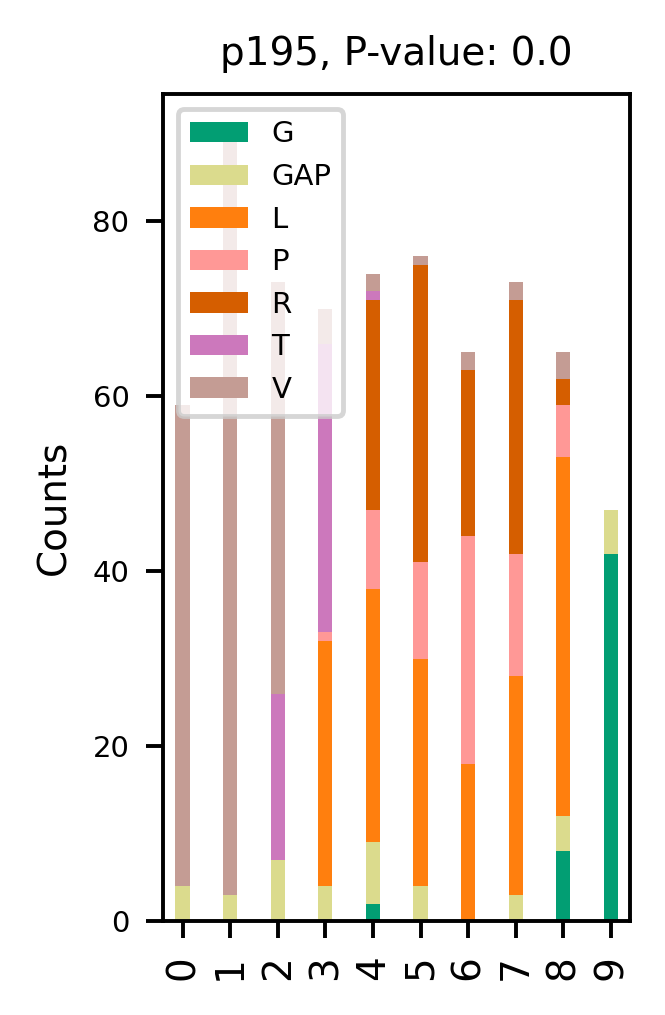

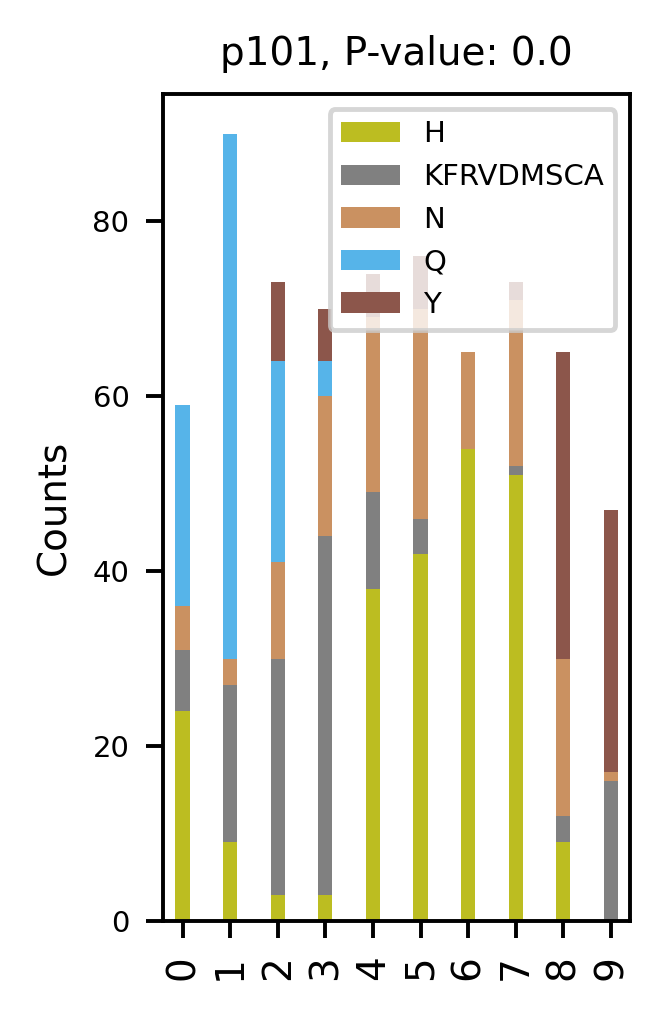

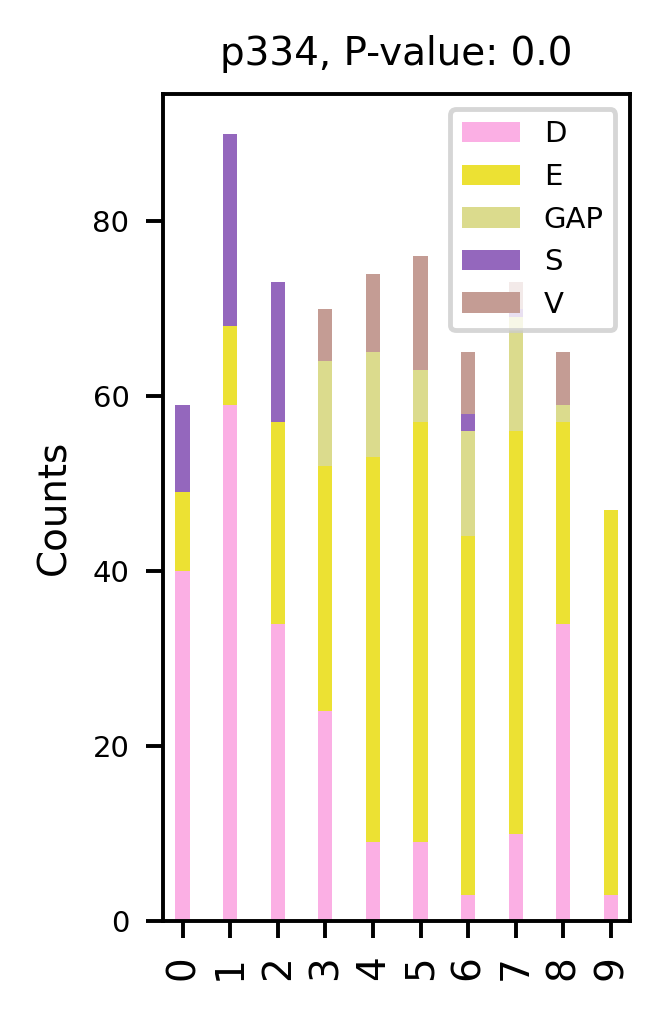

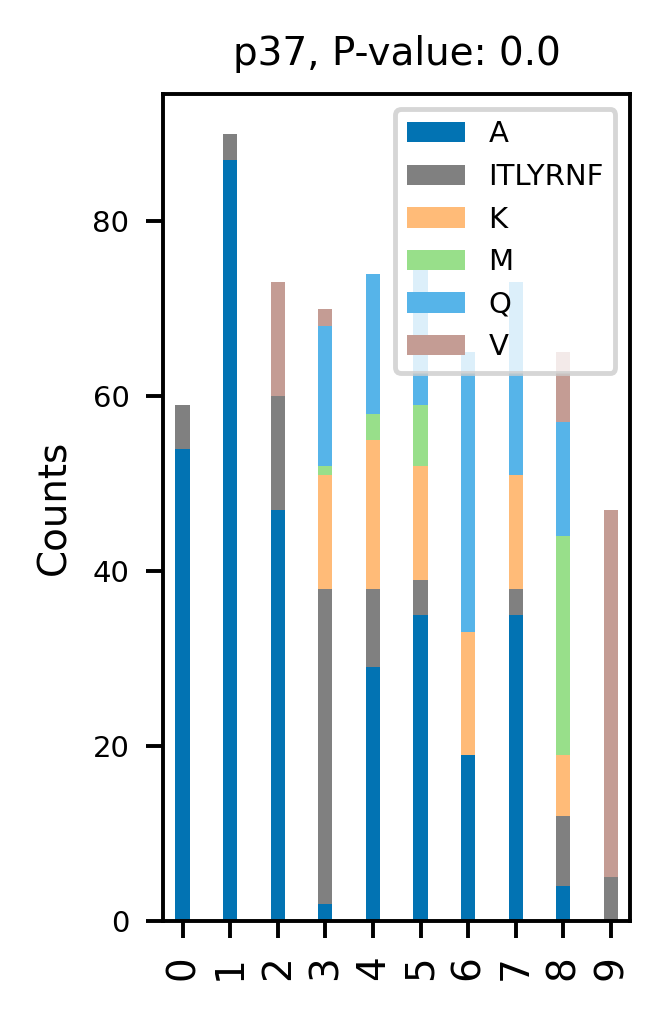

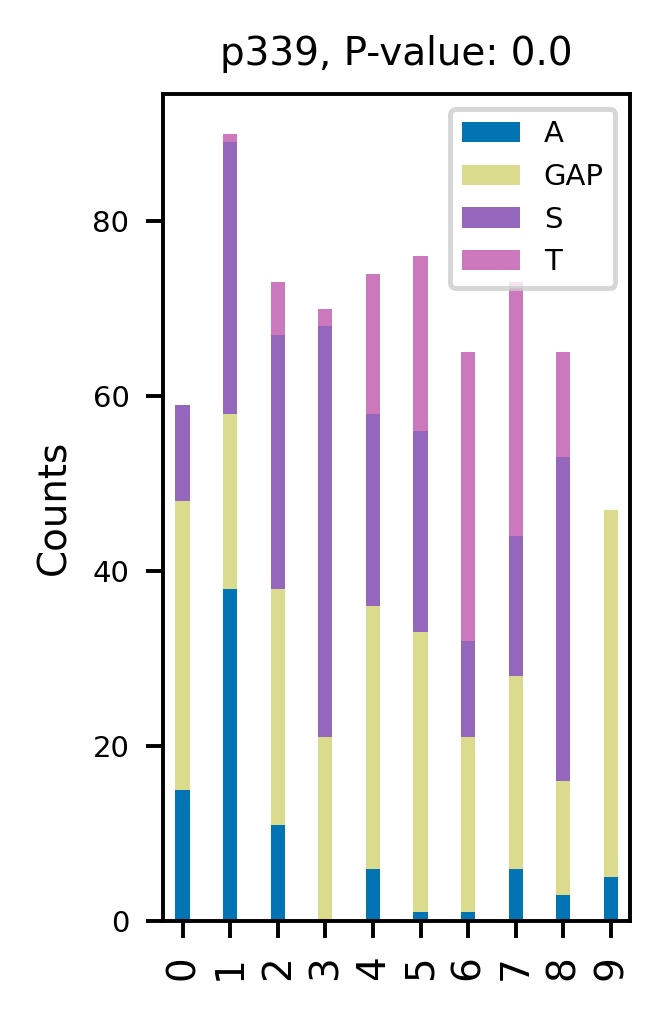

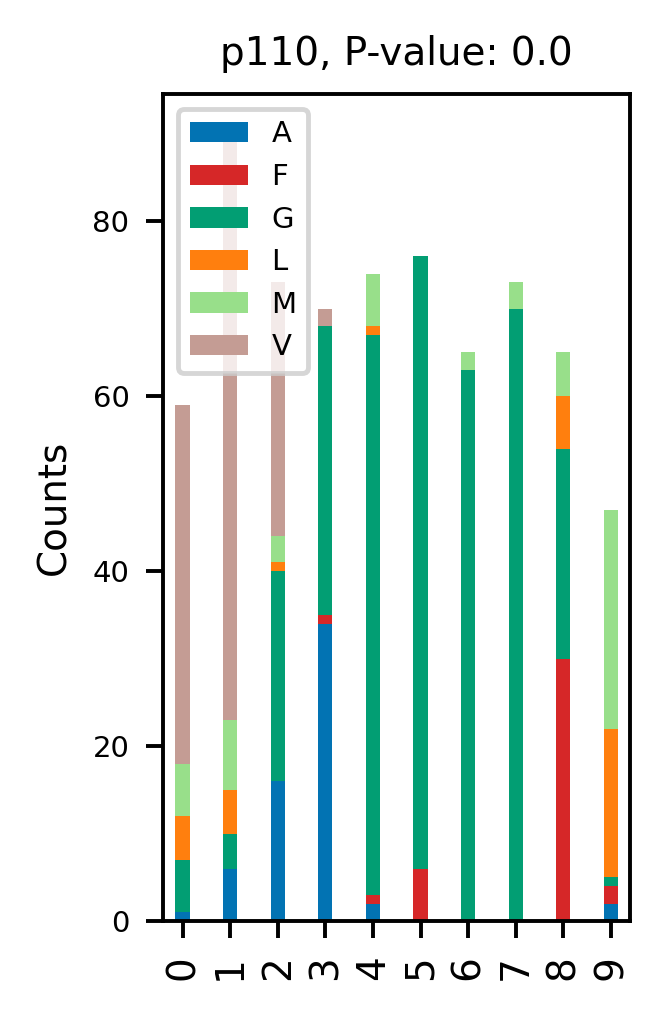

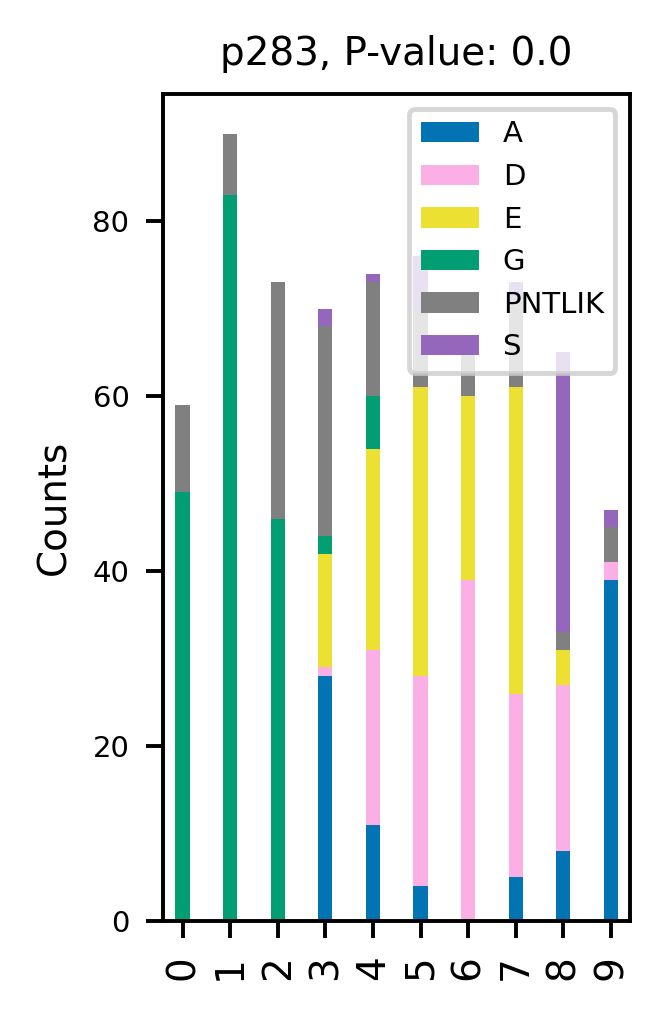

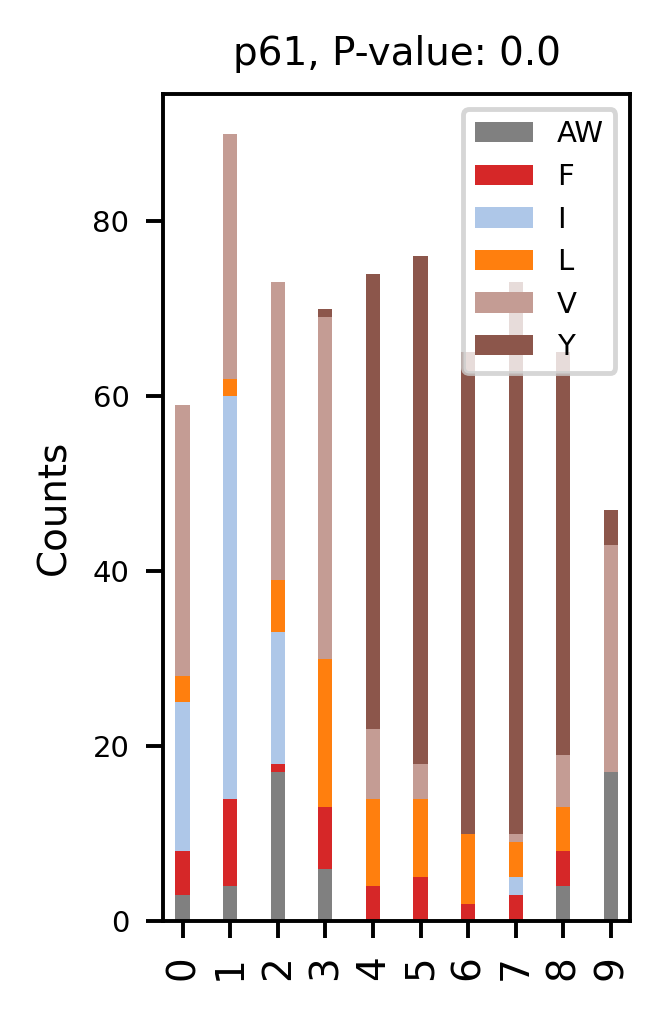

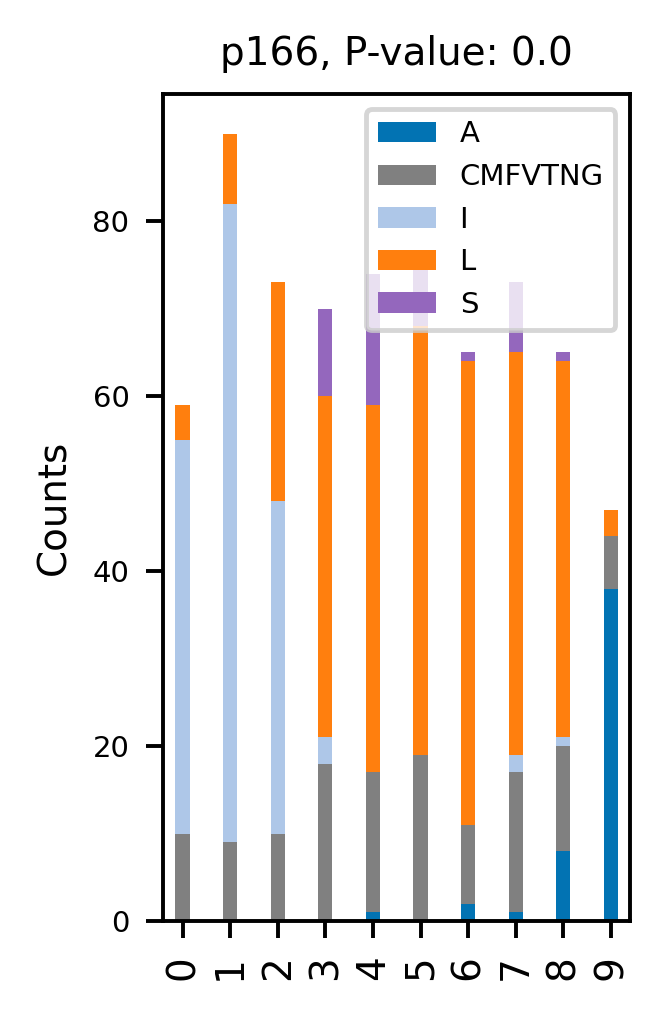

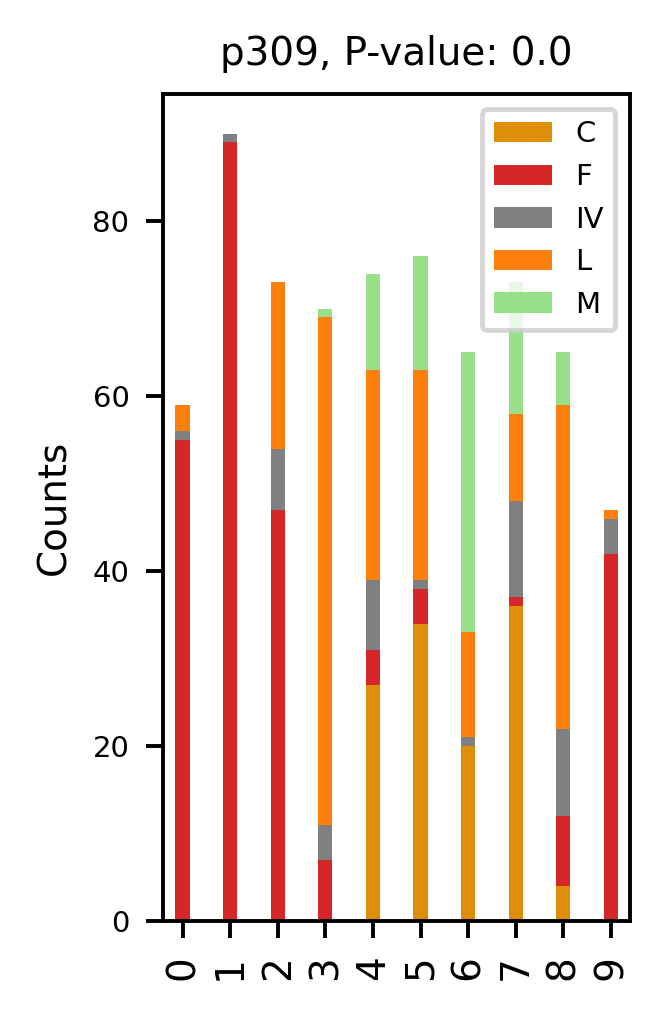

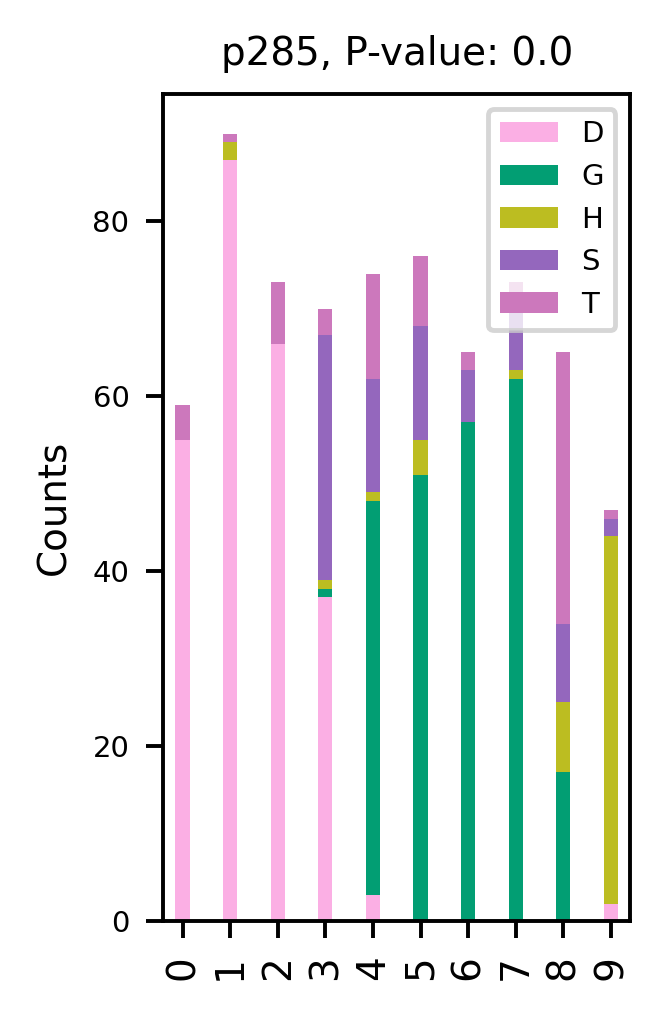

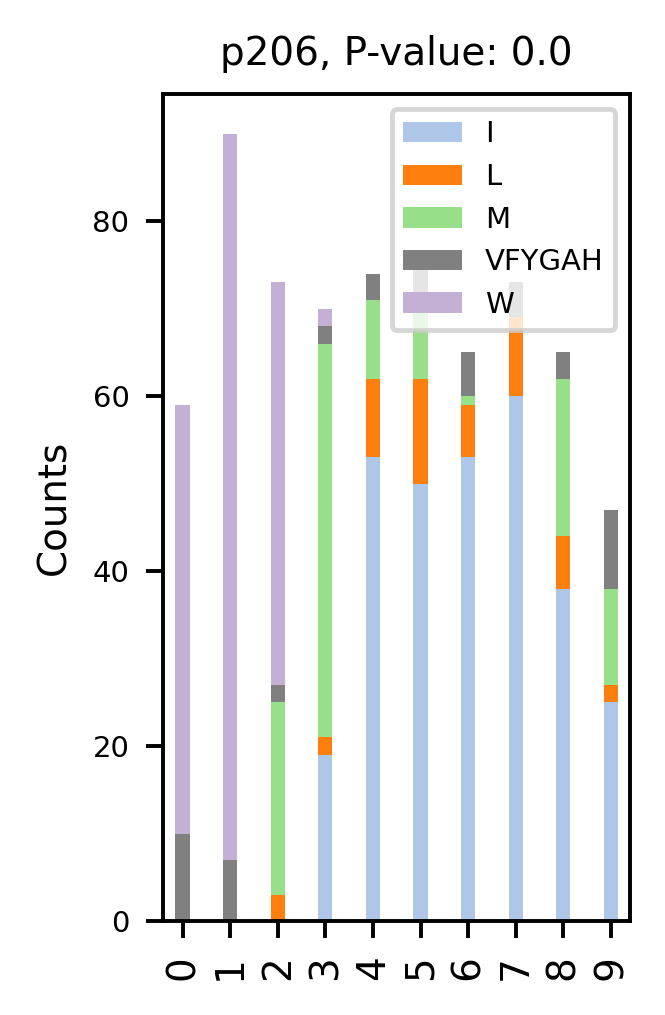

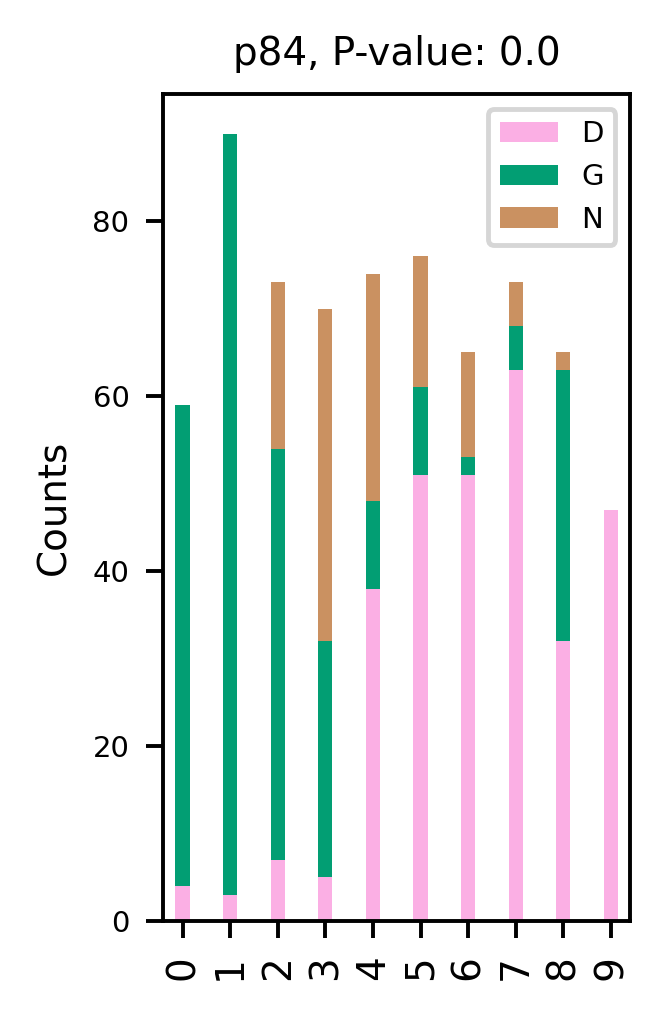

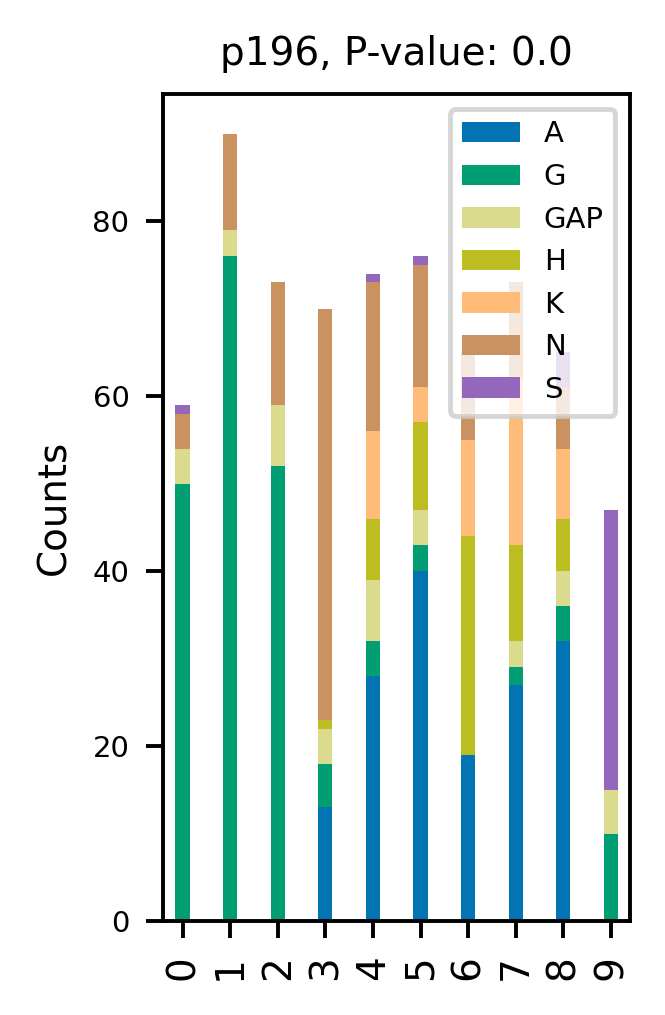

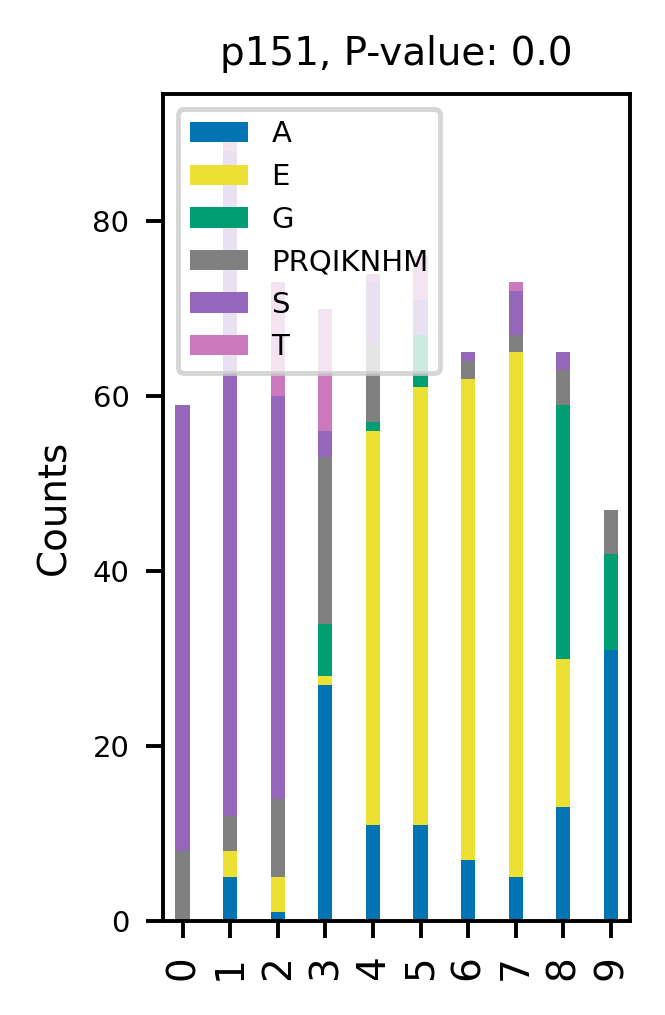

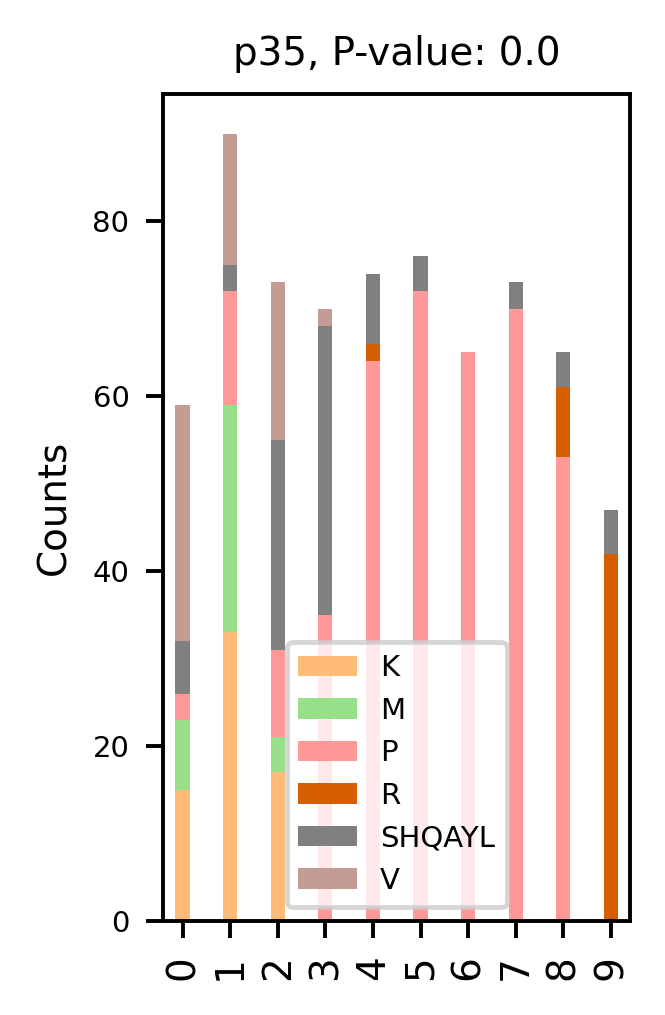

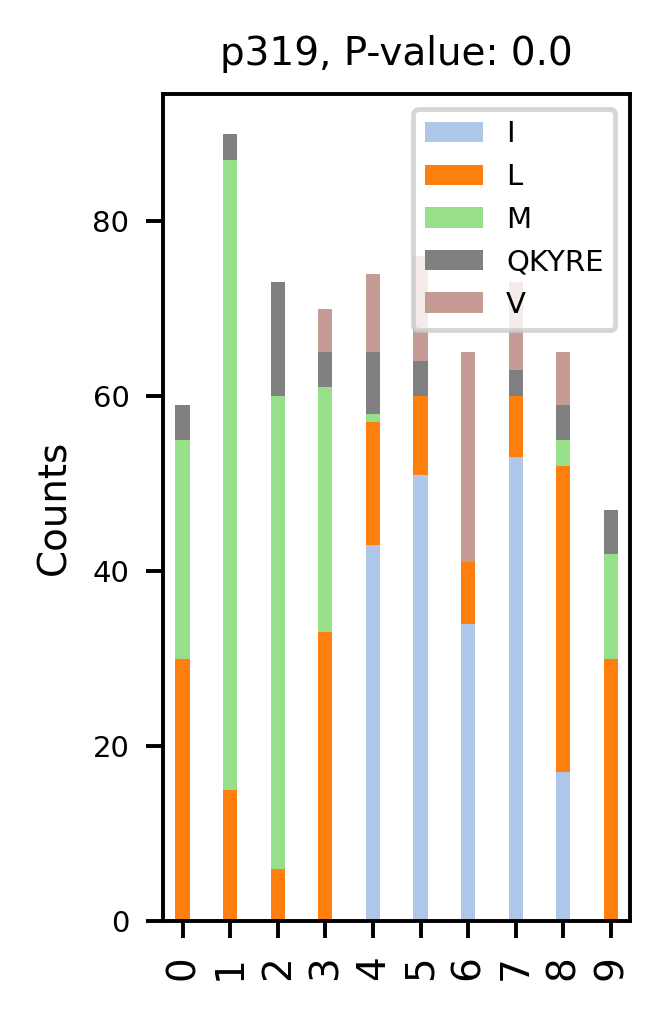

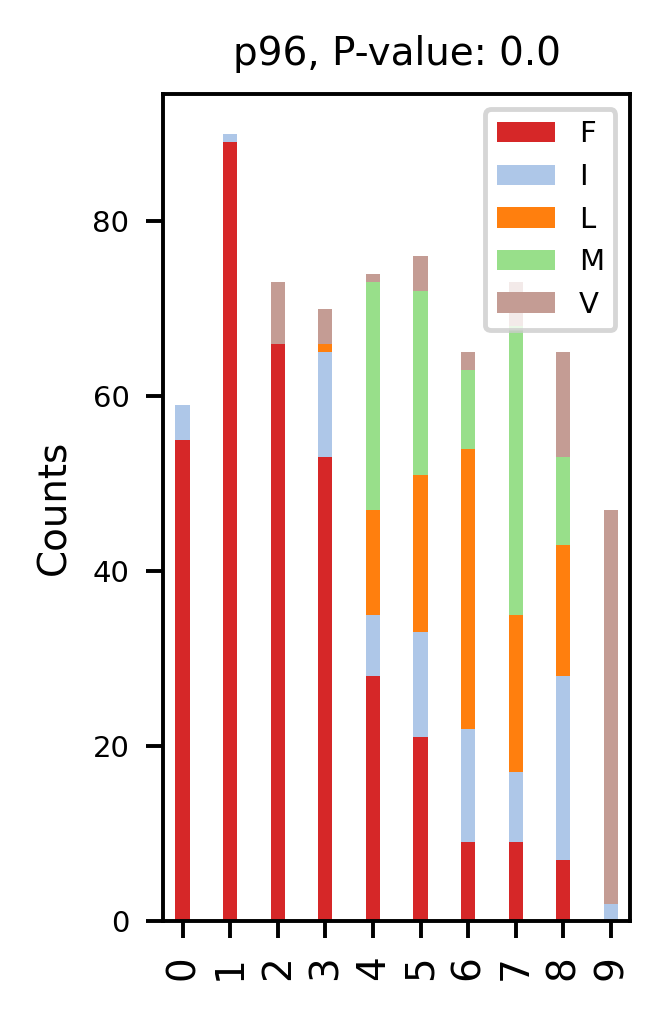

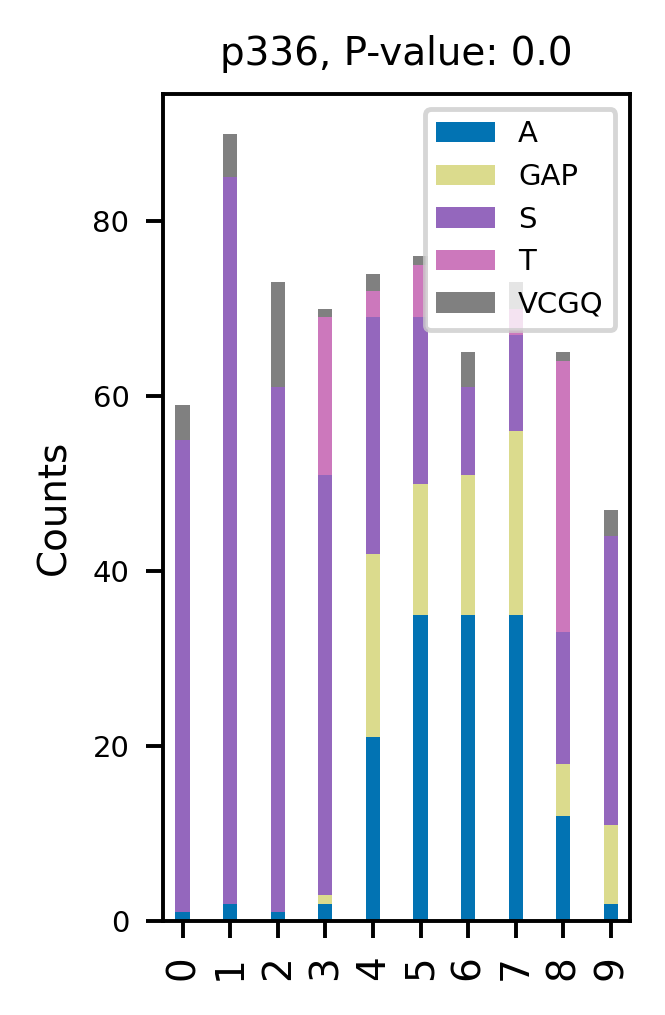

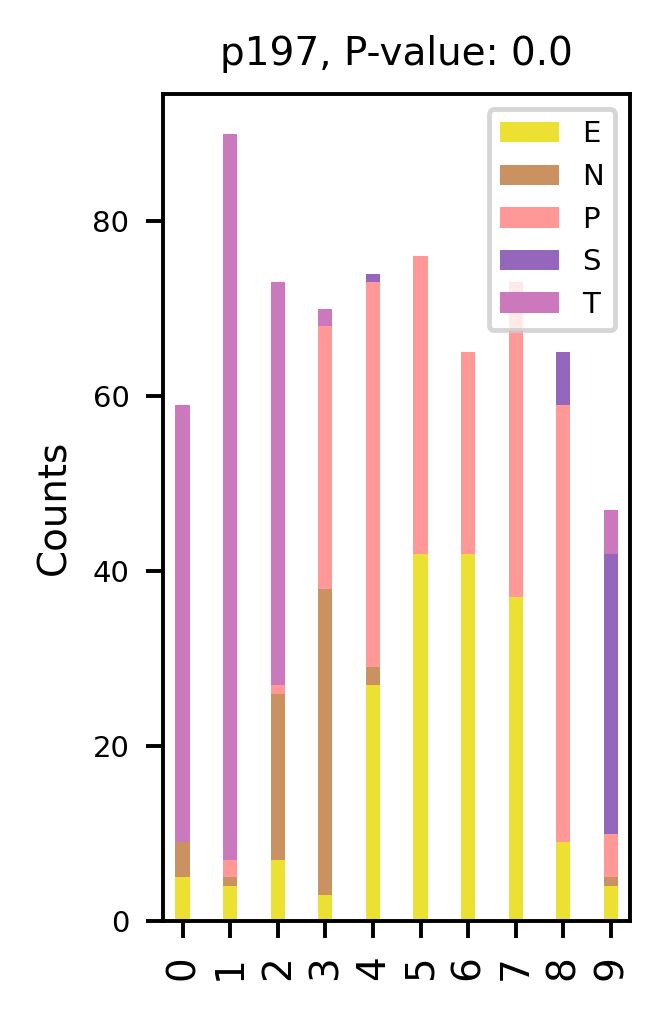

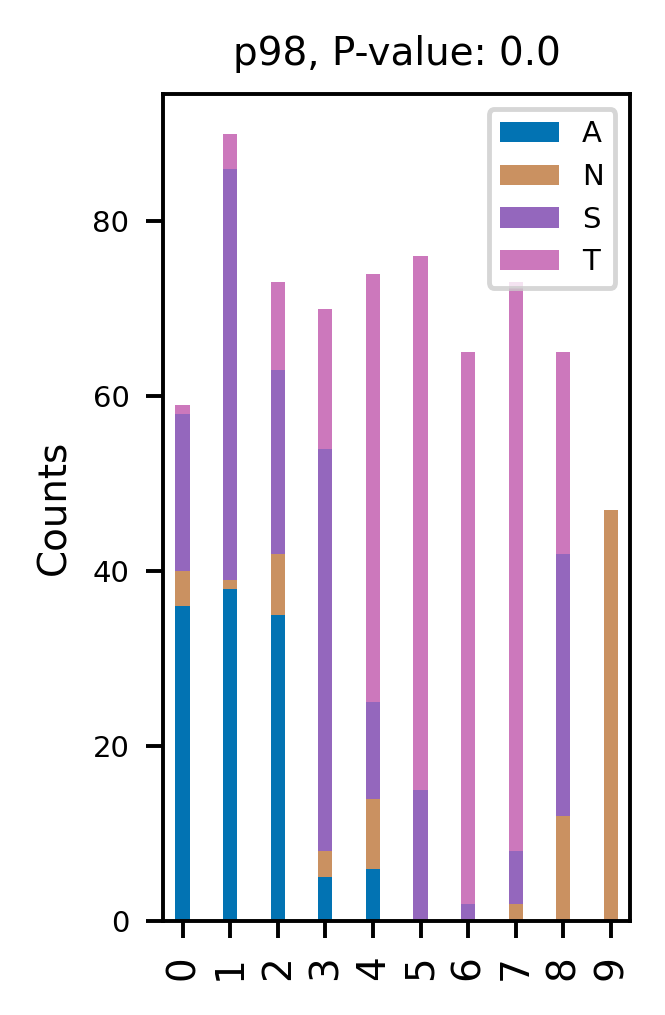

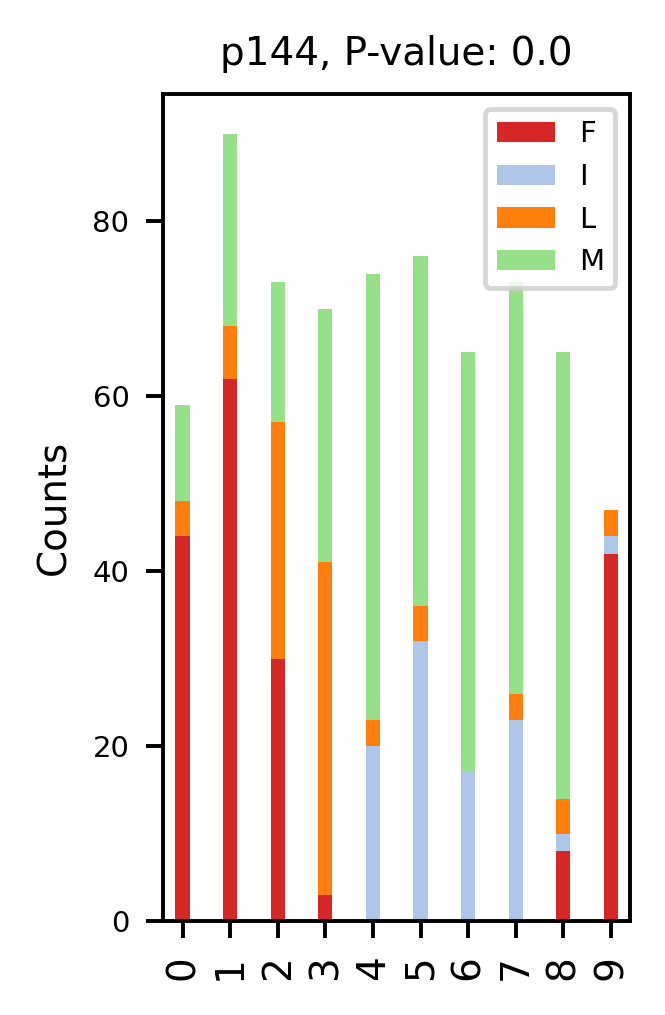

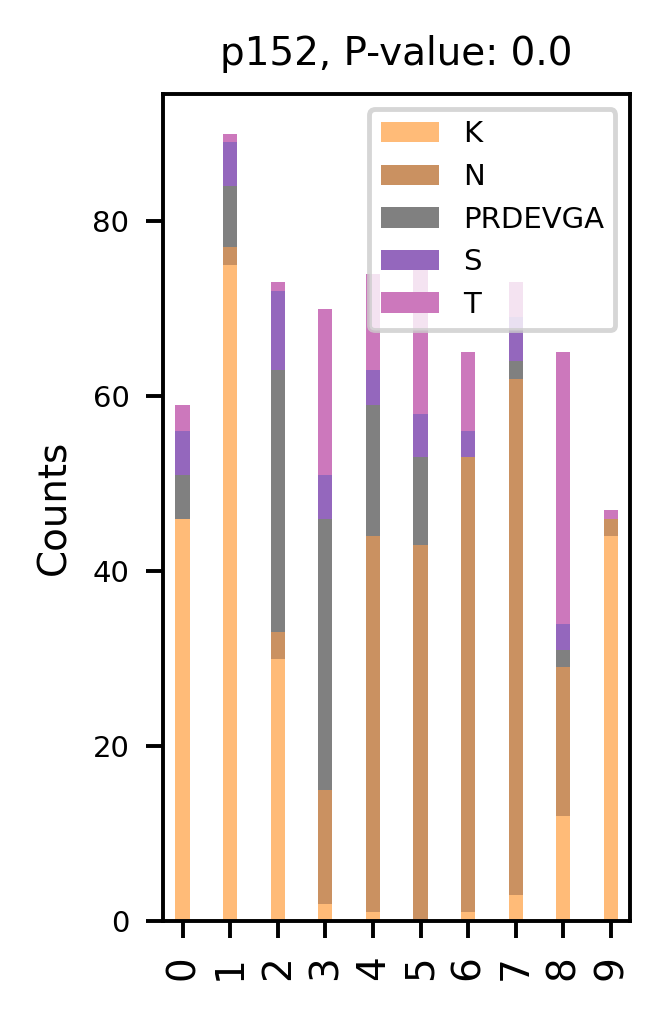

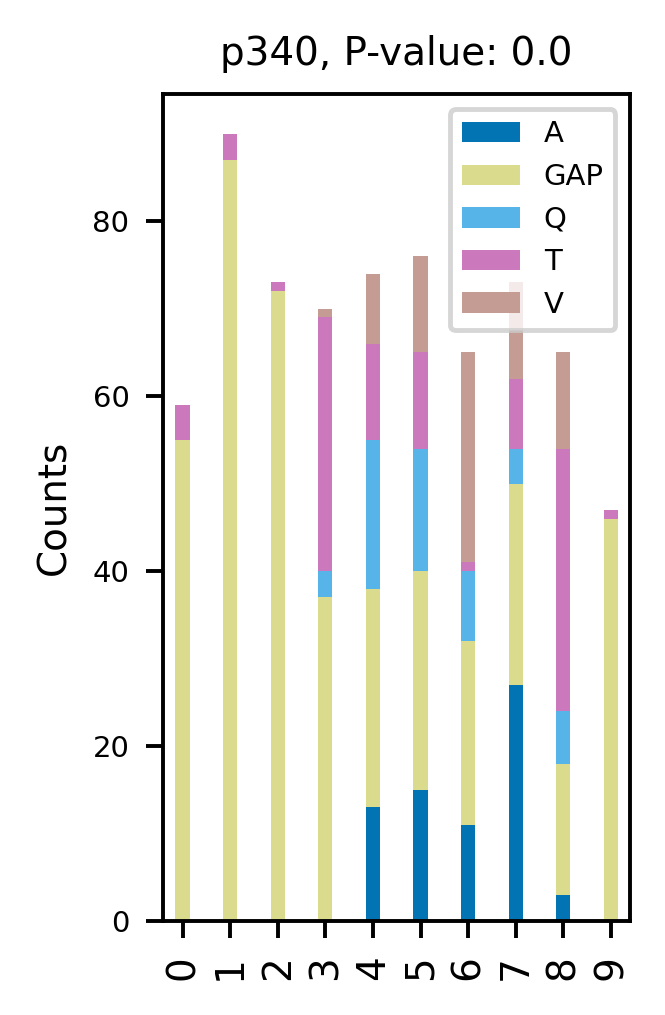

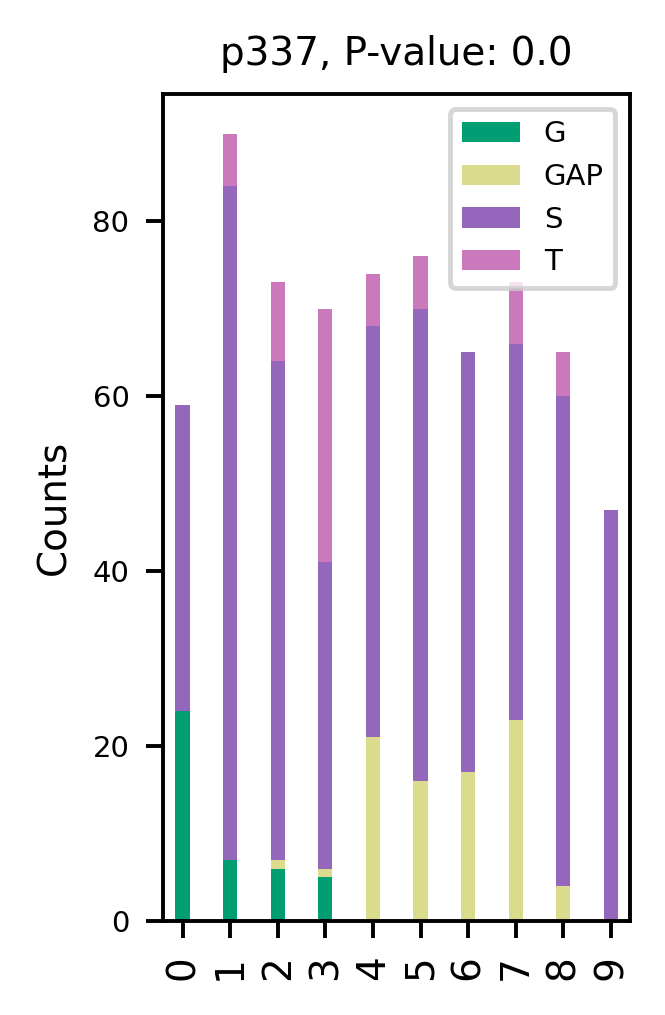

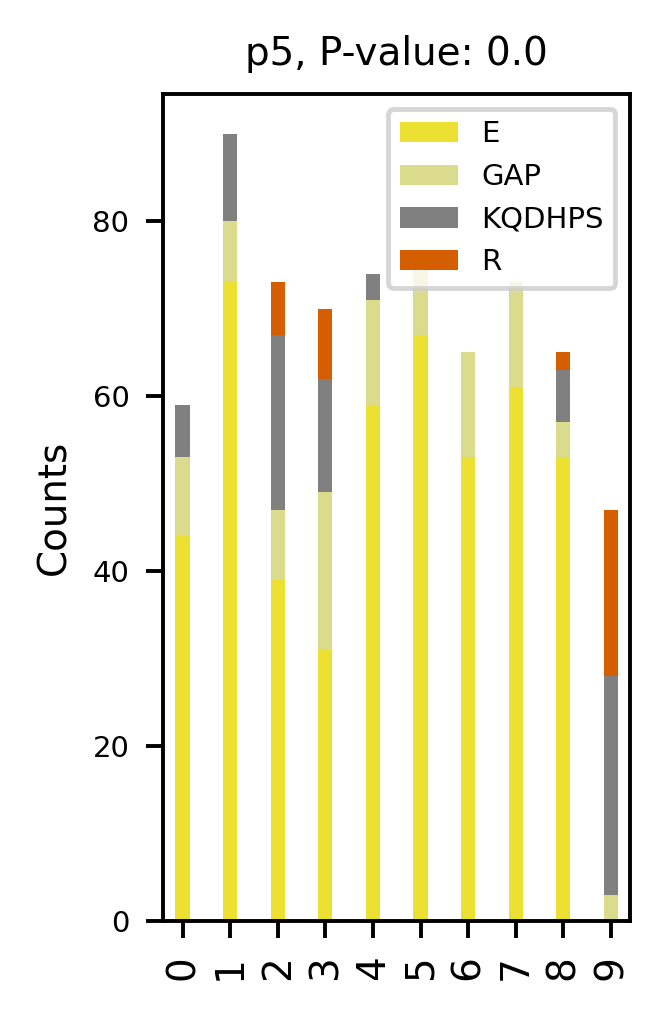

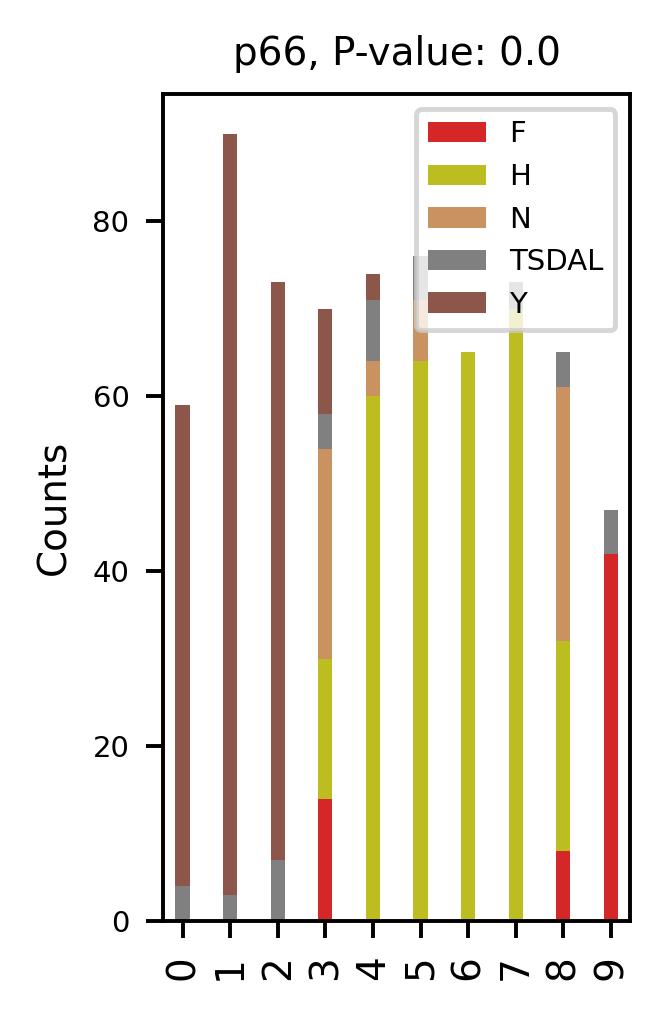

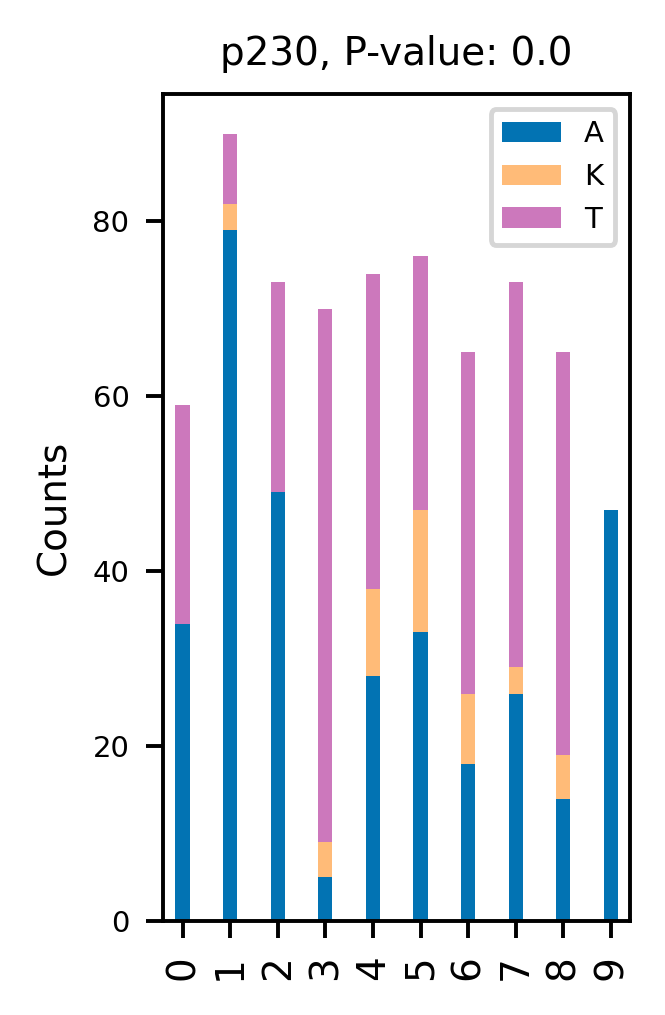

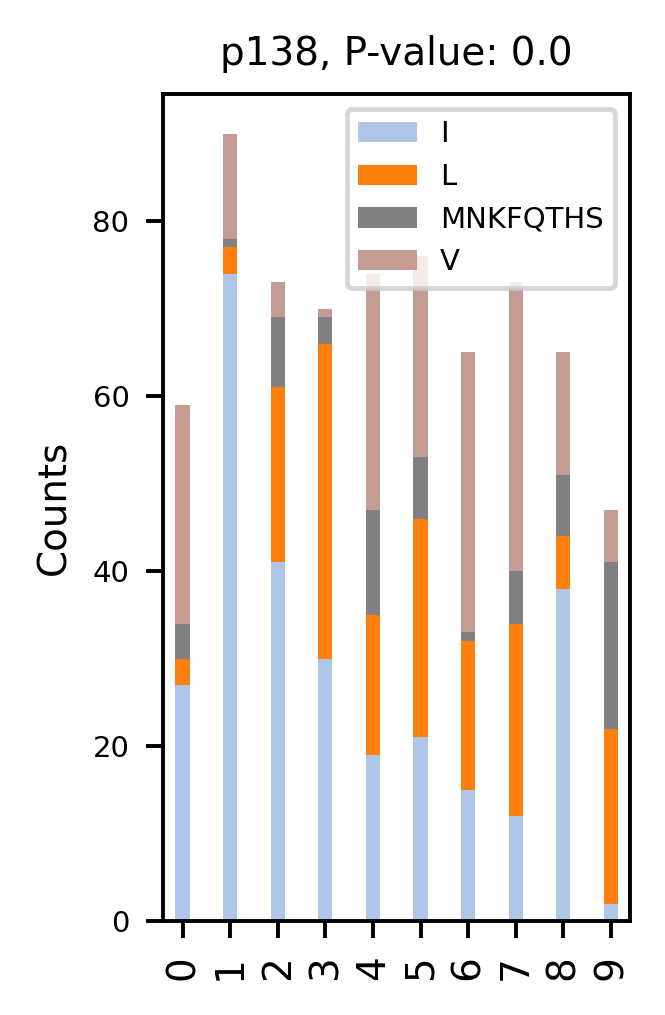

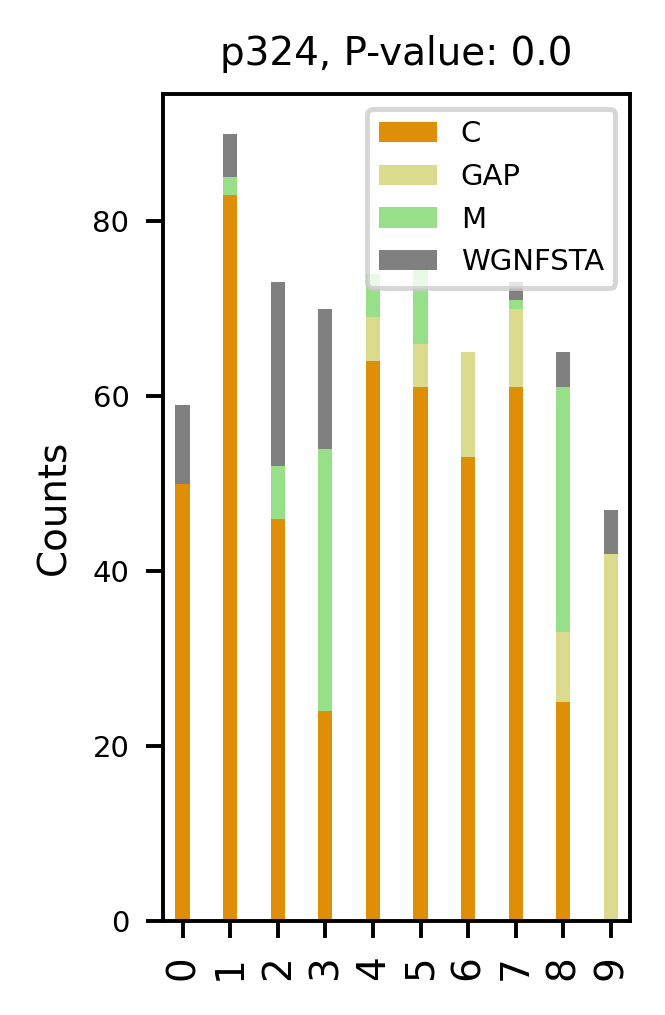

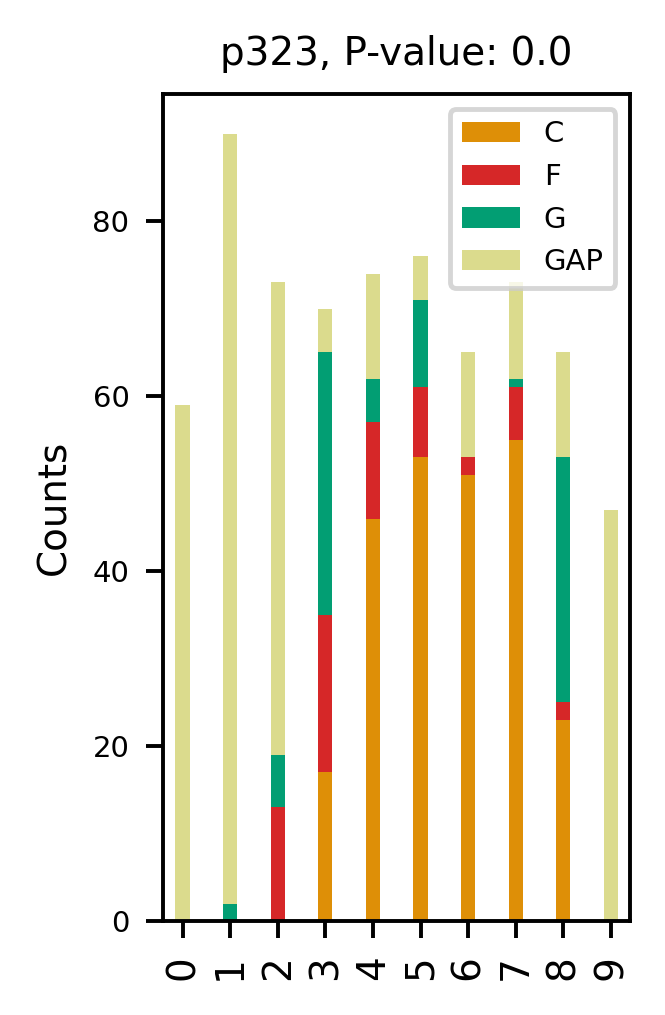

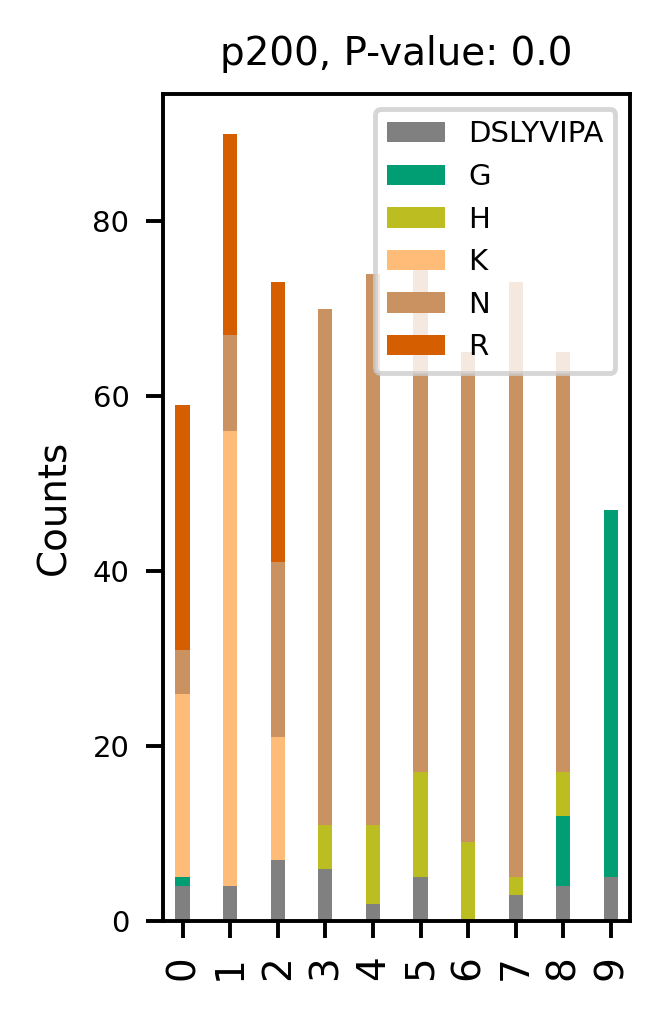

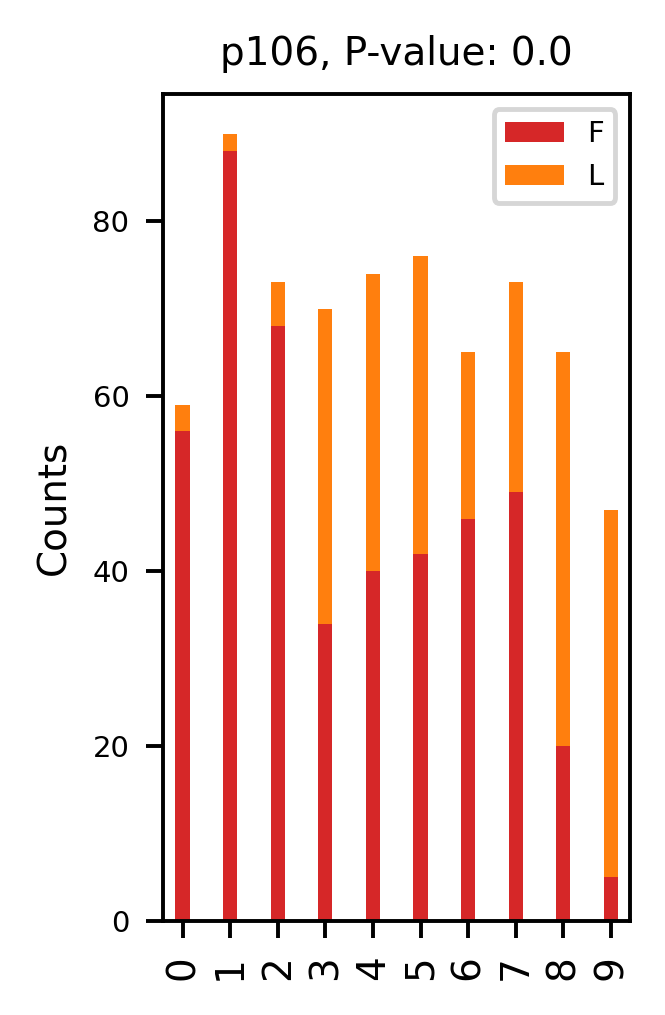

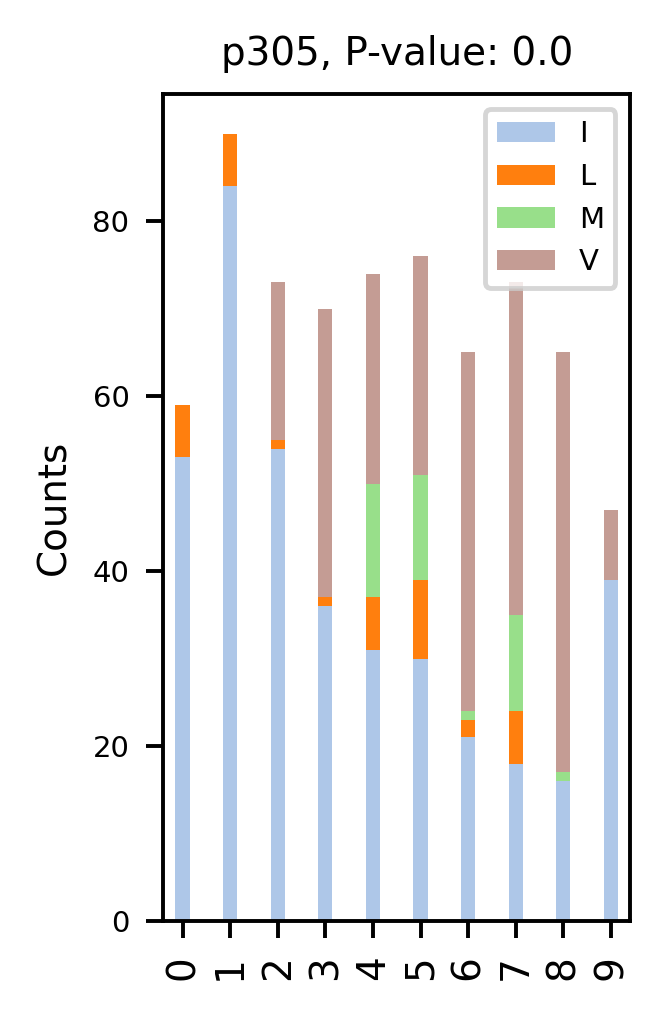

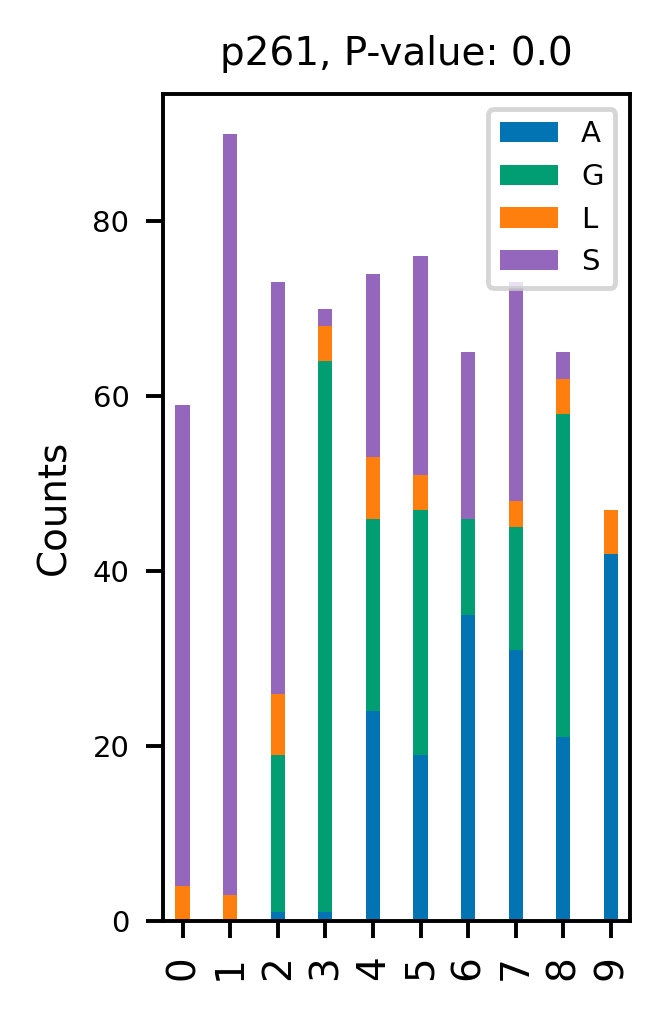

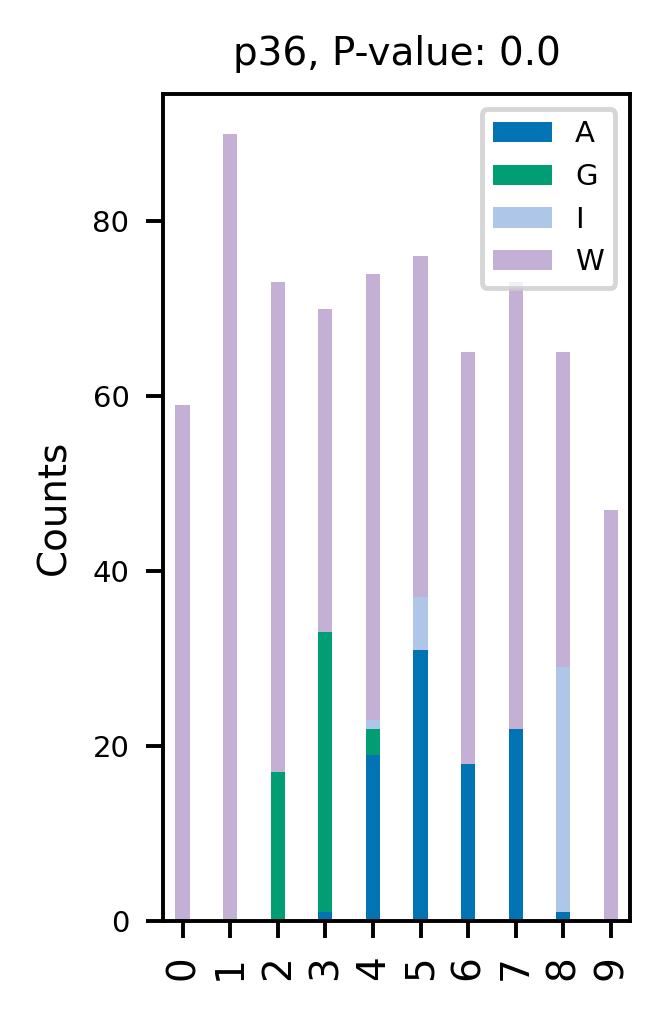

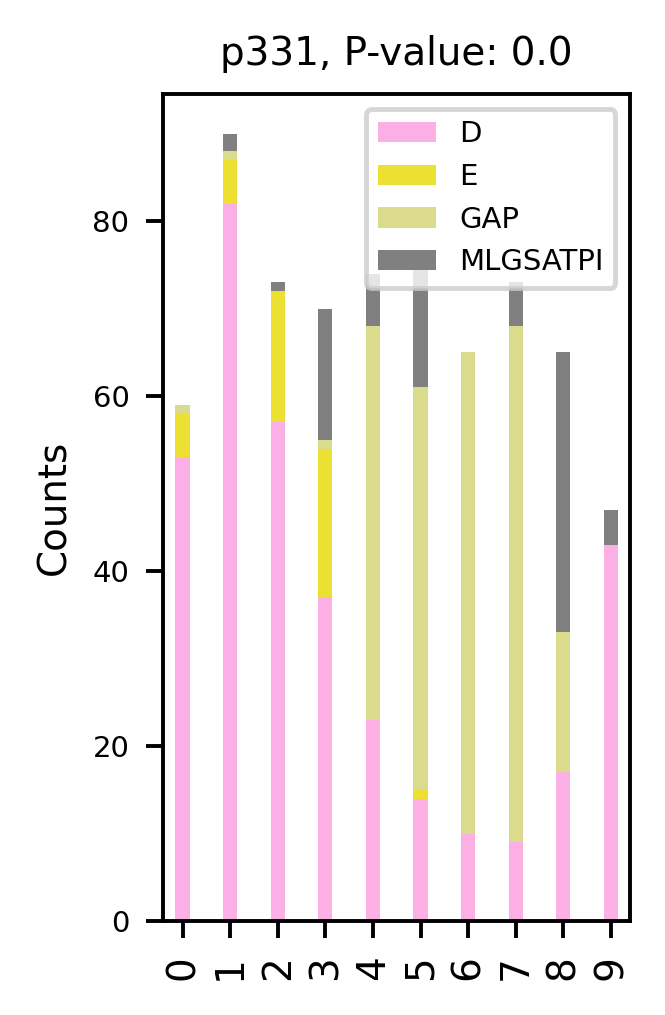

In [131]:
# visualizing top positions  
plots = viz.plot_imp_all(trained_models=trained_models,
                         X_train=df.loc[:, df.columns != mt],
                         y_train=df.loc[:, mt],
                         meta_var=mt,
                         model_type=anaType,
                         report_dir=report_dir,max_plots=100,
                        figsize=(2,3))

In [132]:
import pandas as pd
models = pd.read_csv(report_dir+ '/model_performance.csv', index_col=0)

In [133]:
models

Model  \
et_max_depth=8_n_estimators=1000                    Extra Trees Classifier   
et_max_depth=8_n_estimators=500                     Extra Trees Classifier   
rf_max_depth=8_n_estimators=1000                  Random Forest Classifier   
lgbm_with_default_parameters                                LGBMClassifier   
rf_max_depth=8_n_estimators=500                   Random Forest Classifier   
et_max_depth=6_n_estimators=500                     Extra Trees Classifier   
lg_with_default_parameters                             Logistic Regression   
et_max_depth=6_n_estimators=1000                    Extra Trees Classifier   
rf_max_depth=6_n_estimators=1000                  Random Forest Classifier   
rf_with_default_parameters                        Random Forest Classifier   
rf_max_depth=6_n_estimators=500                   Random Forest Classifier   
et_with_default_parameters                          Extra Trees Classifier   
xgb_with_default_parameters                                  XGBClassifier   
rf_max_depth=4_n_estimators=500                   Random Forest Classifier   
gbc_with_default_parameters                   Gradient Boosting Classifier   
et_max_depth=4_n_estimators=500                     Extra Trees Classifier   
rf_max_depth=4_n_estimators=1000                  Random Forest Classifier   
et_max_depth=4_n_estimators=1000                    Extra Trees Classifier   
dt_with_default_parameters                        Decision Tree Classifier   
dt_max_depth=6                                    Decision Tree Classifier   
dt_max_depth=8                                    Decision Tree Classifier   
dt_max_depth=4                                    Decision Tree Classifier   
Adaboost_learning_rate=0.05_n_estimators=50           Ada Boost Classifier   
Adaboost_learning_rate=0.01_n_estimators=100          Ada Boost Classifier   
Adaboost_learning_rate=0.05_n_estimators=100          Ada Boost Classifier   
Adaboost_learning_rate=0.01_n_estimators=50           Ada Boost Classifier   
Adaboost_with_default_parameters                      Ada Boost Classifier   

                                              Accuracy     AUC      F1  \
et_max_depth=8_n_estimators=1000                0.4869  0.8575  0.4749   
et_max_depth=8_n_estimators=500                 0.4855  0.8569  0.4734   
rf_max_depth=8_n_estimators=1000                0.4827  0.8548  0.4701   
lgbm_with_default_parameters                    0.4739  0.8510  0.4699   
rf_max_depth=8_n_estimators=500                 0.4812  0.8554  0.4692   
et_max_depth=6_n_estimators=500                 0.4841  0.8592  0.4680   
lg_with_default_parameters                      0.4711  0.8574  0.4637   
et_max_depth=6_n_estimators=1000                0.4769  0.8594  0.4625   
rf_max_depth=6_n_estimators=1000                0.4726  0.8580  0.4586   
rf_with_default_parameters                      0.4609  0.8300  0.4558   
rf_max_depth=6_n_estimators=500                 0.4668  0.8575  0.4517   
et_with_default_parameters                      0.4580  0.7950  0.4513   
xgb_with_default_parameters                     0.4537  0.8519  0.4488   
rf_max_depth=4_n_estimators=500                 0.4754  0.8506  0.4449   
gbc_with_default_parameters                     0.4465  0.8340  0.4441   
et_max_depth=4_n_estimators=500                 0.4696  0.8557  0.4412   
rf_max_depth=4_n_estimators=1000                0.4696  0.8524  0.4386   
et_max_depth=4_n_estimators=1000                0.4696  0.8559  0.4377   
dt_with_default_parameters                      0.4234  0.6901  0.4204   
dt_max_depth=6                                  0.3989  0.7670  0.3870   
dt_max_depth=8                                  0.3932  0.7327  0.3766   
dt_max_depth=4                                  0.3224  0.7530  0.3031   
Adaboost_learning_rate=0.05_n_estimators=50     0.2977  0.8071  0.2628   
Adaboost_learning_rate=0.01_n_estimators=100    0.2805  0.7787  0.2513   
Adaboost_learning_rate=0.05_n_esti

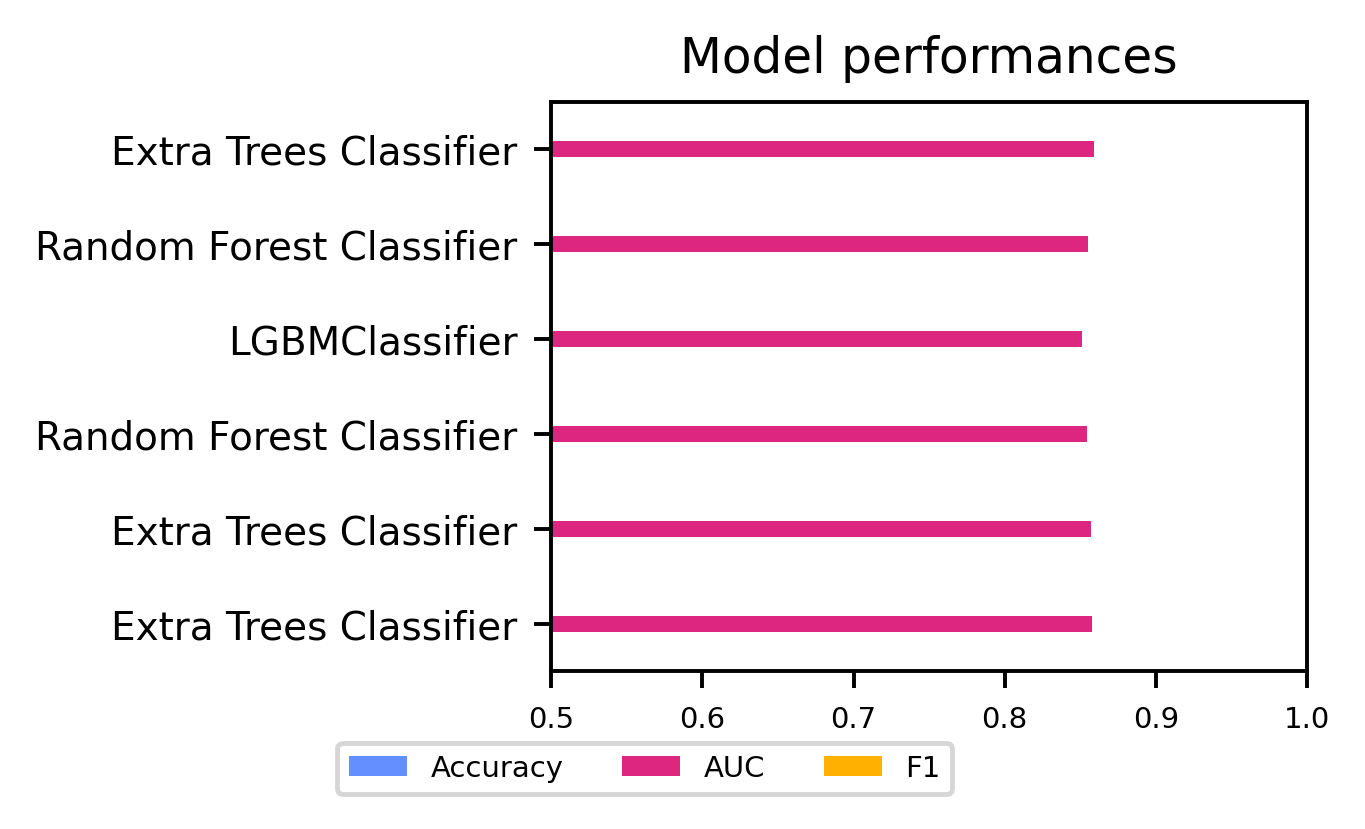

In [134]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=350)
fig = models.iloc[:6,].plot(x="Model", y=["Accuracy", "AUC", "F1"],
                           kind="barh",
                           color=['#648FFF', '#DC267F', '#FFB000'],
                           ax=ax,
                           ylim=(0,1))
ax.legend(bbox_to_anchor=(0.55, -.1), fontsize = 6, ncol=3)
ax.set_title('Model performances', fontsize=10)
ax.set_xlabel('')
plt.xticks(fontsize=6)
plt.ylabel('')
plt.xlim(.5,1)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(str(report_dir + '/model_performances.pdf'),
                bbox_inches='tight')

# STEP 3.5: Classification Testing

In [135]:
x = 0
val = int(0)
data = list()
seq_dict = dict()
unseenData = 'unseendata.fasta' 
seq_type2 = 'amino-acid'
#Following creates a dataframe of aa sequences and their positions as collumns.
df = prp.read_data(unseenData, seq_type = seq_type2, is_main=True)
print(df)
#Turning sequence names into a list for indexing
seq_name = df.index.to_list()
print(seq_name)
#for every sequence in the list of sequences the following function will occur. 
for seq in seq_name:
    data = list()
    for col in training_col_list:
        #take the str of the column name and split at the '_'
        split = str(col).split('_')
        #declare a temp position variable to index df 
        position = str(split[0])
        print(position)
        #declare the aa we will compare the df index to
        aa = str(split[1])
        print(aa)
        count = len(aa)
        #index the df column corresponding to the 'position' variable
        s = df[position]
        #assign value based on whether the aa at some position matches the training_col aa 
        if (s[seq_name[x]] == aa):
            val = int(1)
        
        elif (count > 1):
            for n in range(count):
                amino = aa[n]
                
                if (s[seq_name[x]] == amino):
                    val = int(1)
                    break
                else:
                    val = int(0)   

        else:
            val = int(0)

        data.append(val)
        #print([type(i) for i in data])
        
    seq_dict.update({seq_name[x] : data})
    x+=1
print(seq_dict)
df_for_testing = pd.DataFrame(data = seq_dict.values() , columns = training_col_list, index = seq_dict.keys(), dtype = int)
print(df_for_testing.head())

file3 = open('fmt_data_cols.txt', 'w')
training = str(df_for_testing.to_string())
file3.write(training)
file3.close()

['Neogonodactylus_oerstedii|334|OPC0', 'Neogonodactylus_oerstedii|383|OPC2', 'Bombus_impatiens|539|OPC9', 'Bombus_impatiens|424|OPC3', 'Bombus_impatiens|347|OPC0', 'Drosophilia_melanogaster|486|OPC5', 'Drosophilia_melanogaster|418|OPC2', 'Drosophilia_melanogaster|331|OPC0', 'Drosophilia_melanogaster|355|OPC0', 'Drosophilia_melanogaster|442|OPC3', 'Drosophilia_melanogaster|515|OPC8', 'Lycaena_rubidus|360|OPC0/1', 'Lycaena_rubidus|437|OPC3', 'Lycaena_rubidus|500|OPC7', 'Lycaena_rubidus|568|OPC9', 'Vargula_tsujii|460|OPC4', 'V.tsujii_BCRH2_i7', 'V.tsujii_BCRH2_i0', 'V.tsujii_BCRH2_i6', 'V.tsujii_Rh6_i0', 'V.skogbergia_BCRH1_i1', 'V.skogbergia_BCRH2_i1', 'V.skogbergia_BCRH1_i5']
p2
DLMTQGPHY
p4
G
p4
RSDQAPV
p5
KQDHPS
p5
R
p7
SAQGNLMV
p8
E
p8
GAP
p8
Y
p11
I
p15
N
p17
LGVWYQFEMHN
p19
KVEDTILHQR
p20
L
p20
V
p28
TASE
p30
FKVTWL
p30
H
p34
N
p34
S
p35
M
p37
K
p38
Y
p39
MNTFGILD
p40
GCSFT
p40
V
p43
LCITSG
p43
V
p45
M
p46
LATVMCS
p47
I
p47
L
p47
M
p50
F
p50
I
p50
L
p50
V
p51
FGMSC
p51
I
p53
IAMWGS

In [136]:
print(model_names)
classifier = trained_models[model_names[0]]['model']
prediction = classifier.predict(df_for_testing)
print(prediction)

#trained_models[model_names[0]].keys()
    # load pipeline
    #YOUR_MODEL_NAME = load_model('YOUR_MODEL_NAME')

    #interpret_model(top_models[0])
    
    #prediction = predict_model(YOUR_MODEL_NAME, data = df_for_testing)

    #prediction.to_csv(path_or_buf="class_results.csv",mode="a")

['et_max_depth=8_n_estimators=1000', 'et_max_depth=8_n_estimators=500', 'rf_max_depth=8_n_estimators=1000', 'lgbm_with_default_parameters', 'rf_max_depth=8_n_estimators=500', 'mean']
[2 4 4 4 4 3 2 9 4 2 4 4 4 4 4 5 8 5 8 5 4 5 4]


# <font color=red>Step 4: Graphing Test Results -</font>

In [ ]:
import matplotlib.pyplot as p
import matplotlib.colors as colors
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import argparse
import seaborn as sns
from statistics import mean



The Following Code block turns the mean wavelength of the class range into its hex code equivalent. 


In [ ]:
class_assignment = "classifier_ranges.tsv"
classes = pd.read_csv(class_assignment, delimiter='\t')
class_list = []

for c in classes['Class_Ranges']:
    print(c)
    class_list.append(c)
    print(class_list)

hex_list = []

for waves in class_list:
    gamma = 0.8
    intensity_max = 1
    wave = waves
    if wave < 380:
            red, green, blue = 0, 0, 0
    elif wave < 440:
        red = -(wave - 440) / (440 - 380)
        green, blue = 0, 1
    elif wave < 490:
        red = 0
        green = (wave - 440) / (490 - 440)
        blue = 1
    elif wave < 510:
        red, green = 0, 1
        blue = -(wave - 510) / (510 - 490)
    elif wave < 580:
        red = (wave - 510) / (580 - 510)
        green, blue = 1, 0
    elif wave < 645:
        red = 1
        green = -(wave - 645) / (645 - 580)
        blue = 0
    elif wave <= 780:
        red, green, blue = 1, 0, 0
    else:
        red, green, blue = 0, 0, 0

    # let the intensity fall of near the vision limits
    if wave < 380:
        factor = 0
    elif wave < 420:
        factor = 0.3 + 0.7 * (wave - 380) / (420 - 380)
    elif wave < 700:
        factor = 1
    elif wave <= 780:
        factor = 0.3 + 0.7 * (780 - wave) / (780 - 700)
    else:
        factor = 0

    def f(c):
        if c == 0:
                return 0
        else:
                return intensity_max * pow (c * factor, gamma)
        
    #color = f"{f(red)},{f(green)},{f(blue)}"
    color = [f(green),f(blue),f(red)] 
    print(color)
    hex = colors.rgb2hex(color, keep_alpha=True)
    hex_list.append(hex)

print(hex_list)

340
[340]
360
[340, 360]
380
[340, 360, 380]
420
[340, 360, 380, 420]
450
[340, 360, 380, 420, 450]
480
[340, 360, 380, 420, 450, 480]
490
[340, 360, 380, 420, 450, 480, 490]
495
[340, 360, 380, 420, 450, 480, 490, 495]
505
[340, 360, 380, 420, 450, 480, 490, 495, 505]
520
[340, 360, 380, 420, 450, 480, 490, 495, 505, 520]
560
[340, 360, 380, 420, 450, 480, 490, 495, 505, 520, 560]
[0, 0, 0]
[0, 0, 0]
[0, 0.3816778909618176, 0.3816778909618176]
[0, 1.0, 0.41524364653850576]
[0.27594593229224296, 1.0, 0]
[0.8365116420730186, 1.0, 0]
[1.0, 1.0, 0]
[1.0, 0.7944178807866091, 0]
[1.0, 0.32987697769322355, 0]
[1.0, 0, 0.21082473737065027]
[1.0, 0, 0.7640074112321921]
['#000000ff', '#000000ff', '#006161ff', '#00ff6aff', '#46ff00ff', '#d5ff00ff', '#ffff00ff', '#ffcb00ff', '#ff5400ff', '#ff0036ff', '#ff00c3ff']


The following code takes a csv of predicitons and plots those predicttions relative to the knowns. 

#000000ff
#000000ff
#006161ff
#00ff6aff
#46ff00ff
#d5ff00ff
#ffff00ff
#ffcb00ff
#ff5400ff
#ff0036ff
Annotation(350, 550, 'r^2 = 0.894')


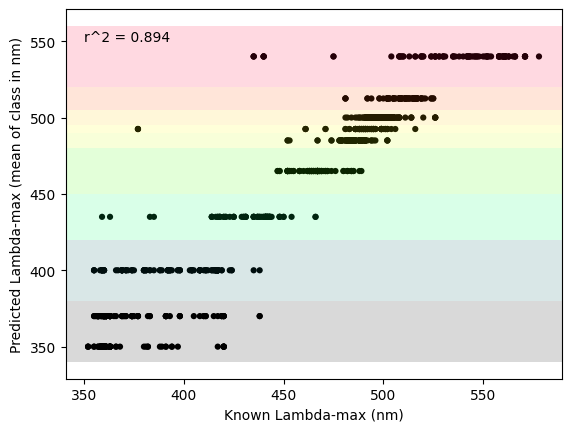

In [ ]:
file = "wds_classifier_test_results_t2.csv"
outfile = "100_iterations_plot"
#https://academo.org/demos/wavelength-to-colour-relationship/

#Read data
table = pd.read_csv(file, delimiter = ',')

#Duplicate predicted class next to change to actual lmax 
table['Predicted_lmax'] = table.loc[:, 'Predicted_Class']
i = 0
for colors in class_list:
#Convert class values to median lambda max value of that class in new column
    if i+1 != len(class_list):
        table['Predicted_lmax'] = table['Predicted_lmax'].replace(i,mean([class_list[i],class_list[i+1]]))
        i+=1
    else: 
        pass


colorby='Score'

#2d
sns.scatterplot(x='Lambda_Max', y='Predicted_lmax', data=table, edgecolor = 'none', color = 'black', s = 20)
plt.xlabel('Known Lambda-max (nm)')
plt.ylabel('Predicted Lambda-max (mean of class in nm)')

i = 0
alpha = 0.05
for wavelengths in class_list:
    if i+1 < len(hex_list):
        print(hex_list[i])
        plt.axhspan(class_list[i],class_list[i+1], facecolor=hex_list[i], alpha=0.15)
        i+=1
    else: 
        pass
    #place colored bands behind plot

m = plt.annotate("r^2 = {:.3f}".format(r2_score(table['Lambda_Max'],table['Predicted_lmax'])), (350, 550))
print(m)
#If no file name show on screen otherwise save pdf
if outfile == '' :
    plt.show()
else:
    fileout = outfile + '.pdf'
    plt.savefig(fileout)


# <font color=red>Step 6: Earth Movers Distance (EMD) of Test Results -</font>
The following code blocks take results from the 100 iterations test and calculates the EMD between the observed and idealized results. 

In [ ]:
from scipy.stats import wasserstein_distance


Input for EMD calculator is the list of class boundaries and the results csv from the 100 iterations test...
Use this metric to calc a p-value by doing various data perturbations...
OR
Use to compare the performance of different models!

In [ ]:
class_list = 340,360,380,420,450,480,490,495,505,520,560
class_means = []
i = 0
for colors in class_list:
#Convert class values to median lambda max value of that class in new column
    if i+1 != len(class_list):
        mean_lambda = mean([class_list[i],class_list[i+1]])
        class_means.append(mean_lambda)
        i+=1
    else: 
        pass

#print(class_means)

class_diffs = []
i = 0
for means in class_means:
    if i+1 != len(class_means):
        #if i == 0:
            #class_diffs.append(0)
        diff_lambda = float(class_means[i+1] - class_means[i])
        class_diffs.append(diff_lambda)
        i+=1
    else: 
        pass

#These will be the weights between classes, and will be additive as the prediction gets further from the ground-truth classification.
print(class_diffs)
#Will need to make it so weight assignment has a 'row_count' corresponding to the class 'y' value of the ordered pair.
class_count = range(len(class_means))
#make a set of all possible ordered pair combinations...
#(0,0),(0,1),(0,2)....
ordered_pairs = []
#m will be our'known_class'
for m in class_count:
    i = 0
    while i <= len(class_count)-1:
        ordered_pairs.append([i,m])
        i+=1
#print(ordered_pairs)
iter_res = open("wds_classifier_test_results_t2.csv", "r",)
results_csv = csv.reader(iter_res, delimiter=",")
data_columns = ["Pred_Known","Count","Weight","Score","True_Num"]
results_df = pd.DataFrame(columns=data_columns)
results_df.Pred_Known = ordered_pairs
results_df.Count = 0 
results_df.Score = 0
results_df.Weight = 0
results_df.True_Num = 0
results_df.set_index("Pred_Known")
#print(results_df)
x = 0
for entry in results_csv:
    if x == 0:
        x+=1
    else:
        pair = [int(entry[2]),int(entry[1])]
        i = 0
        for plot in results_df.Pred_Known:
            if plot[0] == pair[0] and plot[1] == pair[1]:
                results_df.Count[i]+= 1
                results_df.Score[i] += float(entry[4])
                m = 0
                for s in results_df.Pred_Known:
                    if s[1] == pair[1] and s[0] == s[1]: 
                        results_df.True_Num[m] += 1 
                    m+=1
            i+=1
    

x = 0
for score in results_df.Score:
    if score == 0:
        results_df.Score[x] = 0.000
    else:
        score = score / results_df.Count[x]
        results_df.Score[x] = score

    x+=1
#print(results_df)

x = 0
for plot in results_df.Pred_Known:
    #iterate through and assign weights to each ordered pair...
        #weight = mean confidence score x sum of the differences between means of class range that serpate the prediction from ground truth.
    if plot[0] > plot[1]:
        i = plot[1]
        while i < plot[0]:
            results_df.Weight[x] += class_diffs[i] * results_df.Score[x]
            i+=1
    elif plot[0] < plot[1]:
        i = plot[0]
        while i < plot[1]:
            results_df.Weight[x] +=  class_diffs[i] * results_df.Score[x] 
            i+=1          
    else:
        pass
    x+=1
print(results_df)

whole_matrix = wasserstein_distance(results_df.Count.to_list(),results_df.True_Num.to_list(),results_df.Weight.to_list(),results_df.Weight.to_list())
emd = str(whole_matrix)
print(emd)

results_df.to_csv(path_or_buf="100_iter_matrix.csv",index = False,mode="w")


[20.0, 30.0, 35.0, 30.0, 20.0, 7.5, 7.5, 12.5, 27.5]


C:\Users\safra\AppData\Local\Temp\ipykernel_50360\3047994040.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df.Count[i]+= 1
C:\Users\safra\AppData\Local\Temp\ipykernel_50360\3047994040.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df.Score[i] += float(entry[4])
C:\Users\safra\AppData\Local\Temp\ipykernel_50360\3047994040.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df.True_Num[m] += 1


   Pred_Known  Count     Weight     Score  True_Num
0      [0, 0]     45   0.000000  0.843980        73
1      [1, 0]     17  12.648118  0.632406         0
2      [2, 0]     10  25.082000  0.501640         0
3      [3, 0]      1  53.422500  0.628500         0
4      [4, 0]      0   0.000000  0.000000         0
..        ...    ...        ...       ...       ...
95     [5, 9]      0   0.000000  0.000000         0
96     [6, 9]      0   0.000000  0.000000         0
97     [7, 9]      5  29.624800  0.740620         0
98     [8, 9]      6  23.390125  0.850550         0
99     [9, 9]     77   0.000000  0.910905        88

[100 rows x 5 columns]
7.778649257925016


C:\Users\safra\AppData\Local\Temp\ipykernel_50360\3047994040.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df.Weight[x] += class_diffs[i] * results_df.Score[x]
